In [1]:
from Preprocessing_Module import read_data, add_topological, add_landcover, merge_new_data, fill_data, select_columns, reshape_dataset, fillna_dataset, remove_nan_features, statistics, plot_correlations, temp_rainfall_plot
from Feature_Expansion_Module import feature_expansion
from Initializer_Module import initializer
from XGboost_Model_Module import Xgboost_model
from Neural_Network_Module import FeedforwardNeuralNetModel
from Model_Validation_Module import give_predictions_nn, evaluate_nn, give_predictions_xgboost, evaluate_xgboost, validate_results2, merge_predictions
import numpy as np
import pandas as pd

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
import warnings
warnings.filterwarnings('ignore')
np.set_printoptions(suppress=True)

In [3]:
data = read_data('../Datasets/Germany/GER_wuerttemberg_culex_2010_2023.csv')
data = merge_new_data('../Datasets/Germany/2023/GER_env_05_2023_2km_processed.csv', data)
data = merge_new_data('../Datasets/Germany/2023/GER_env_06_2023_2km_processed.csv', data)
data = merge_new_data('../Datasets/Germany/2023/GER_env_07_2023_2km_processed.csv', data)
data = merge_new_data('../Datasets/Germany/2023/GER_env_08_2023_2km_processed.csv', data)
data = merge_new_data('../Datasets/Germany/2023/GER_env_09_2023_2km_processed.csv', data)
data = merge_new_data('../Datasets/Germany/2023/GER_env_10_2023_2km_processed.csv', data)
columns = ['dt_placement', 'x', 'y', 'culex.spp', 'ndvi', 'ndwi', 'ndmi', 'ndbi',
           'ndvi_mean', 'ndvi_std', 'ndwi_mean', 'ndwi_std', 'ndmi_mean',
           'ndmi_std', 'ndbi_mean', 'ndbi_std', 'lst_day', 'lst_night',
           'acc_rainfall_1week', 'acc_rainfall_2week', 'acc_rainfall_jan',
           'lst_jan_day_mean', 'lst_feb_day_mean', 'lst_mar_day_mean', 'lst_apr_day_mean',
           'lst_jan_night_mean', 'lst_feb_night_mean', 'lst_mar_night_mean', 'lst_apr_night_mean']
names = ['dt_placement', 'x', 'y', 'mosq_now', 'ndvi', 'ndwi', 'ndmi', 'ndbi',
         'ndvi_mean', 'ndvi_std', 'ndwi_mean', 'ndwi_std', 'ndmi_mean',
         'ndmi_std', 'ndbi_mean', 'ndbi_std', 'lst_day', 'lst_night',
         'acc_rainfall_1week', 'acc_rainfall_2week', 'acc_rainfall_jan',
         'lst_jan_day_mean', 'lst_feb_day_mean', 'lst_mar_day_mean', 'lst_apr_day_mean',
         'lst_jan_night_mean', 'lst_feb_night_mean', 'lst_mar_night_mean', 'lst_apr_night_mean']
data = select_columns(data,columns,names)
data = add_topological(data,'../Datasets/Topological Datasets/2x2grid/germany_wuerttemberg_2km_geo.csv')
data = add_landcover(data,'../Datasets/Landcover Datasets/2x2grid/germany_wuerttemberg_2km_lulc.csv')
data = reshape_dataset(data,['x','y','dt_placement'])
data = fillna_dataset(data,{'acc_rainfall_1week':0, 'acc_rainfall_2week':0, 'acc_rainfall_jan':0})

Index(['station_id', 'x', 'y', 'dt_placement', 'week', 'month', 'year',
       'country_code', 'nuts0_code', 'nuts0_name', 'nuts1_code', 'nuts1_name',
       'nuts2_code', 'nuts2_name', 'nuts3_code', 'nuts3_name',
       'lau1_municipality', 'lau2_settlement', 'trap_type', 'culex.spp',
       'region', 'dt_placement_original', 'indices_image_date', 'indices_lat',
       'indices_lon', 'ndvi', 'ndmi', 'ndwi', 'ndbi', 'ndvi_mean', 'ndmi_mean',
       'ndwi_mean', 'ndbi_mean', 'ndvi_std', 'ndmi_std', 'ndwi_std',
       'ndbi_std', 'lst_image_date', 'lst_lat', 'lst_lon', 'lst_day',
       'lst_night', 'monthly_lst_lat', 'monthly_lst_lon', 'lst_jan_day_mean',
       'lst_jan_night_mean', 'lst_feb_day_mean', 'lst_feb_night_mean',
       'lst_mar_day_mean', 'lst_mar_night_mean', 'lst_apr_day_mean',
       'lst_apr_night_mean', 'indices_image_date.1', 'indices_lat.1',
       'indices_lon.1', 'acc_rainfall_jan', 'dt_placement_minus_7',
       'dt_placement_minus_14', 'dt_placement_minus_7_avail

In [4]:
# set the filename for export
case = 'Culex_Germany_'

# set the filename to export
path = './predictions/Germany/'

# set the name of the date column
date_col = 'dt_placement'

# set the model type. Could be 'class_regression' or 'mosquito_regression' or 'classification'
model_type = 'class_regression'

In [5]:
data = feature_expansion(data)

In [ ]:
temp_rainfall_plot(data, rainfall_column='acc_rainfall_2week')

In [6]:
date_column='dt_placement'
mosq = data[[date_column,'mosq_now']]
mosq = mosq.groupby(date_column).mean().reset_index()
mosq = mosq.groupby(mosq[date_column].dt.to_period('M')).mean().drop(columns=[date_column]).reset_index()
mosq[date_column] = mosq[date_column].dt.to_timestamp()
mosq[mosq['dt_placement'].dt.month==4]

dt_placement  mosq_now
0    2010-04-01  0.090909
6    2011-04-01  0.474026
12   2012-04-01  0.287500
18   2013-04-01  0.676738
24   2014-04-01  1.597322
30   2015-04-01  1.557924
36   2016-04-01  0.500000
42   2017-04-01  0.117849
48   2018-04-01  0.335317
54   2019-04-01  0.183935
60   2020-04-01  2.621429
66   2021-04-01  1.111111
72   2022-04-01  2.888889
78   2023-04-01  0.301709

In [7]:
mosq[mosq['dt_placement'].dt.month==5]

dt_placement  mosq_now
1    2010-05-01  0.601122
7    2011-05-01  9.922998
13   2012-05-01  1.118750
19   2013-05-01  4.873206
25   2014-05-01  1.913538
31   2015-05-01  5.848795
37   2016-05-01  8.334225
43   2017-05-01  3.226369
49   2018-05-01  5.986686
55   2019-05-01  1.949582
61   2020-05-01  3.924056
67   2021-05-01  5.100000
73   2022-05-01  5.891827
79   2023-05-01  2.966675

In [8]:
mosq[mosq['dt_placement'].dt.month==6]

dt_placement    mosq_now
2    2010-06-01   10.041277
8    2011-06-01    2.660014
14   2012-06-01   15.472046
20   2013-06-01  302.126173
26   2014-06-01    1.549051
32   2015-06-01    8.354810
38   2016-06-01  309.448752
44   2017-06-01    2.663070
50   2018-06-01    6.676178
56   2019-06-01   17.439416
62   2020-06-01    7.514176
68   2021-06-01         NaN
74   2022-06-01    1.531432
80   2023-06-01    5.348580

In [9]:
mosq[mosq['dt_placement'].dt.month==7]

dt_placement    mosq_now
3    2010-07-01    7.198693
9    2011-07-01    2.790119
15   2012-07-01   10.015741
21   2013-07-01   94.953905
27   2014-07-01   23.850504
33   2015-07-01    4.307394
39   2016-07-01  186.506669
45   2017-07-01    1.559441
51   2018-07-01    6.973052
57   2019-07-01    7.342331
63   2020-07-01    7.868939
69   2021-07-01  893.770833
75   2022-07-01    1.871613
81   2023-07-01    2.537455

In [10]:
mosq[mosq['dt_placement'].dt.month==8]

dt_placement    mosq_now
4    2010-08-01    1.040152
10   2011-08-01    1.751352
16   2012-08-01    3.743056
22   2013-08-01    7.639973
28   2014-08-01    8.356662
34   2015-08-01    3.083009
40   2016-08-01    6.072747
46   2017-08-01    1.003739
52   2018-08-01    3.674209
58   2019-08-01    2.833231
64   2020-08-01    4.545556
70   2021-08-01  300.879983
76   2022-08-01    1.081099
82   2023-08-01    3.402717

In [11]:
mosq[mosq['dt_placement'].dt.month==9]

dt_placement  mosq_now
5    2010-09-01  0.568182
11   2011-09-01  0.566308
17   2012-09-01  0.835185
23   2013-09-01  0.264205
29   2014-09-01  0.575259
35   2015-09-01  0.090909
41   2016-09-01  2.244179
47   2017-09-01  0.441810
53   2018-09-01  0.838051
59   2019-09-01  1.145047
65   2020-09-01  1.822222
71   2021-09-01  4.441964
77   2022-09-01  0.183048
83   2023-09-01  0.932051

Total observatons: 6724
Number of unique traps: 86
Start date: 2010-04-11 00:00:00
End date: 2023-09-13 00:00:00


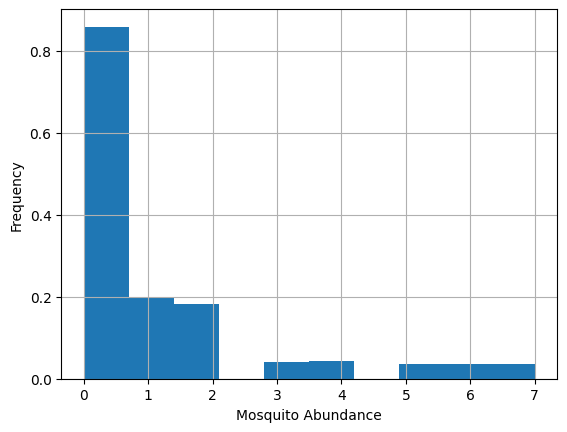

Mean: 1.421624033313504
Std: 2.3587162708056586
Skewness: 1.8896355058809462
kurtosis: 2.6083357606686386
2021 number of observations: 200
2022 number of observations: 369
2023 number of observations: 562
All operational years observations: 1131
Number of fixed traps: 76
Number of temporal traps: 10


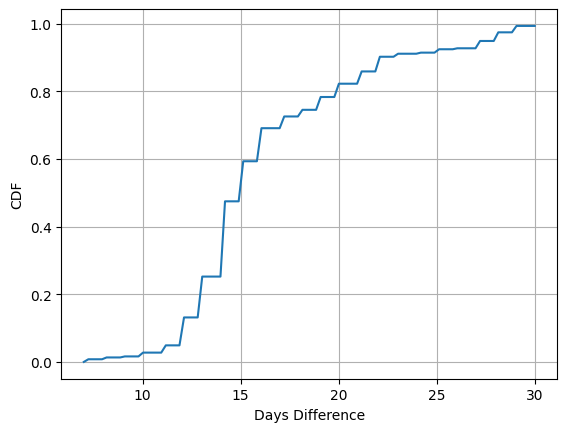

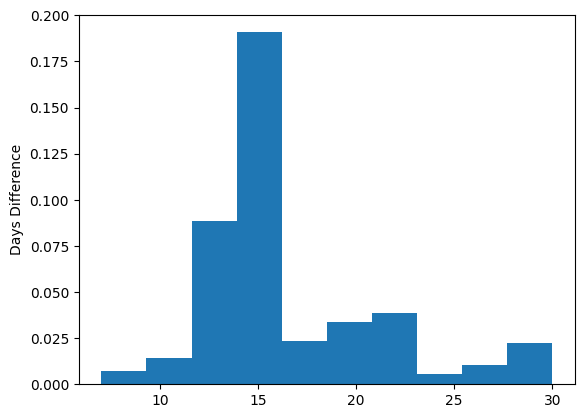

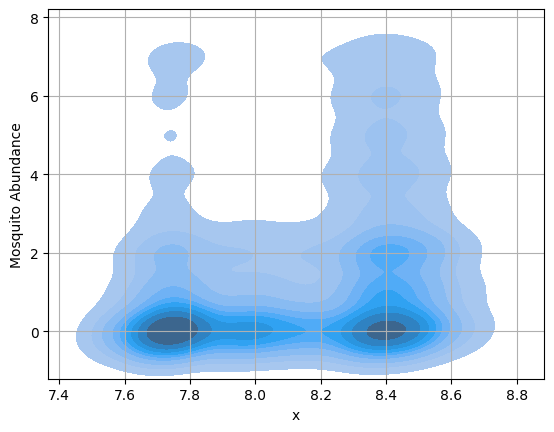

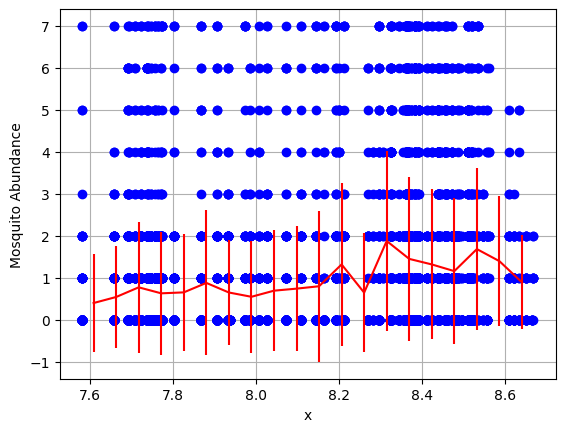

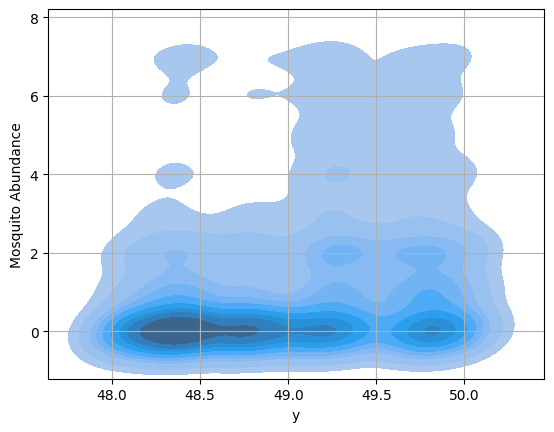

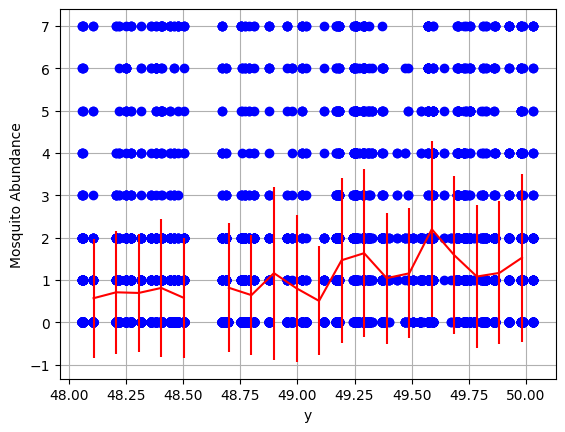

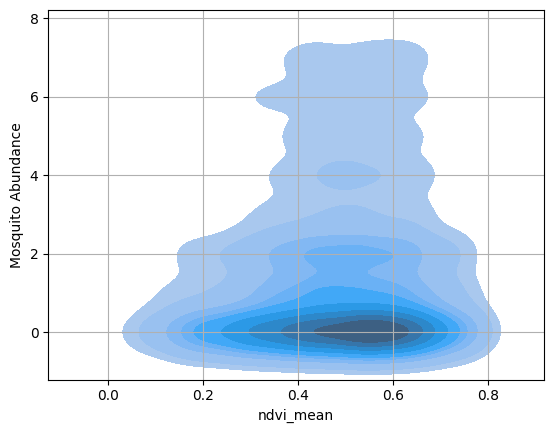

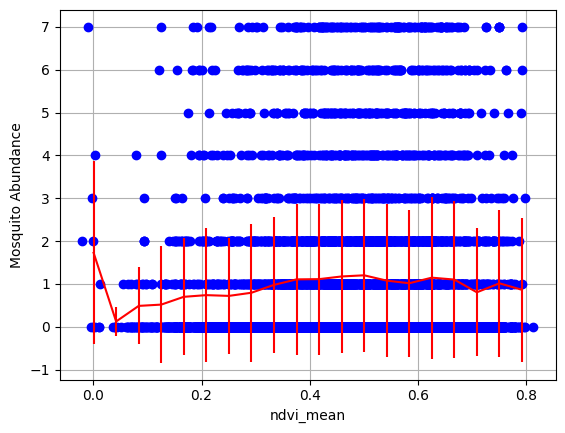

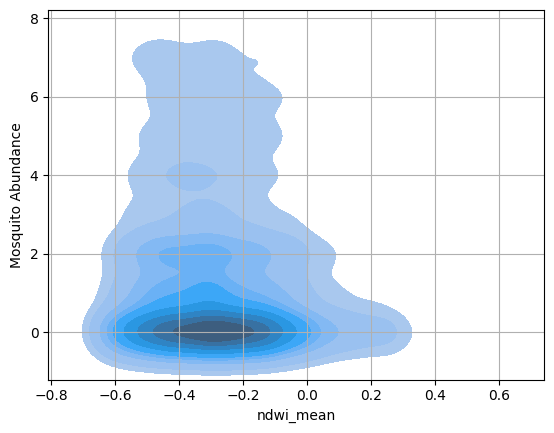

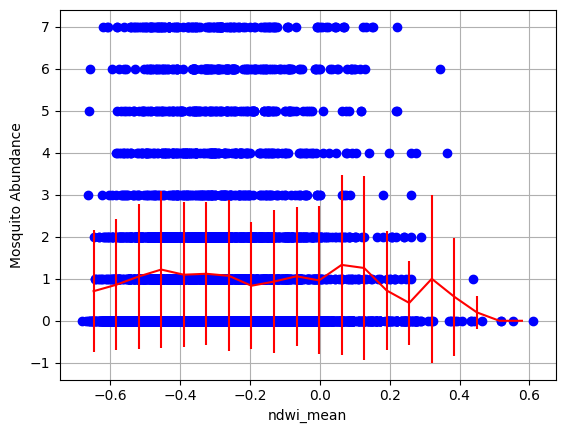

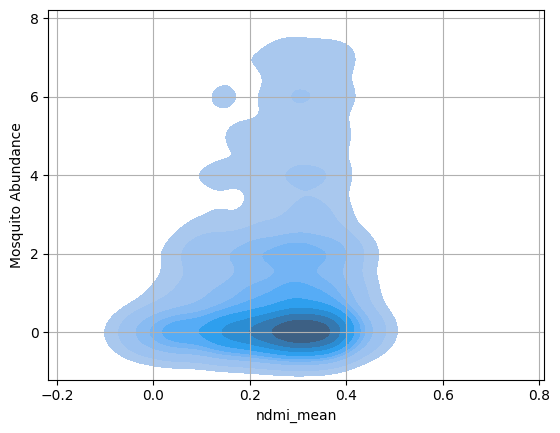

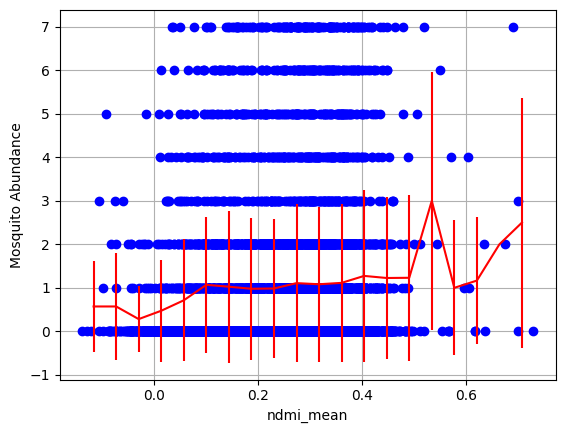

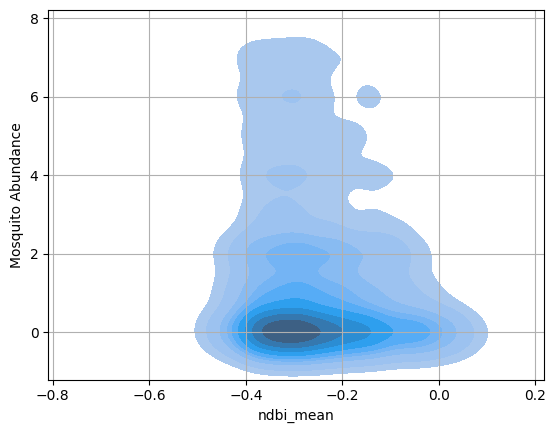

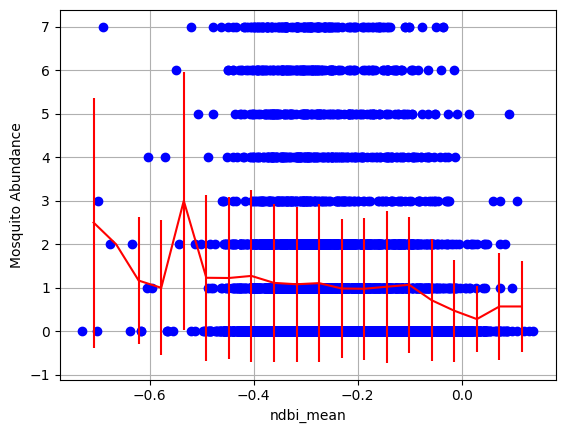

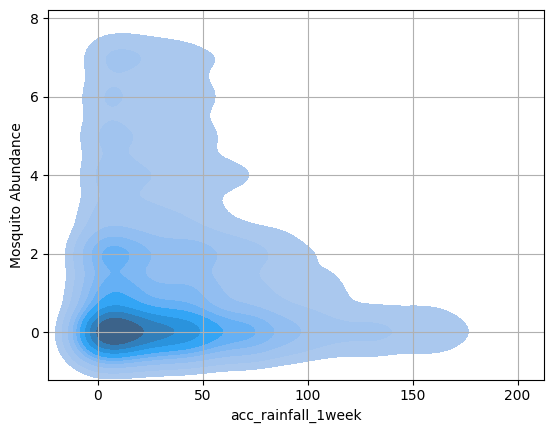

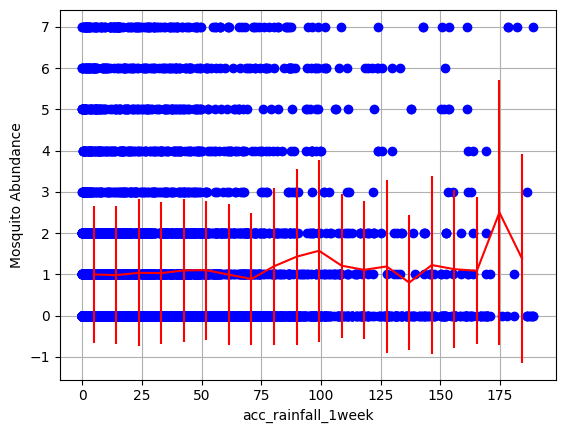

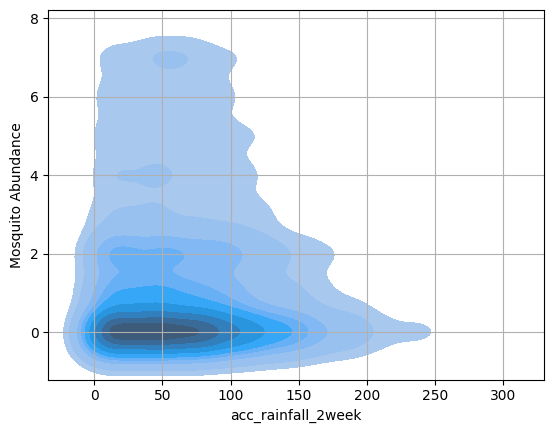

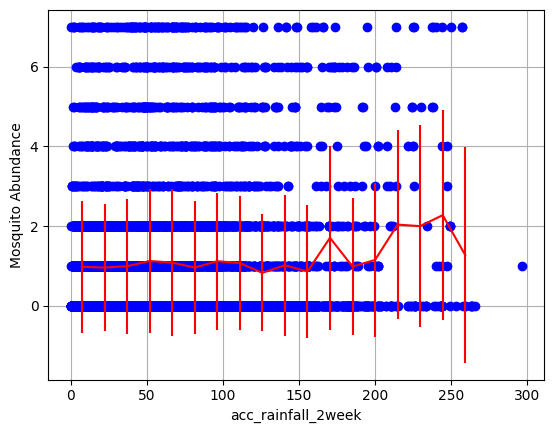

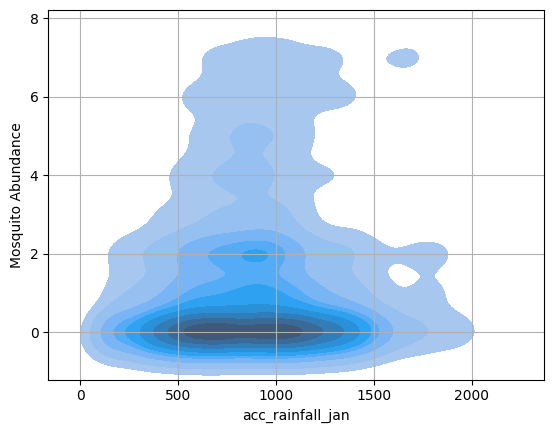

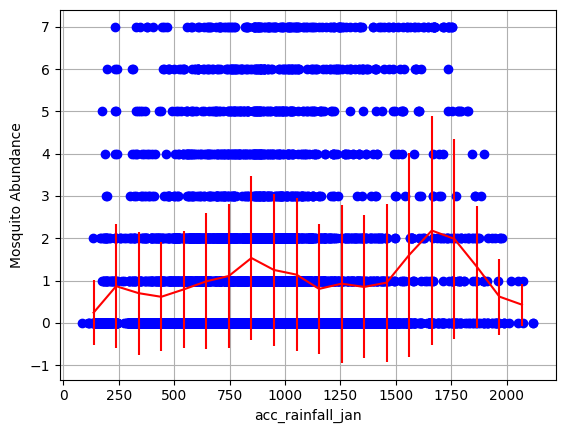

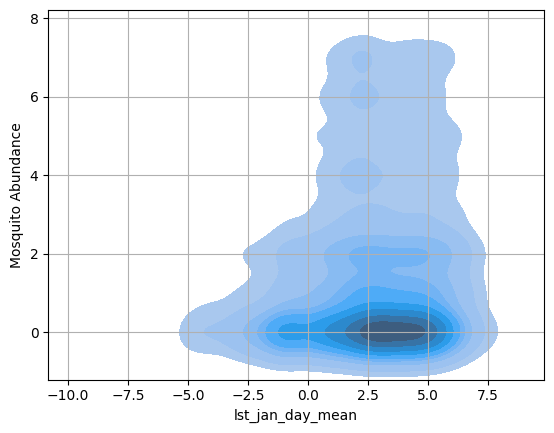

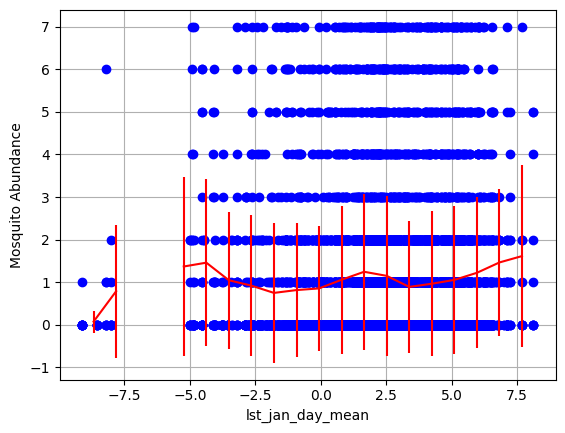

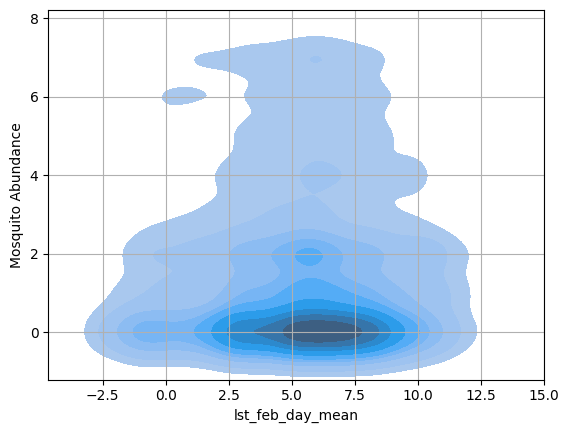

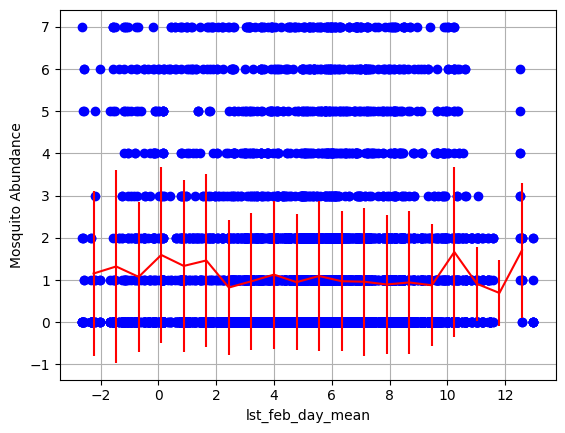

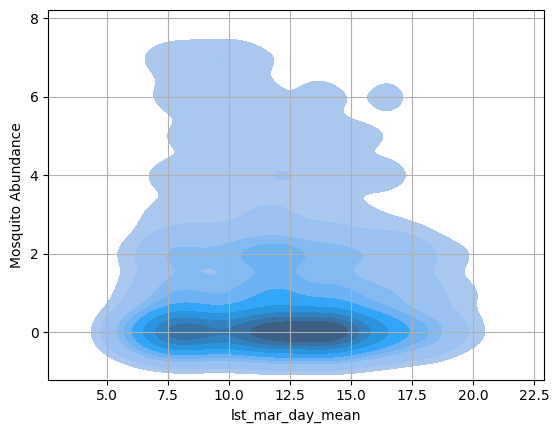

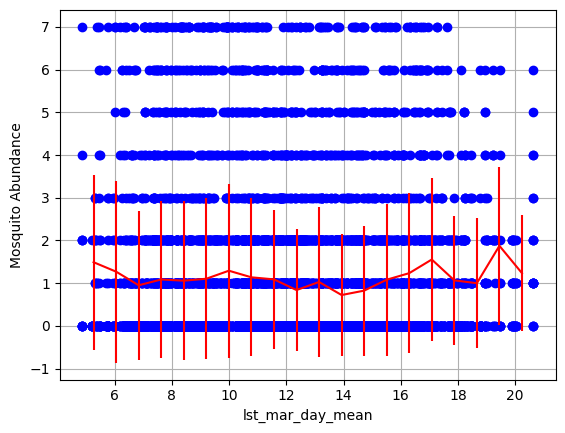

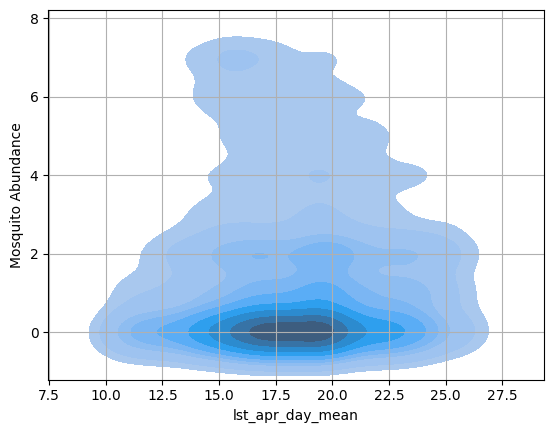

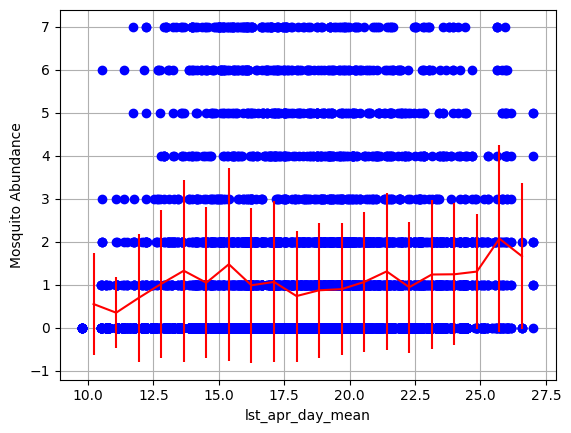

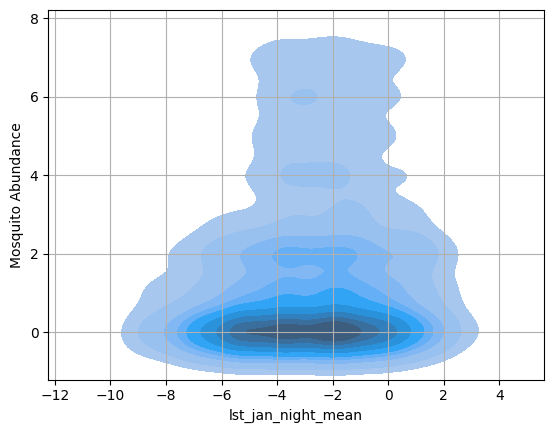

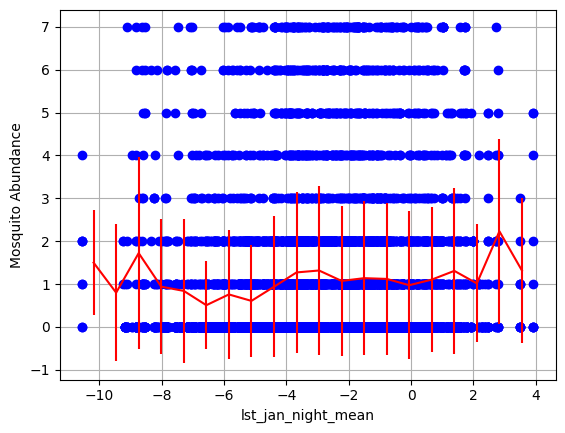

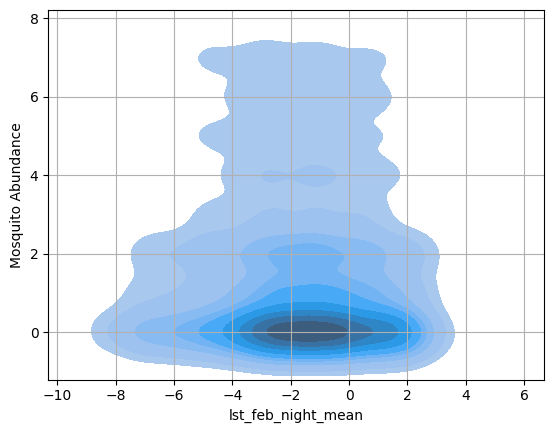

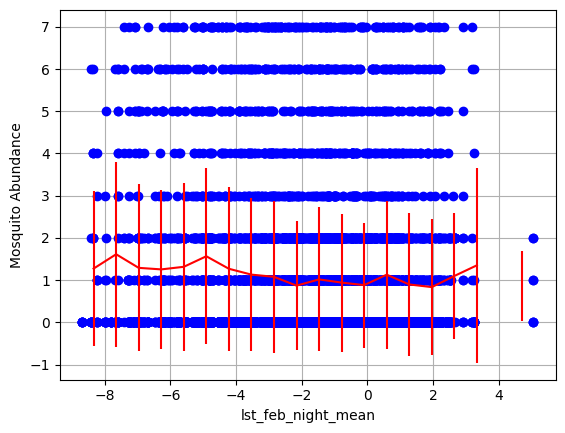

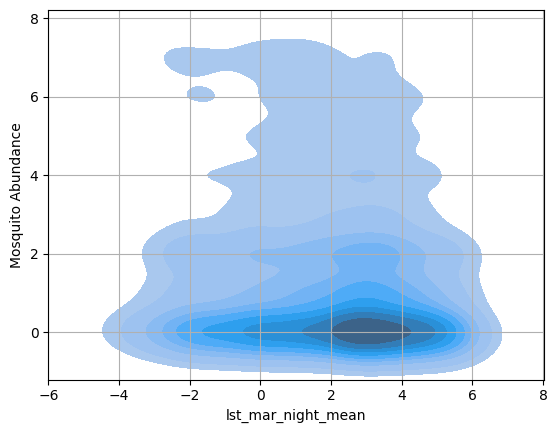

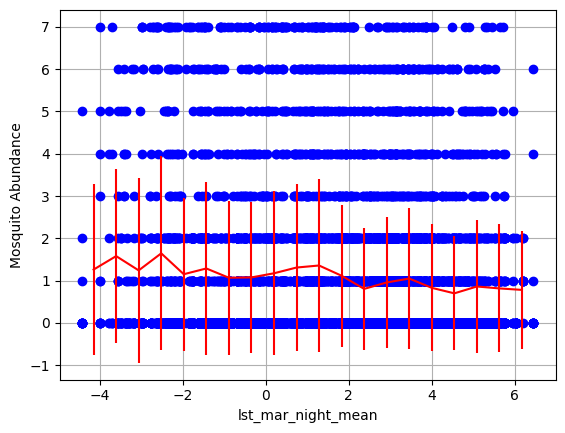

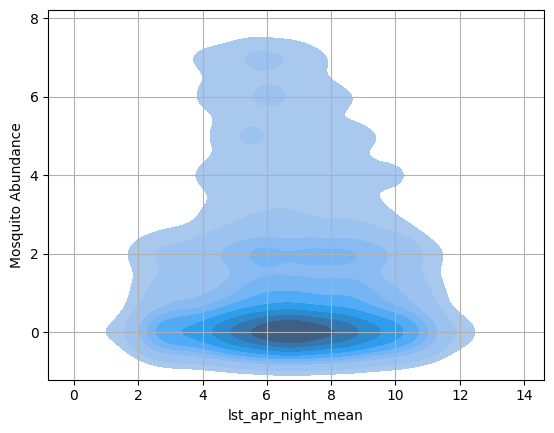

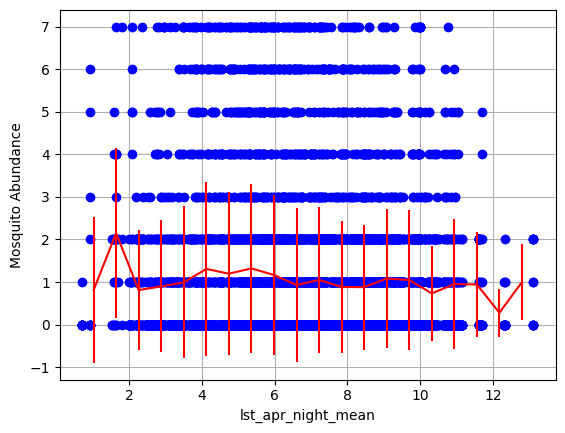

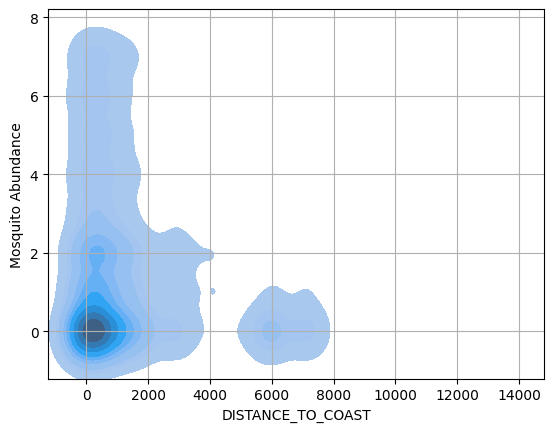

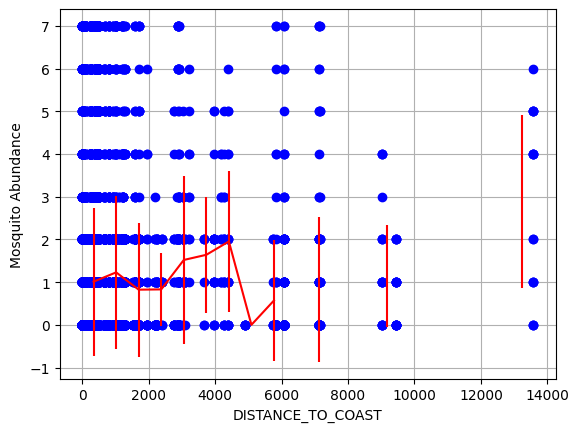

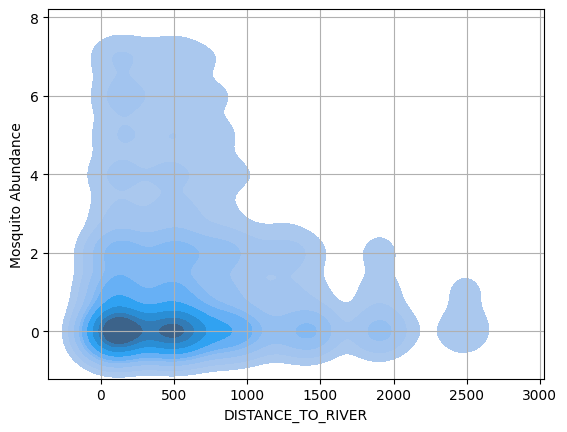

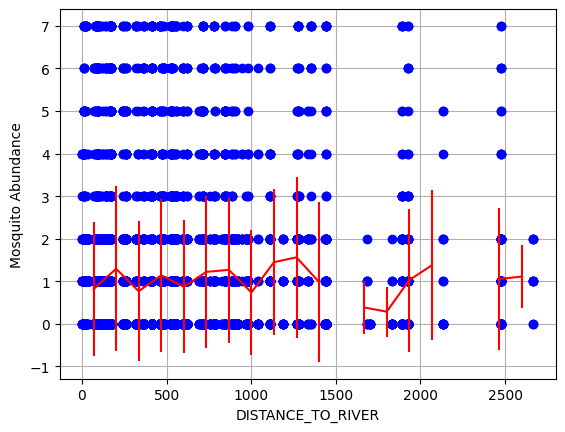

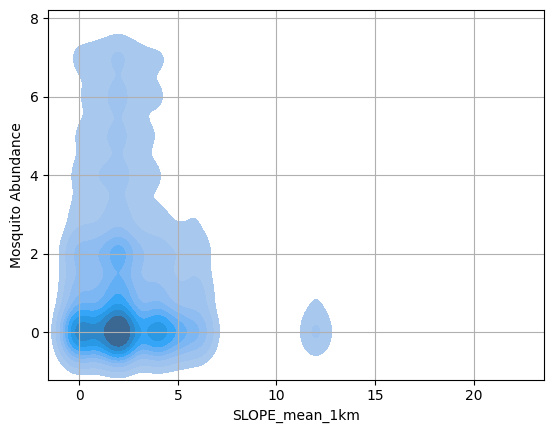

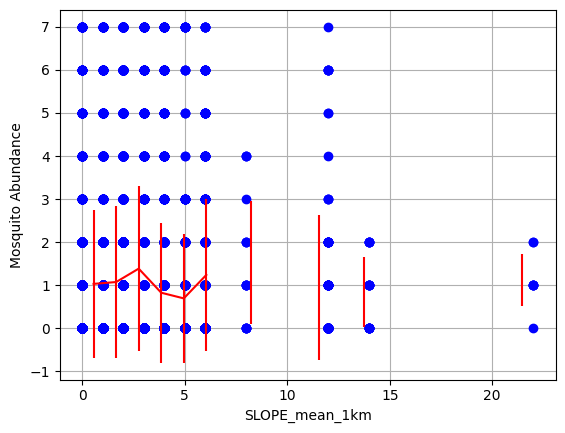

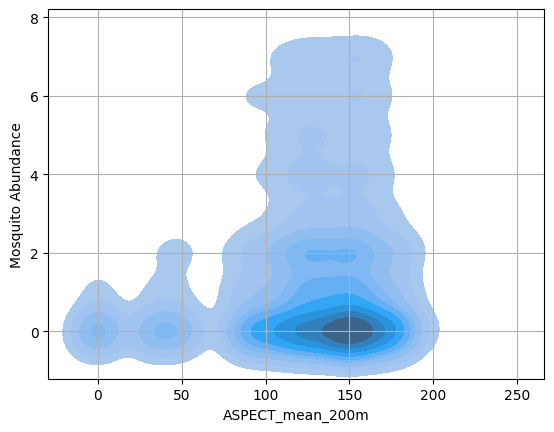

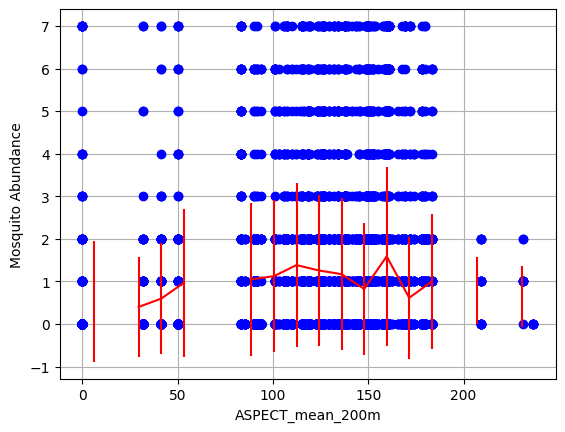

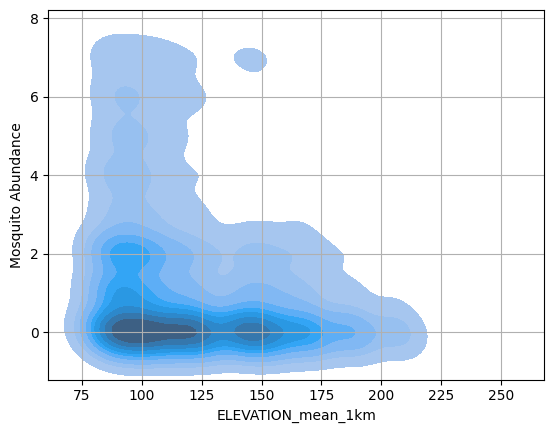

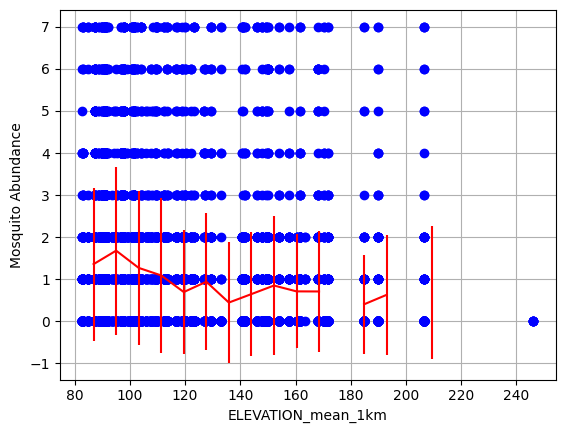

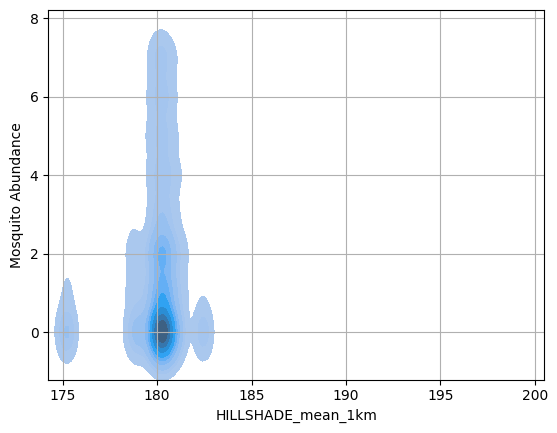

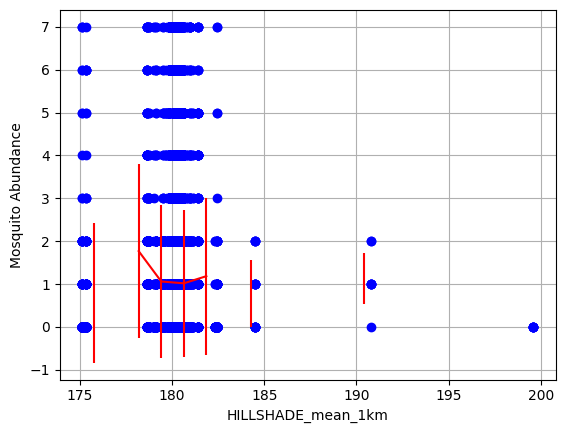

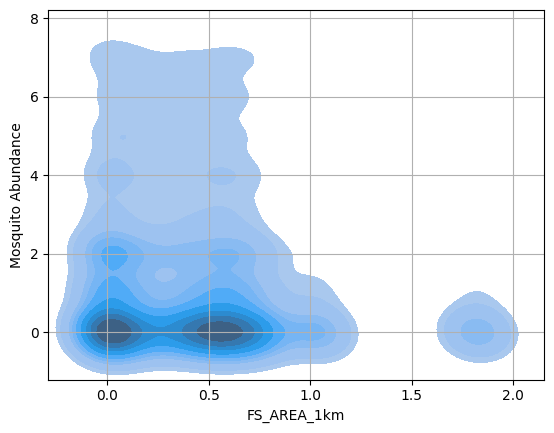

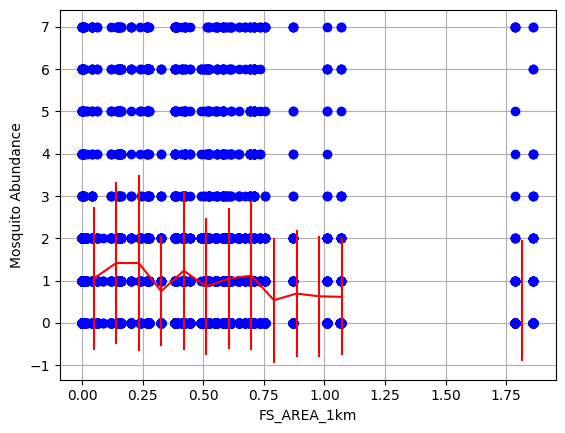

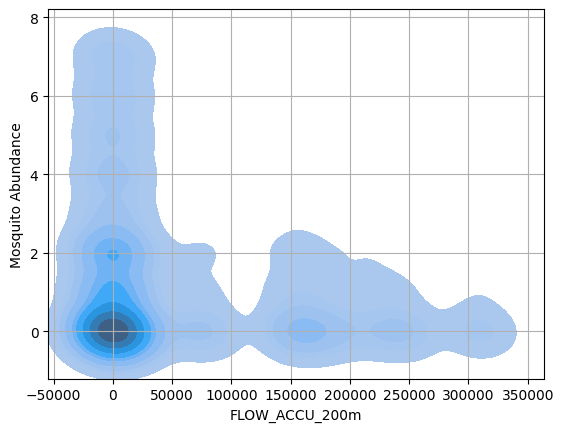

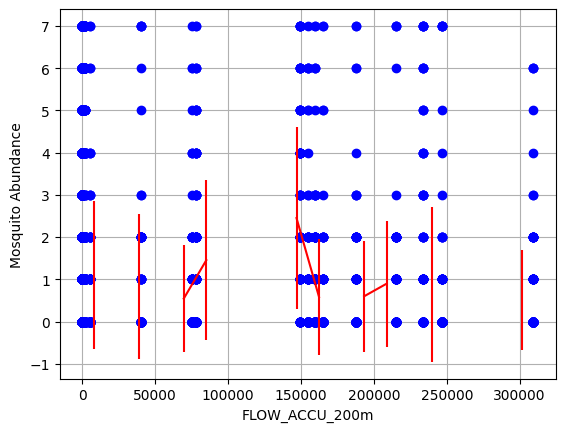

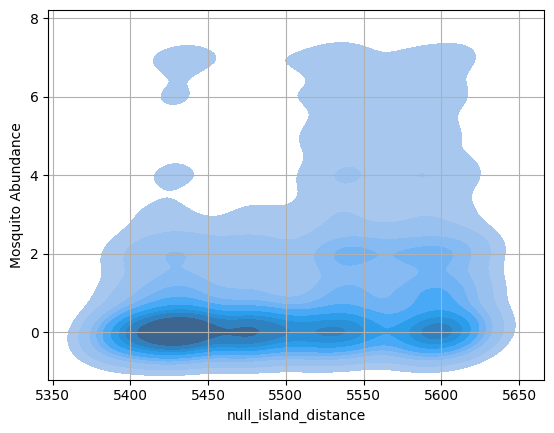

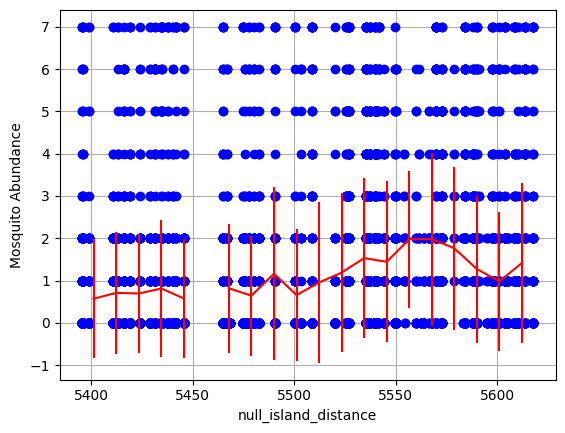

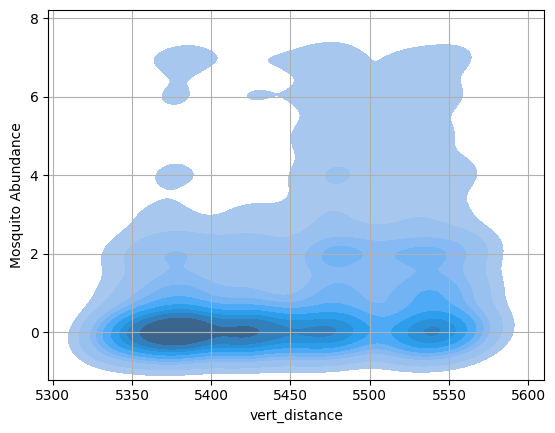

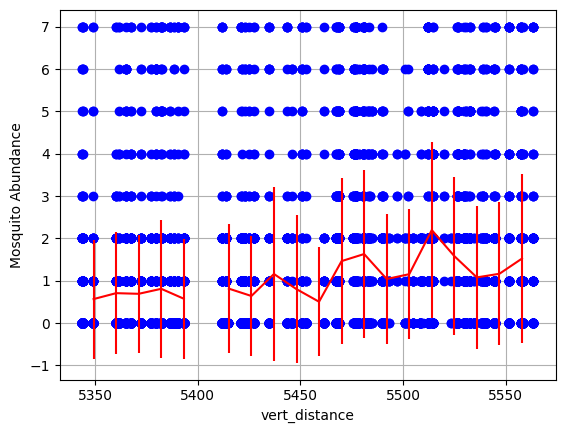

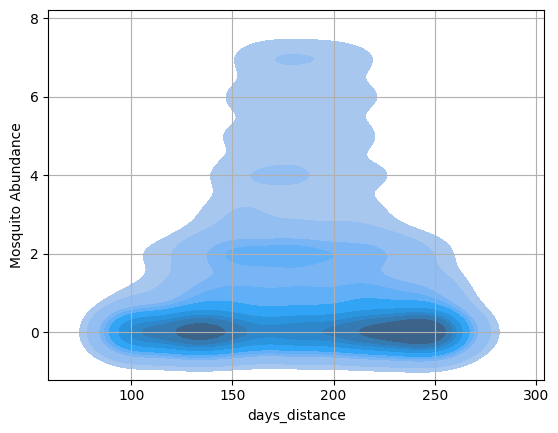

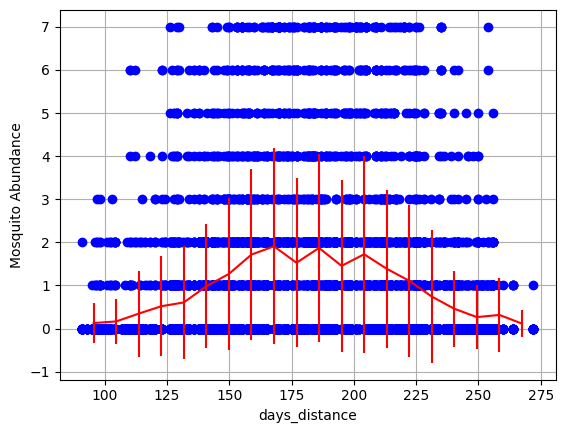

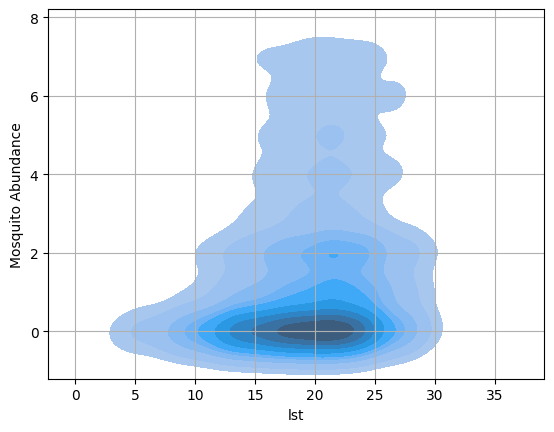

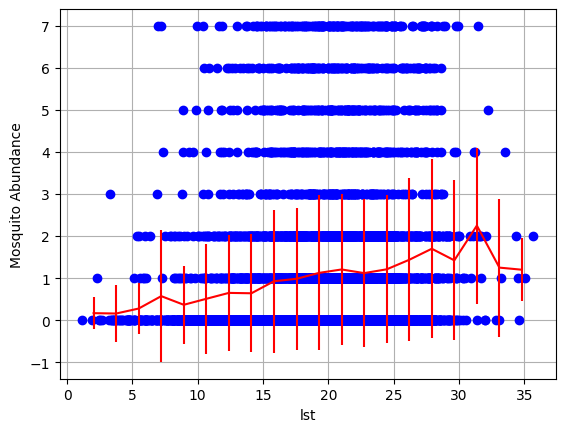

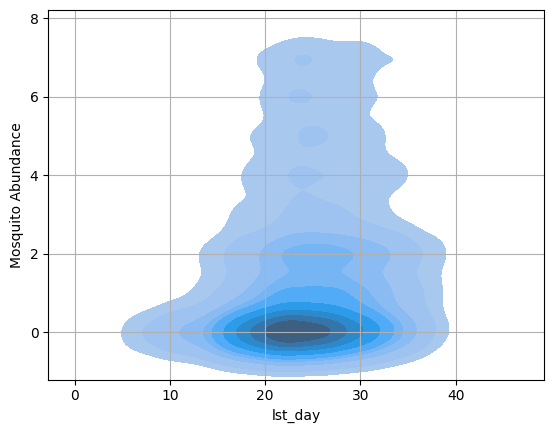

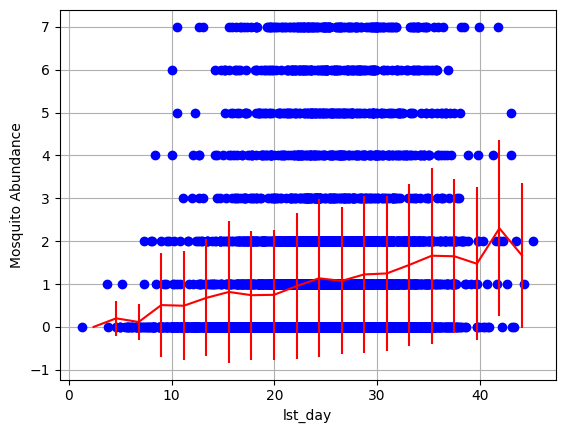

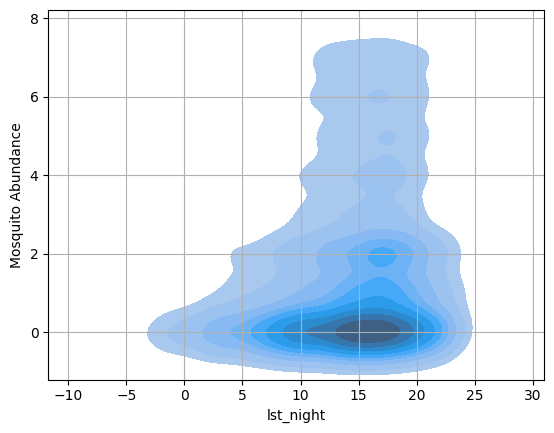

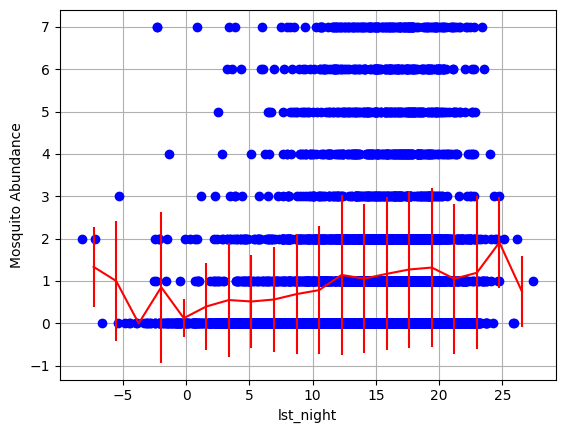

In [11]:
statistics(data)

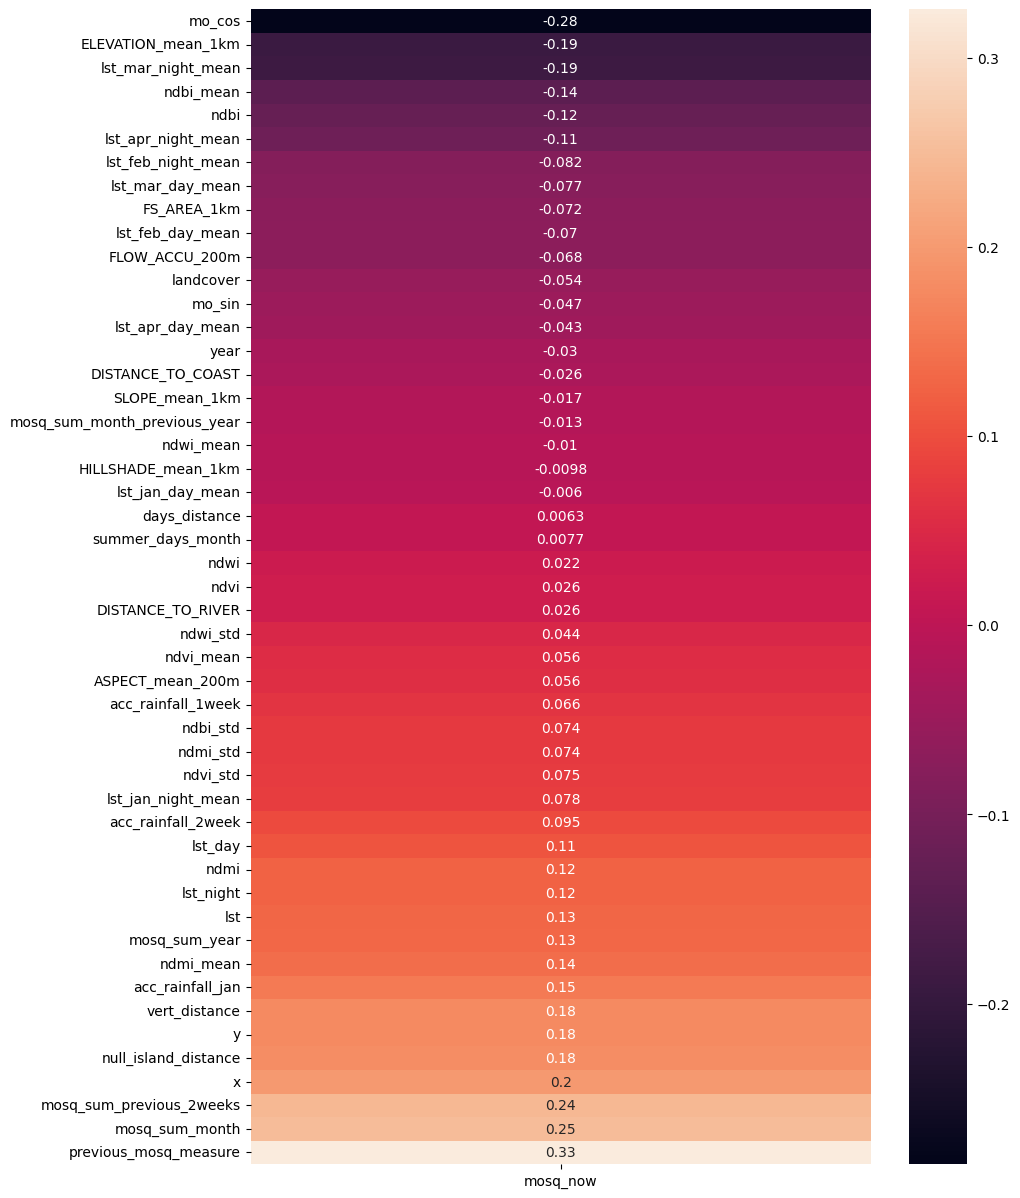

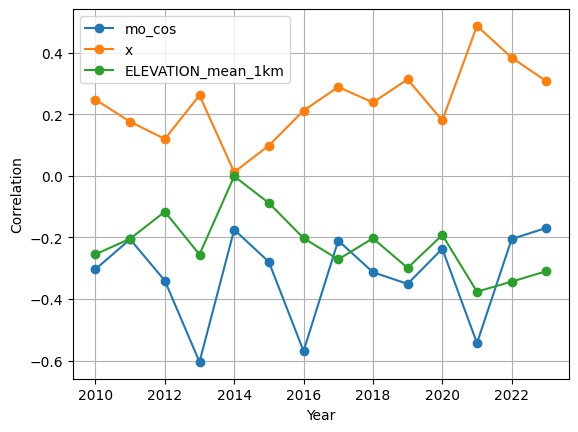

In [12]:
plot_correlations(data)

In [6]:
data = initializer(data, model_type, [-1,   1.,  3.,  8.,  11., 16., 23., 37., 78., 206., np.inf], dropna=False)

Bounds: [ -1.   1.   3.   8.  11.  16.  23.  37.  78. 206.  inf]


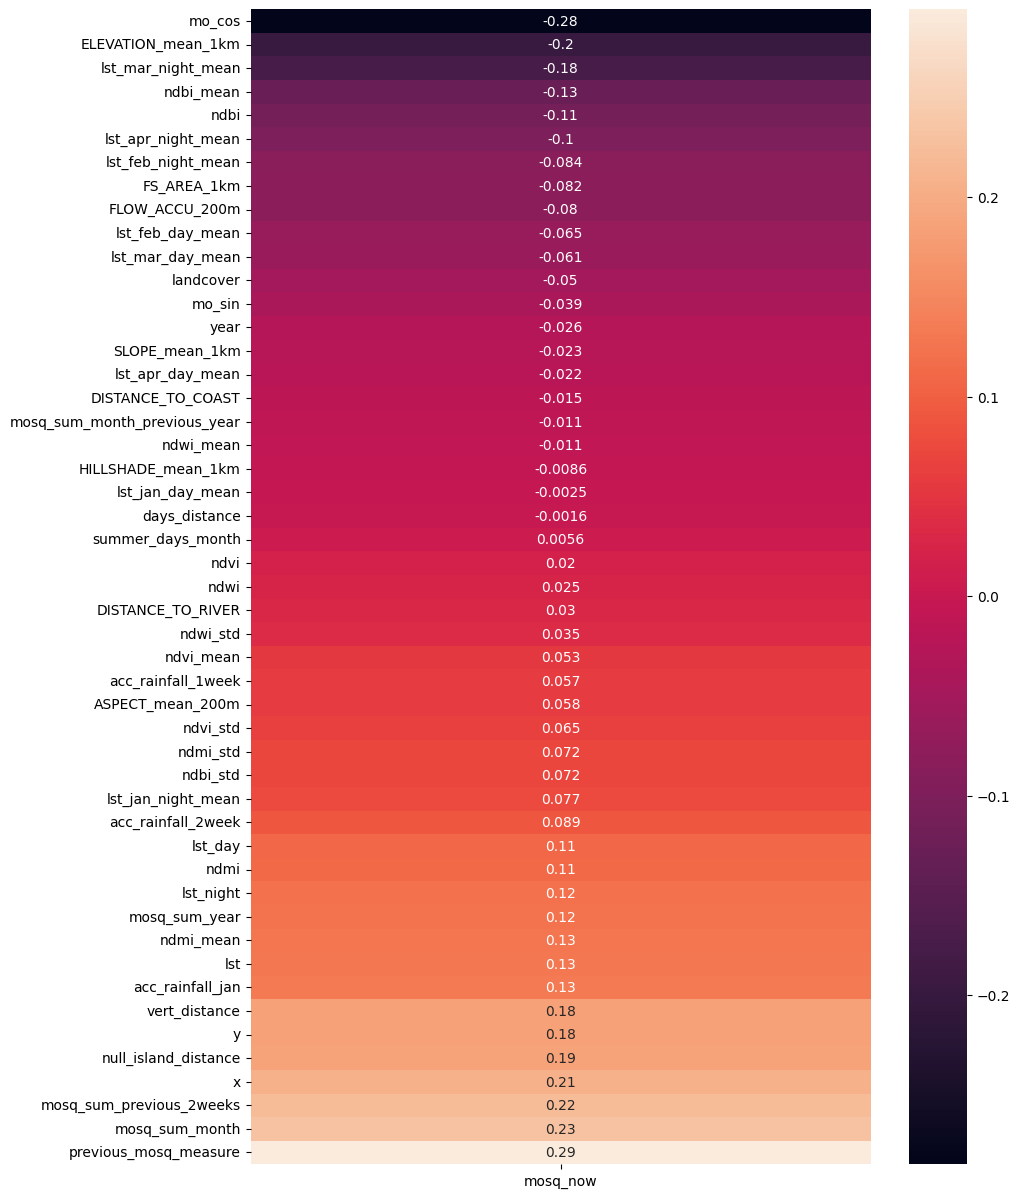

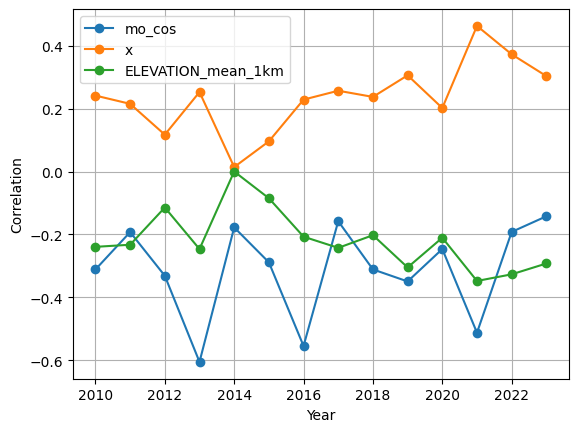

In [14]:
plot_correlations(data)

In [13]:
data['mosq_now'].value_counts().sort_index()

mosq_now
0.0    3839
1.0     887
2.0     811
3.0     183
4.0     193
5.0     156
6.0     156
7.0     159
8.0     160
9.0     180
Name: count, dtype: int64

#===========================================
Predictions without entomological features
#===========================================



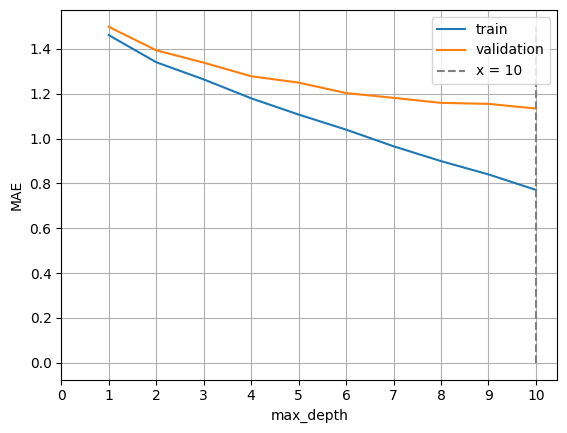

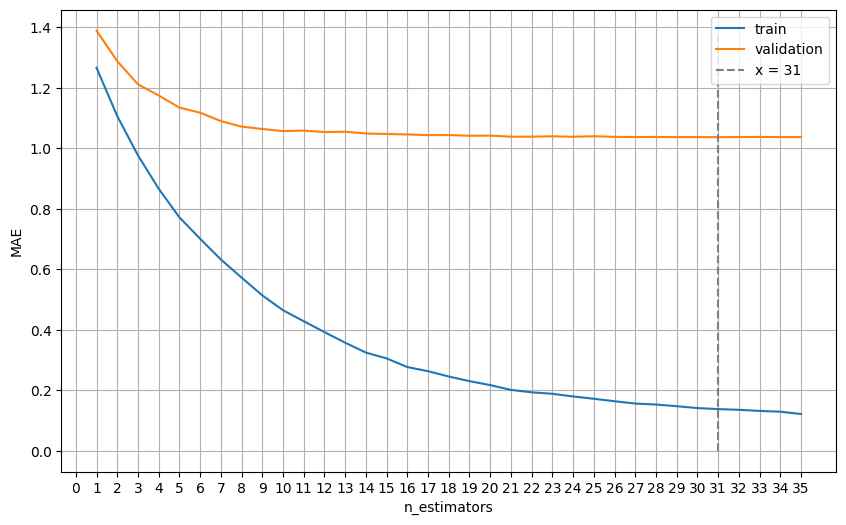

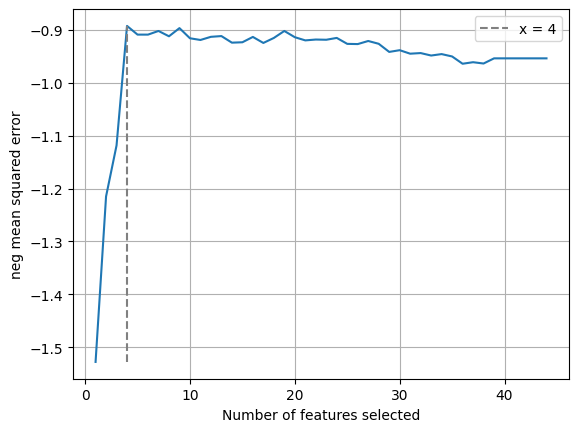

max_depth:  10
Number of estimators:  31
Selected_features:  Index(['null_island_distance', 'days_distance', 'mo_cos', 'year'], dtype='object')
prediction
0.0    48
1.0     5
2.0     5
3.0     1
Name: count, dtype: int64

Low risk category stations: 53
Medium risk category stations: 6
High risk category stations: 0
#===========================================
Predictions without entomological features
#===========================================

prediction
0.0    60
1.0    29
2.0    18
3.0     1
4.0     1
Name: count, dtype: int64

Low risk category stations: 89
Medium risk category stations: 20
High risk category stations: 0
#===========================================
Predictions with entomological features
#===========================================

prediction
0.0    1
1.0    3
Name: count, dtype: int64

Low risk category stations: 4
Medium risk category stations: 0
High risk category stations: 0


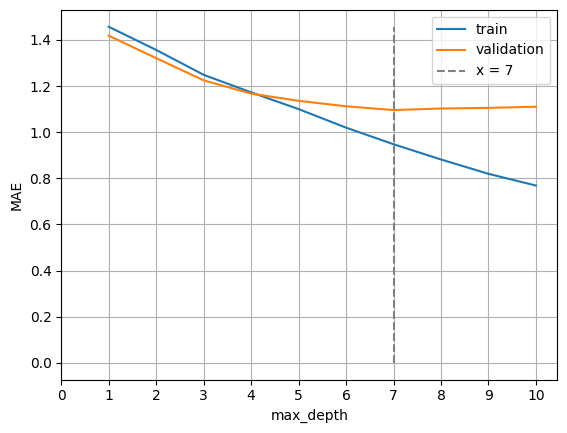

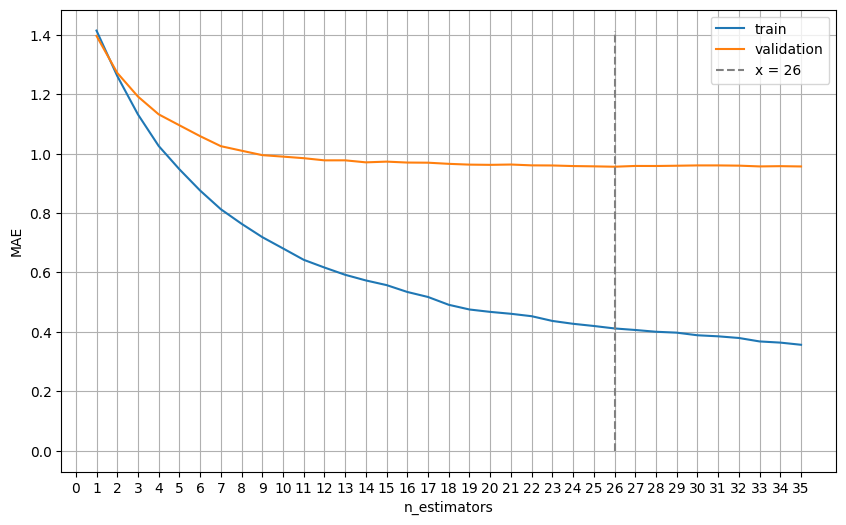

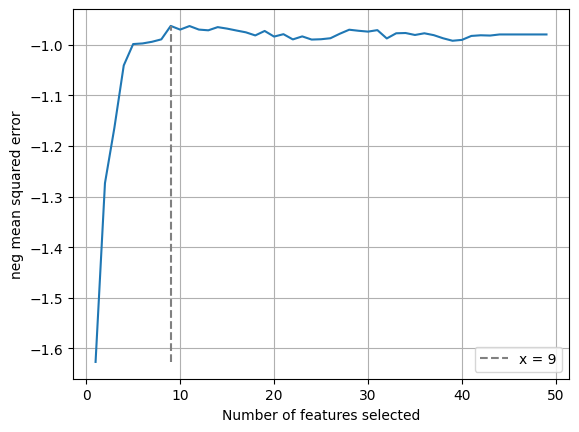

max_depth:  7
Number of estimators:  26
Selected_features:  Index(['ELEVATION_mean_1km', 'null_island_distance', 'days_distance', 'mo_cos',
       'year', 'mosq_sum_month_previous_year', 'mosq_sum_year',
       'mosq_sum_previous_2weeks', 'previous_mosq_measure'],
      dtype='object')
prediction
1.0    4
Name: count, dtype: int64

Low risk category stations: 4
Medium risk category stations: 0
High risk category stations: 0
#===========================================
Predictions without entomological features
#===========================================

prediction
0.0    18
1.0    20
2.0    42
3.0    12
4.0    11
5.0     4
6.0     2
8.0     1
Name: count, dtype: int64

Low risk category stations: 38
Medium risk category stations: 69
High risk category stations: 3
#===========================================
Predictions with entomological features
#===========================================

prediction
1.0    1
2.0    1
3.0    1
4.0    1
6.0    1
7.0    1
Name: count, dtype: int64

L

prediction
0.0    1032
1.0    2945
2.0     457
3.0     413
4.0     237
5.0     454
6.0     174
7.0       1
8.0       2
Name: count, dtype: int64

Low risk category stations: 3977
Medium risk category stations: 1561
High risk category stations: 177
#===========================================
Predictions with entomological features
#===========================================

prediction
0.0    25
1.0    30
2.0    19
3.0     2
4.0     4
Name: count, dtype: int64

Low risk category stations: 55
Medium risk category stations: 25
High risk category stations: 0
prediction
0.0    40
1.0    30
2.0     8
3.0     2
Name: count, dtype: int64

Low risk category stations: 70
Medium risk category stations: 10
High risk category stations: 0
#===========================================
Predictions without entomological features
#===========================================

prediction
-0.0    4190
 1.0    1450
 2.0     976
 3.0      60
 4.0     265
Name: count, dtype: int64

Low risk category stations

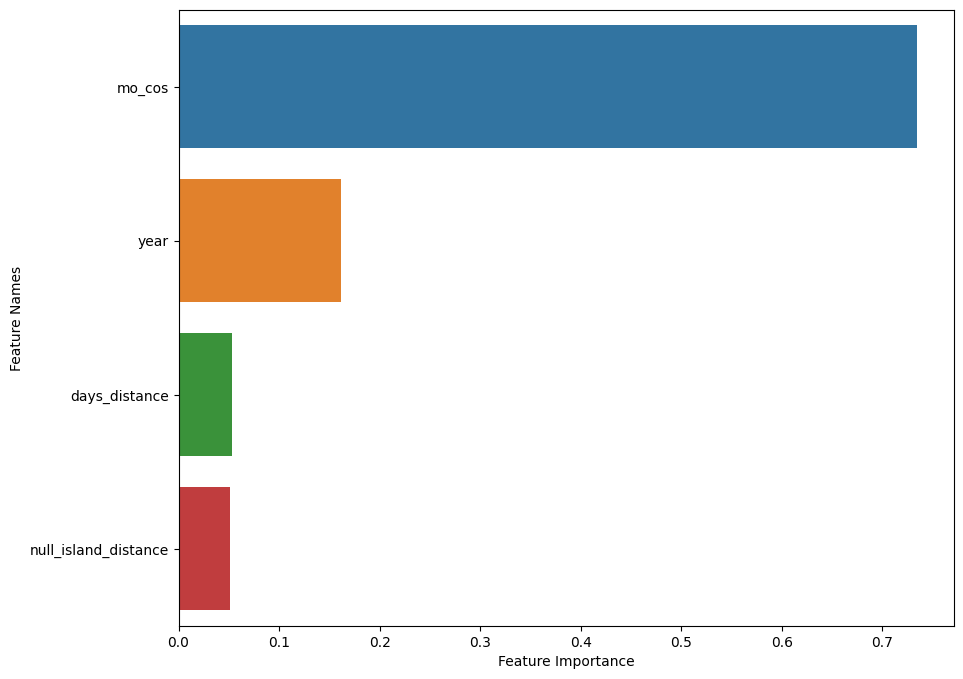

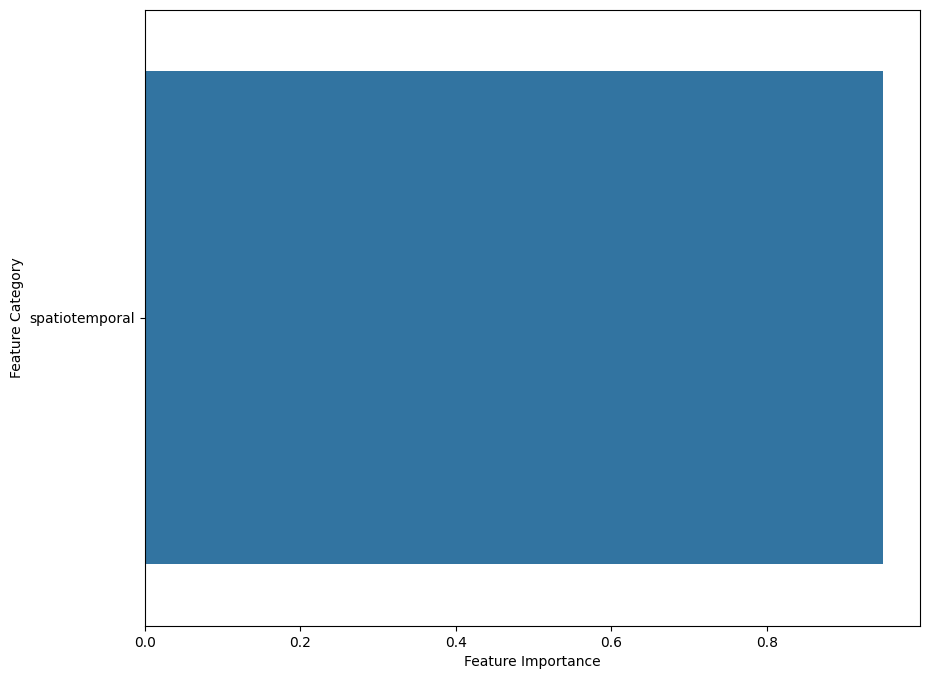

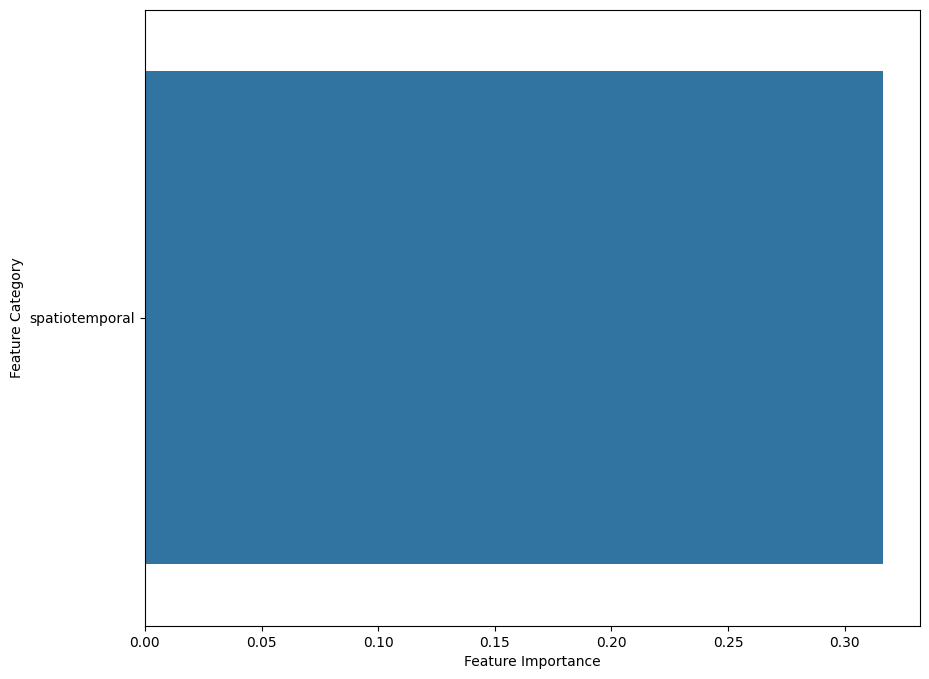

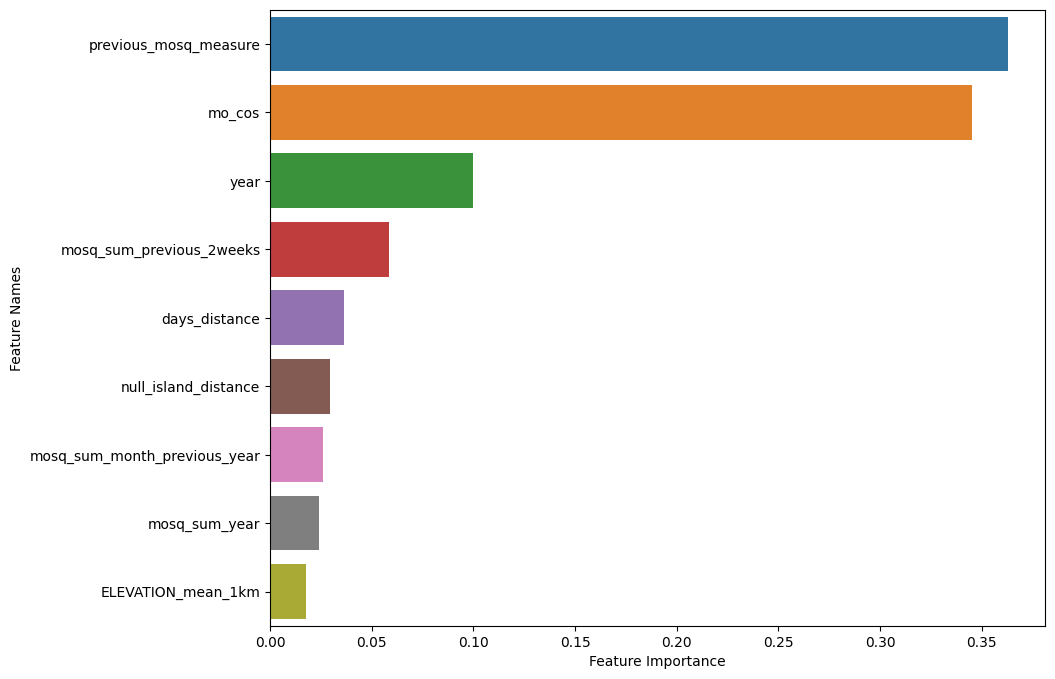

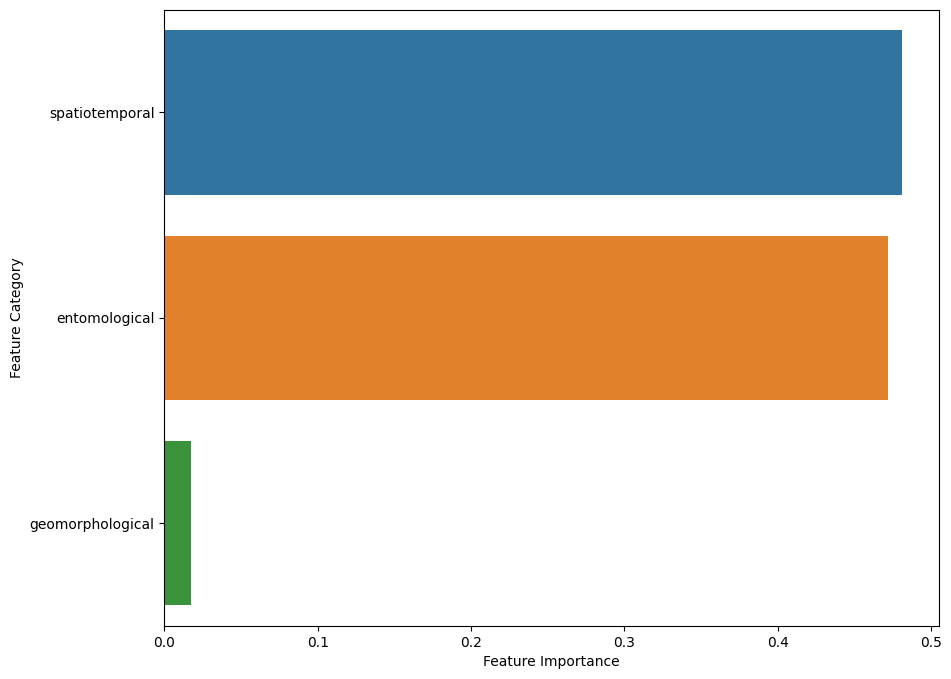

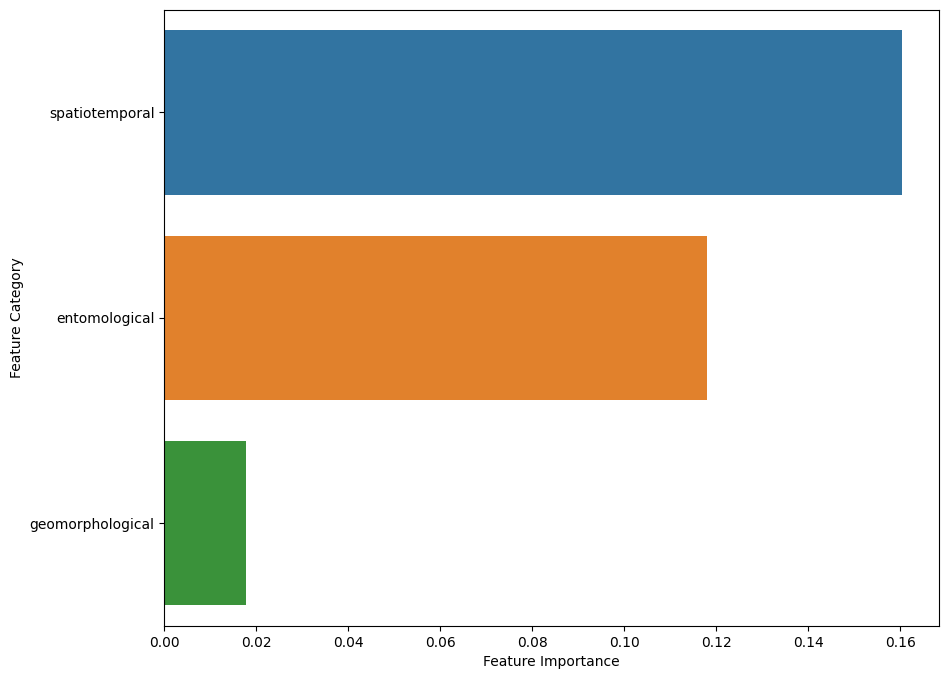

In [7]:
#=====================================================================
# Automation models without or with/without entomological data
#=====================================================================
learning_rate = 0.2
# set the early stop argument as early_stop = (tolerance, min_delta)
early_stop = None
#set the transformation actions on the data. Options are 'augmentation', 'normalization', 'log', 'scaling'
transformation_list = []
#set the data for embeddings e.g. data[['col', 'col2']]
embedded_data = None
#set the boolean for plotting feature importance
fi = False

exp=False

model_ent = Xgboost_model(model_type = model_type, learning_rate = learning_rate,
                          embedding_data = embedded_data,  transformation_list = transformation_list,
                          early_stop = False, l1_weight = 0, l2_weight = 0, weights = False)

model_env = Xgboost_model(model_type = model_type, learning_rate = learning_rate,
                          embedding_data = embedded_data,  transformation_list = transformation_list,
                          early_stop = False, l1_weight = 0, l2_weight = 0, weights = False)

predictions = pd.DataFrame()
ent_predictions_env_model = pd.DataFrame()

date = '2021-01-01'
months = data.loc[data['dt_placement']>=pd.to_datetime(date),'dt_placement'].dt.to_period('M').unique()
months = months.strftime('%Y-%m')
months.sort()

for i in months:
    date1 = i +'-01'
    if i.split('-')[1]=='12':
        date2 = str(int(i.split('-')[0])+1) +'-01-01'
    else:
        date2 = i.split('-')[0] + '-' + str(int(i.split('-')[1]) + 1) + '-01'
        
    train = data.loc[data[date_col] < pd.to_datetime(date1)]
    train = train.reset_index(drop=True)
    
    test = data.loc[data[date_col] >= pd.to_datetime(date1)]
    test = test.loc[test[date_col] < pd.to_datetime(date2)]
    test = test.reset_index(drop=True)

    # set the only_env as True if there are no mosquitoes for the forecast month
    only_env=None    
    if len(test.dropna(subset=['mosq_sum_month', 'mosq_sum_month_previous_year', 'mosq_sum_year',
                               'mosq_sum_previous_2weeks','previous_mosq_measure']).drop(columns=['mosq_now']).dropna())>0:
        only_env=False
    elif len(test.drop(columns=['mosq_sum_month', 'mosq_sum_month_previous_year', 'mosq_sum_year',
                               'mosq_sum_previous_2weeks', 'previous_mosq_measure', 'mosq_now']).dropna())>0:
        only_env=True
    else:
        print('No data left for prediction')

    if only_env != None:
        # Run first without entomological features
        print("#===========================================")
        print("Predictions without entomological features")
        print("#===========================================")
        print()
        data_env = train.drop(['mosq_sum_month', 'mosq_sum_month_previous_year', 'mosq_sum_year',
                              'mosq_sum_previous_2weeks', 'previous_mosq_measure'], axis = 1)
        test_env = test.drop(['mosq_sum_month', 'mosq_sum_month_previous_year', 'mosq_sum_year',
                              'mosq_sum_previous_2weeks', 'previous_mosq_measure'], axis = 1)

        data_env = data_env.dropna().reset_index(drop=True)
        test_env = test_env.dropna(subset=test_env.columns.difference(['mosq_now'])).reset_index(drop=True)
        
        if len(test_env)!=0:
            predictions_env = give_predictions_xgboost(model_env, data_env, test_env, env = True,
                                                       filepath = path, case = '', fi = fi, export = False)
            predictions = pd.concat([predictions,predictions_env],axis=0)


        # Run with entomological features if at least one station has mosquitos number
        if not only_env:
            print("#===========================================")
            print("Predictions with entomological features")
            print("#===========================================")
            print()

            data_entom = train.dropna().reset_index(drop=True)
            test_entom = test.dropna(subset=test.columns.difference(['mosq_now'])).reset_index(drop=True)
            
            if len(test_entom)!=0:
            
                predictions2 = give_predictions_xgboost(model_env, data_entom, test_entom, env = True,
                                                        filepath = path, case = '', fi = fi, export = False)
                
                predictions_entom = give_predictions_xgboost(model_ent, data_entom, test_entom, env = False,
                                                             filepath = path, fi = fi, case = '', export = False)
                
                predictions = pd.concat([predictions,predictions_entom],axis=0)
                
                ent_predictions_env_model = pd.concat([ent_predictions_env_model,predictions2],axis=0)
                ent_predictions_env_model = pd.concat([ent_predictions_env_model,predictions_entom],axis=0)
                
model_env.plot_feature_importance()
model_ent.plot_feature_importance()

predictions = predictions.sort_values(['entomological_features'], ascending=False).reset_index(drop=True)
predictions = predictions.drop_duplicates(subset=['dt_placement', 'x', 'y'], keep='first').reset_index(drop=True)
predictions = predictions.drop_duplicates(subset=['week', 'x', 'y'], keep='first').reset_index(drop=True)

ent_predictions_env_model = ent_predictions_env_model.reset_index(drop=True)

predictions = validate_results2(predictions, data)
ent_predictions_env_model = validate_results2(ent_predictions_env_model, data)

if exp:
    csv_name =  path +'overall_predictions.csv'
    predictions.to_csv(csv_name,index=False)
    csv_name =  path +'overall_predictions_ent_with_env_model.csv'
    ent_predictions_env_model.to_csv(csv_name,index=False)

In [11]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import statsmodels.api as sm
import pandas as pd
import numpy as np
import math
import seaborn as sns
import shap

In [12]:
def shap_explanations(predictions, model):
    
    explainer = shap.TreeExplainer(model.model)
    shap_values = explainer.shap_values(predictions[model.features].dropna())
    
    plt.figure()
    shap.summary_plot(shap_values, features=predictions[model.features].dropna(), 
                          feature_names=model.features, show=False, plot_type="violin")
    plt.show()
    
    plt.figure()
    shap.summary_plot(shap_values, features=predictions[model.features].dropna(), 
                          feature_names=model.features, show=False, plot_type='bar')
    plt.show()

    months = {4:'April',
              5:'May',
              6:'June',
              7:'July',
              8:'August',
              9:'September',
              10:'October'}
    k=1
    for i in [5,6,7,8,9]:
        plt.figure()
        predictions_month = predictions[predictions['dt_placement'].dt.month==i]
        shap_values = explainer.shap_values(predictions_month[model.features].dropna())
        shap.summary_plot(shap_values, features=predictions_month[model.features].dropna(), 
                          feature_names=model.features,max_display=5,show=False, plot_type="violin")
        plt.title(months[i])
        plt.show()
        
        plt.figure()
        predictions_month = predictions[predictions['dt_placement'].dt.month==i]
        explainer = shap.TreeExplainer(model.model)
        shap_values = explainer.shap_values(predictions_month[model.features].dropna())
        shap.summary_plot(shap_values, features=predictions_month[model.features].dropna(), 
                          feature_names=model.features,max_display=5,show=False, plot_type='bar')
        plt.title(months[i])
        plt.show()
        k = k+1

    plt.figure()
    predictions_month = predictions[predictions['prediction']<=4]
    shap_values = explainer.shap_values(predictions_month[model.features].dropna())
    shap.summary_plot(shap_values, features=predictions_month[model.features].dropna(), 
                      feature_names=model.features,max_display=5, show=False, plot_type="violin")
    plt.title('Low risk observations')
    plt.show()
    
    plt.figure()
    predictions_month = predictions[predictions['prediction']<=4]
    shap_values = explainer.shap_values(predictions_month[model.features].dropna())
    shap.summary_plot(shap_values, features=predictions_month[model.features].dropna(), 
                      feature_names=model.features,max_display=5, show=False, plot_type='bar')
    plt.title('Low risk observations')
    plt.show()

    plt.figure()
    predictions_month = predictions[predictions['prediction']>=5]
    shap_values = explainer.shap_values(predictions_month[model.features].dropna())
    shap.summary_plot(shap_values, features=predictions_month[model.features].dropna(), 
                      feature_names=model.features,max_display=5, show=False, plot_type="violin")
    plt.title('High risk observations')
    plt.show()
    
    plt.figure()
    predictions_month = predictions[predictions['prediction']>=5]
    shap_values = explainer.shap_values(predictions_month[model.features].dropna())
    shap.summary_plot(shap_values, features=predictions_month[model.features].dropna(), 
                      feature_names=model.features,max_display=5, show=False, plot_type='bar')
    plt.title('High risk observations')
    plt.show()
    
    shap_values = explainer(predictions[model.features].dropna())
    for i in model.features:
        idx = np.where(predictions[model.features].columns==i)[0][0]
        x = predictions[model.features].dropna().iloc[:,idx]
        y_sv = shap_values.values[:,idx]
        lowess = sm.nonparametric.lowess(y_sv, x, frac=.6)

        _,ax = plt.subplots()
        ax.plot(*list(zip(*lowess)), color="red")
        shap.plots.scatter(shap_values[:, i], ax=ax)

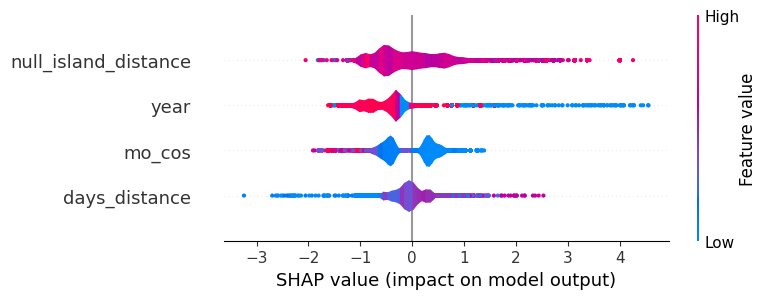

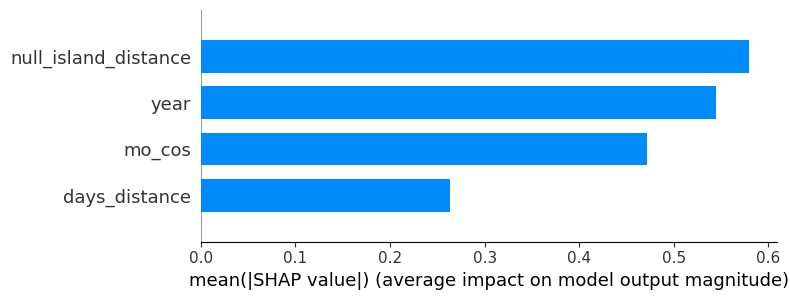

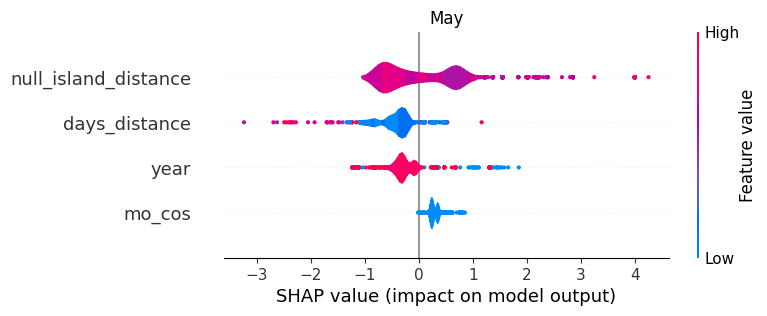

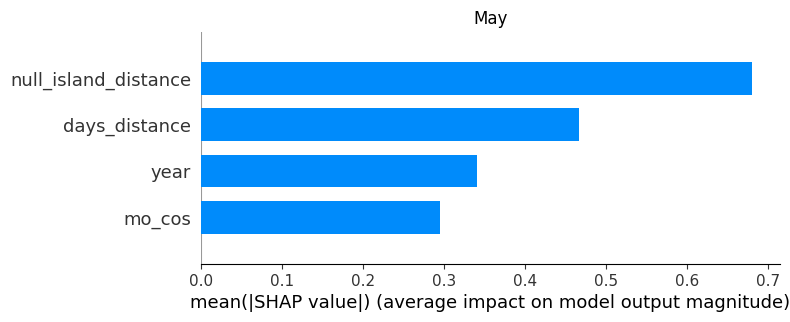

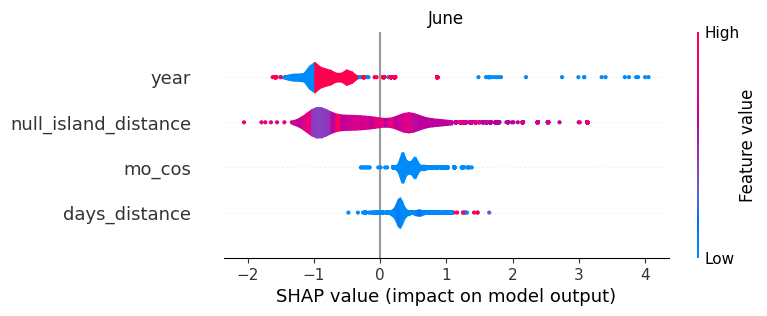

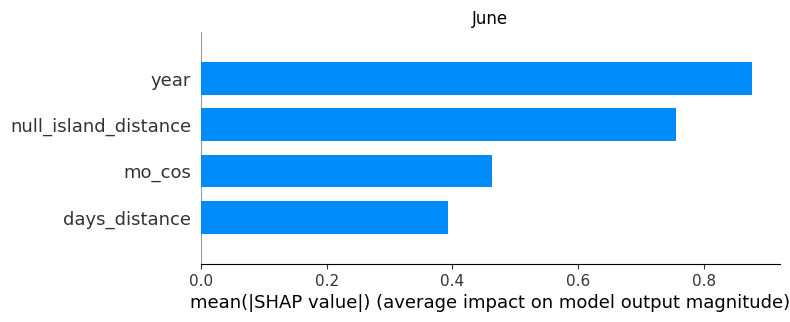

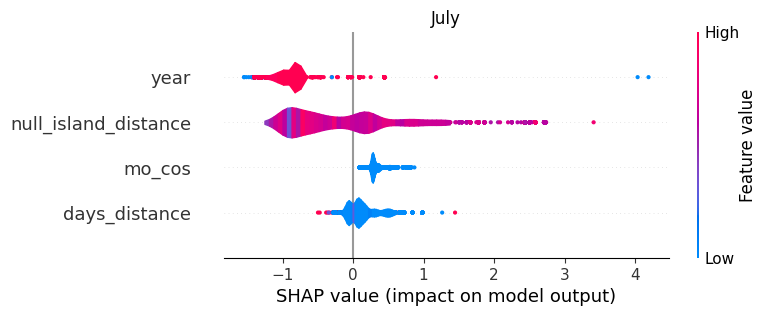

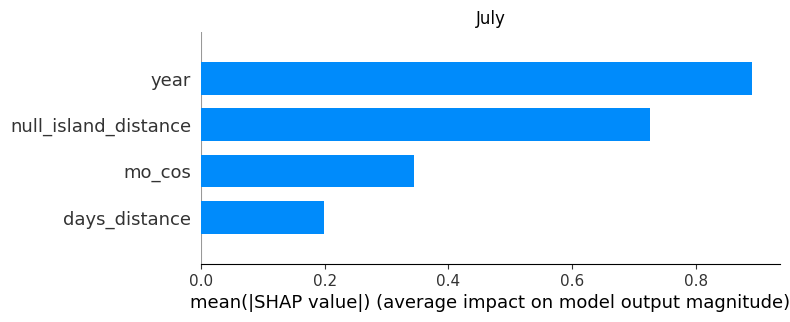

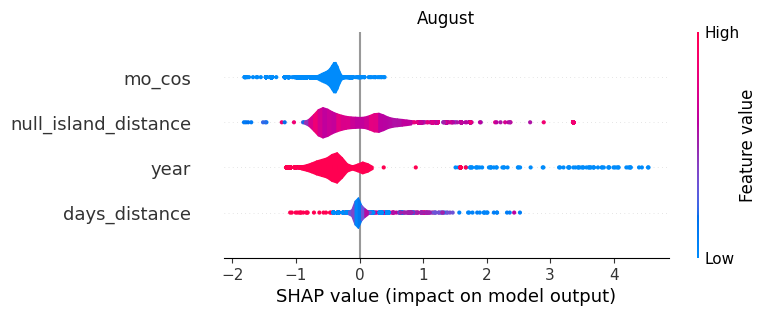

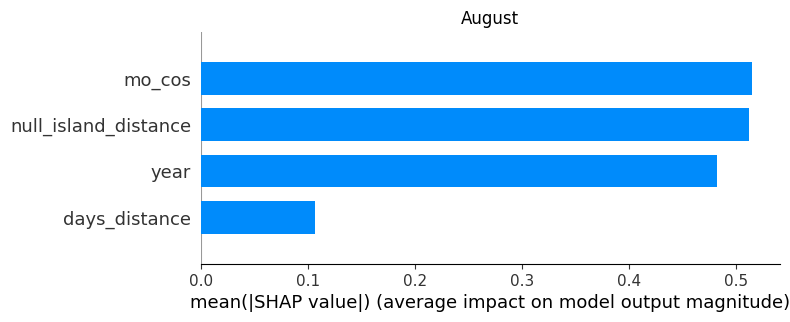

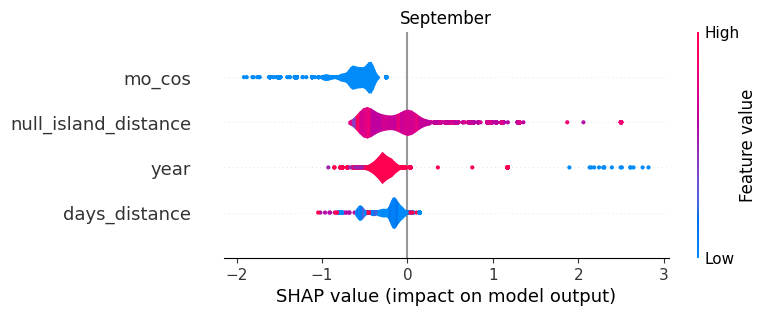

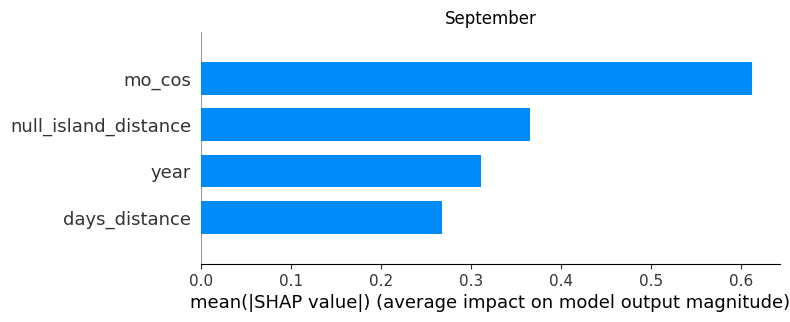

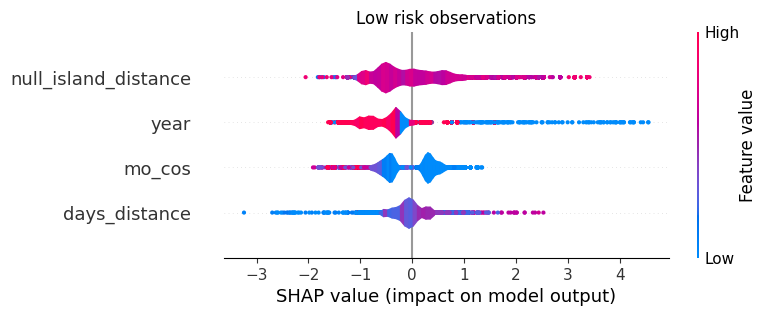

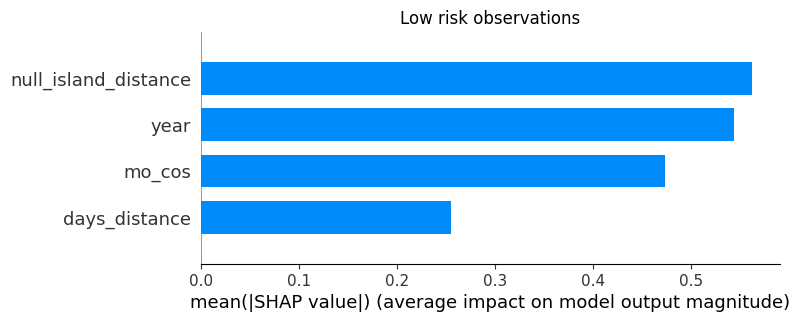

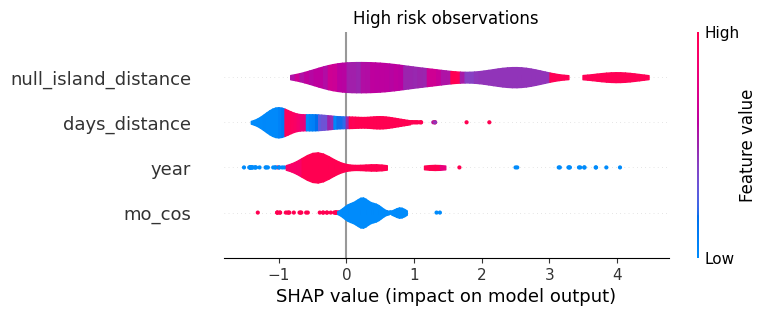

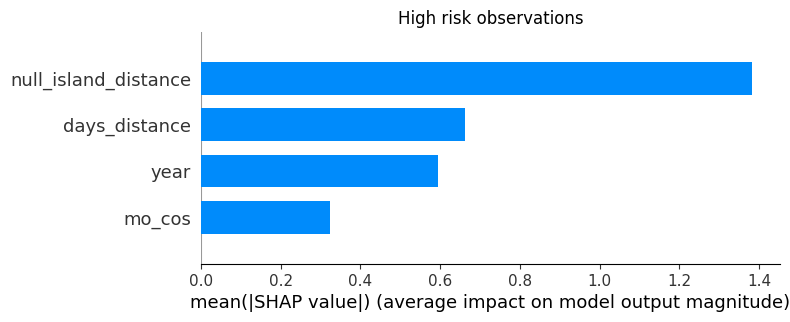

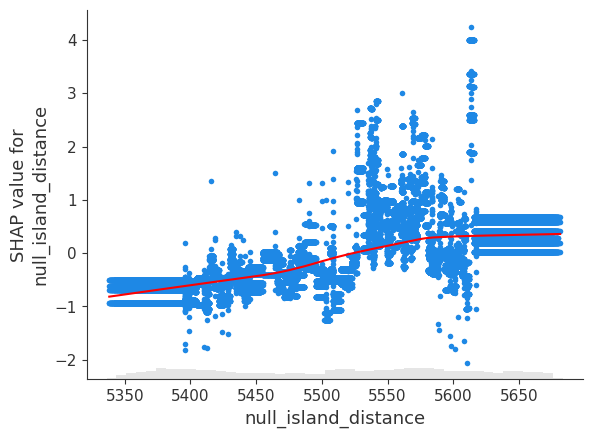

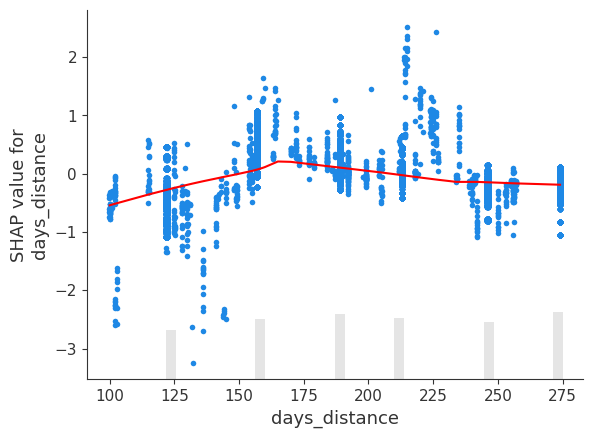

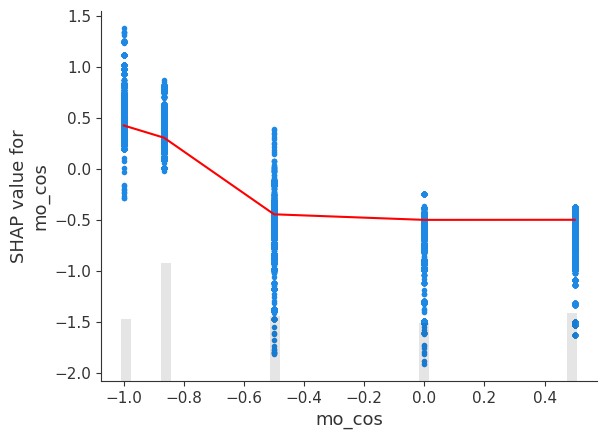

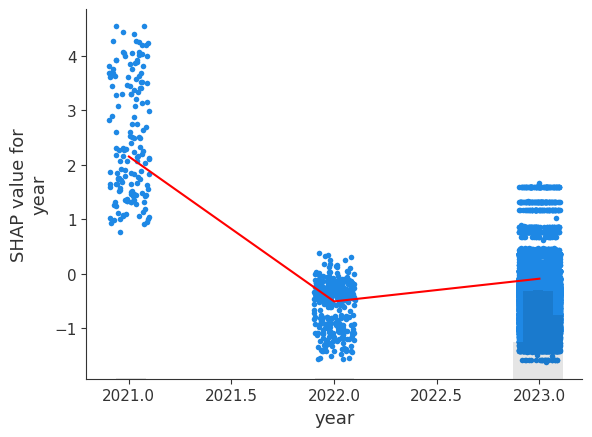

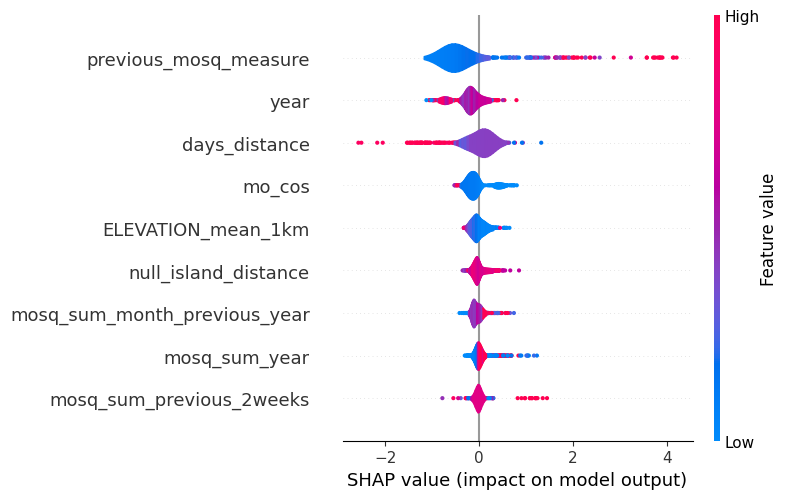

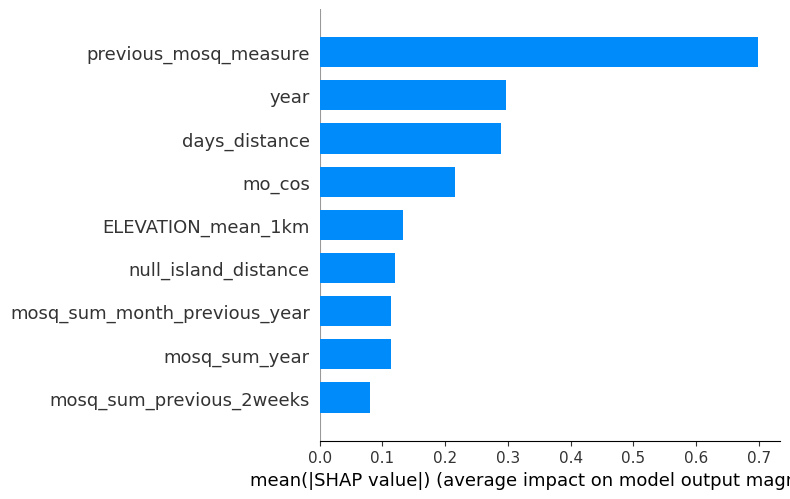

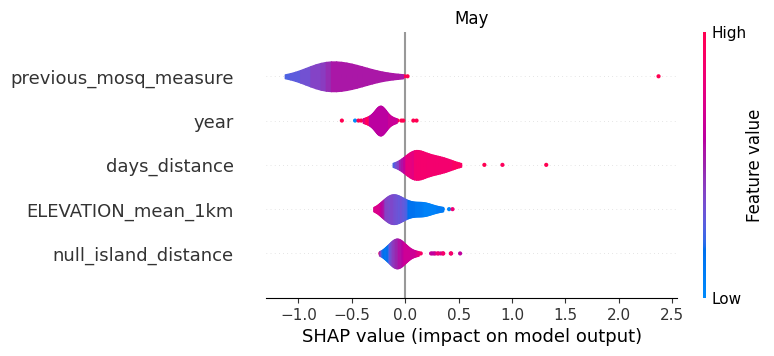

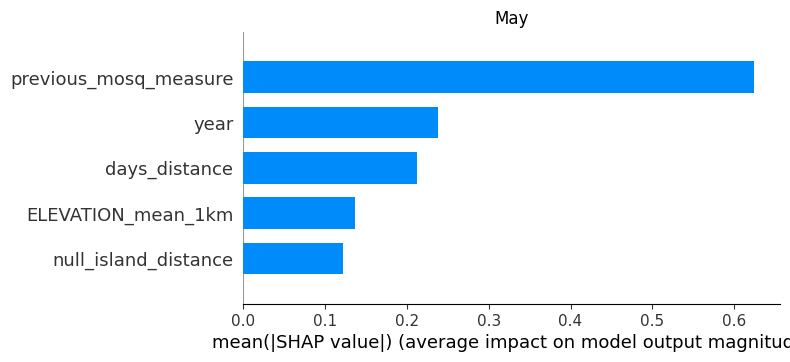

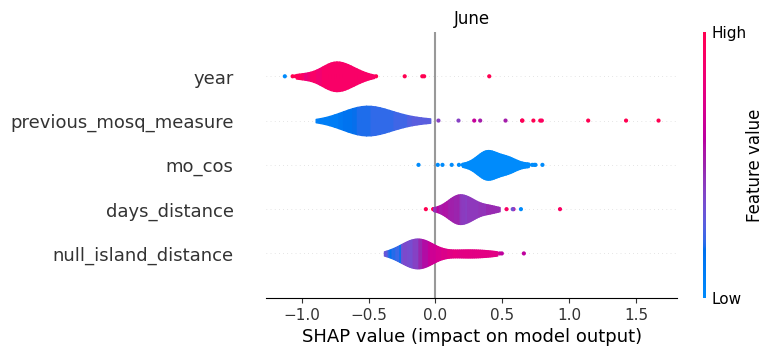

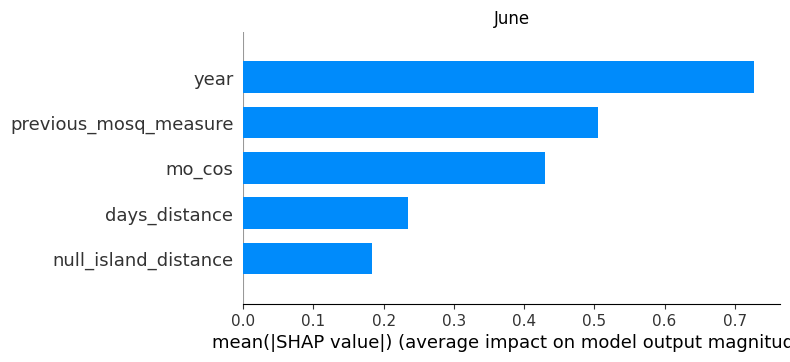

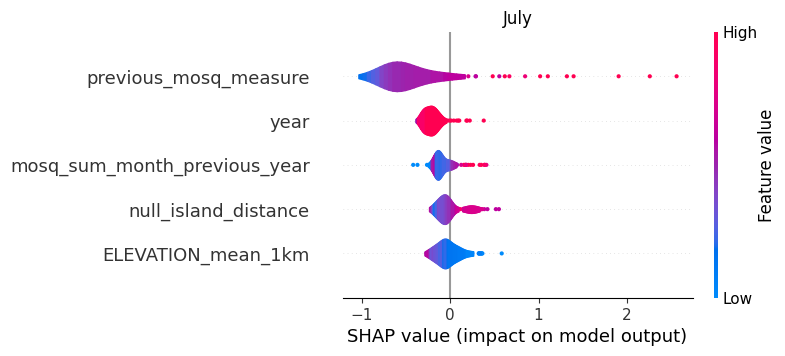

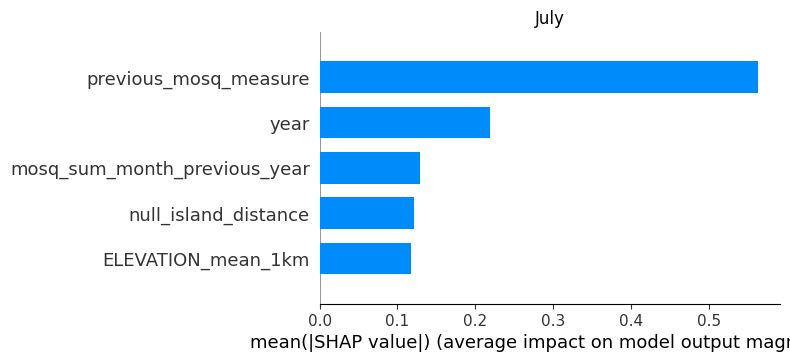

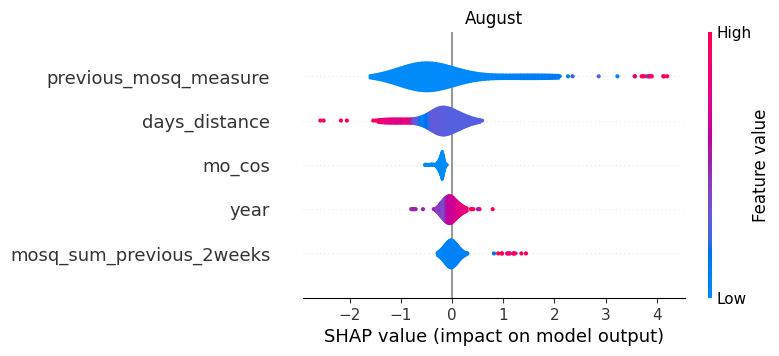

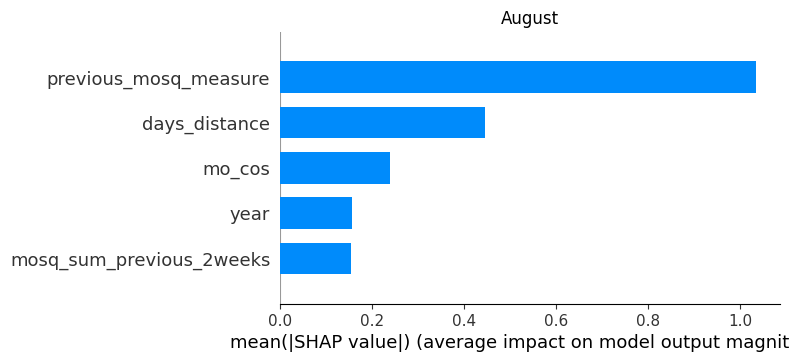

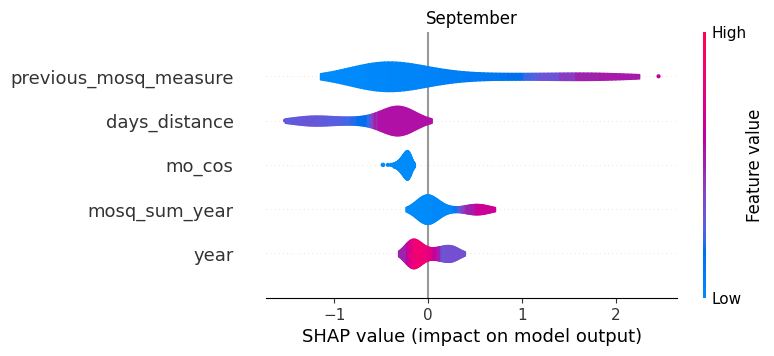

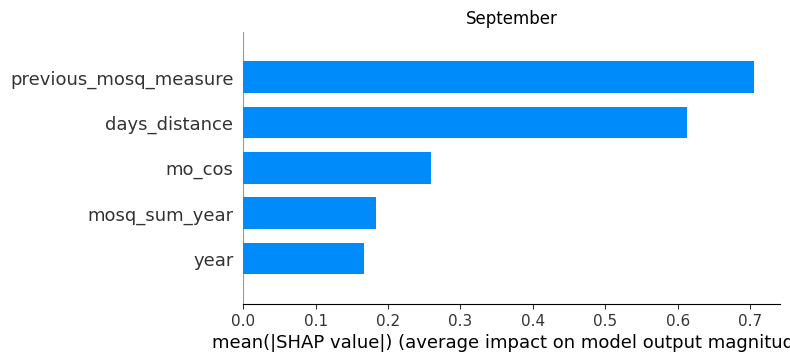

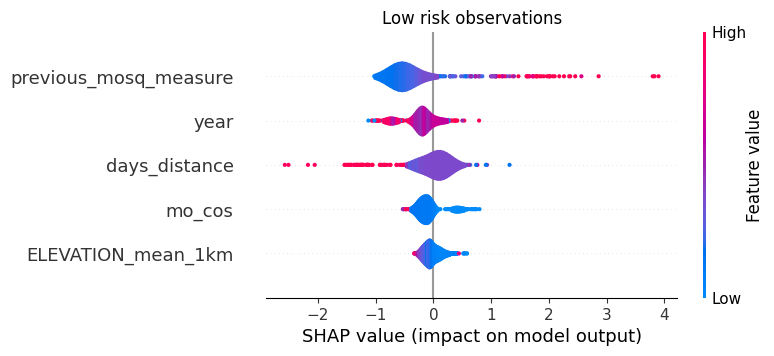

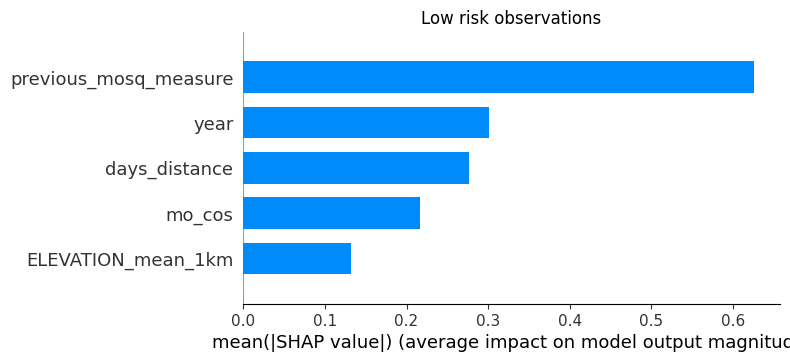

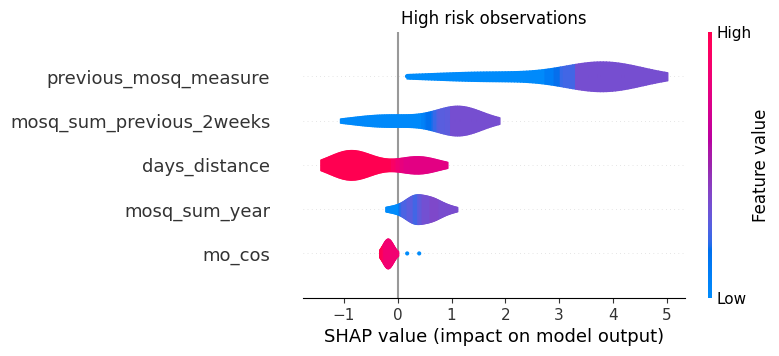

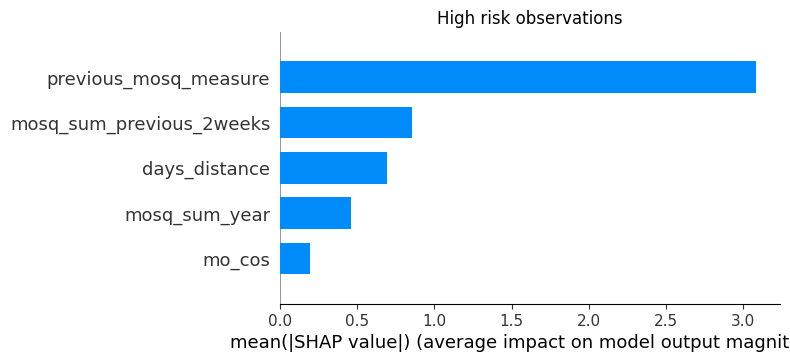

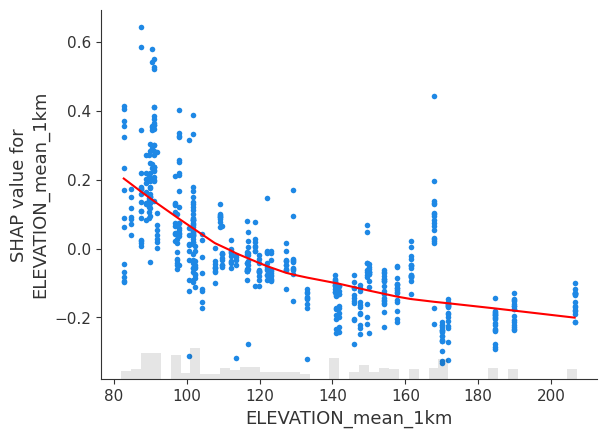

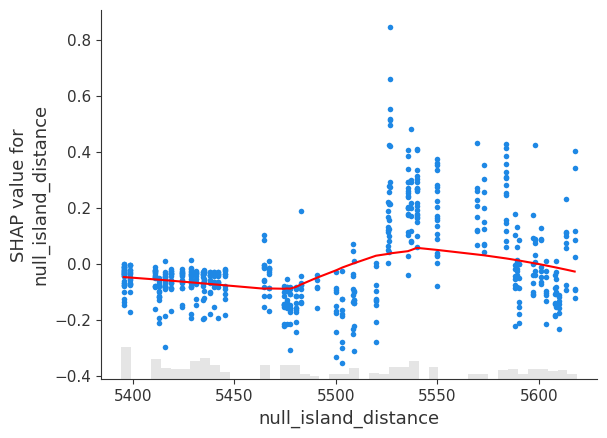

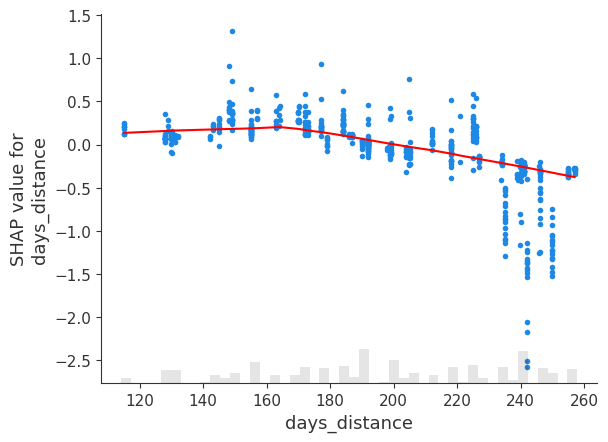

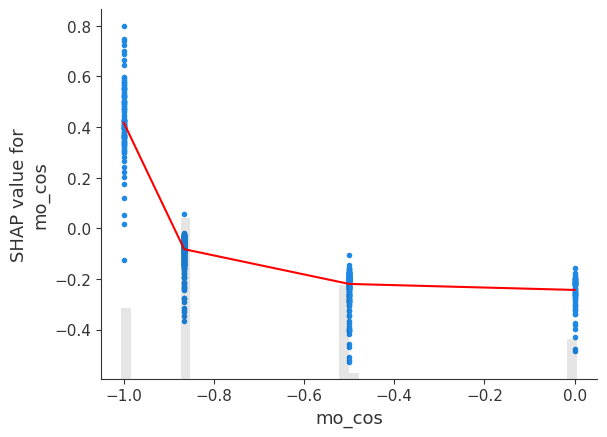

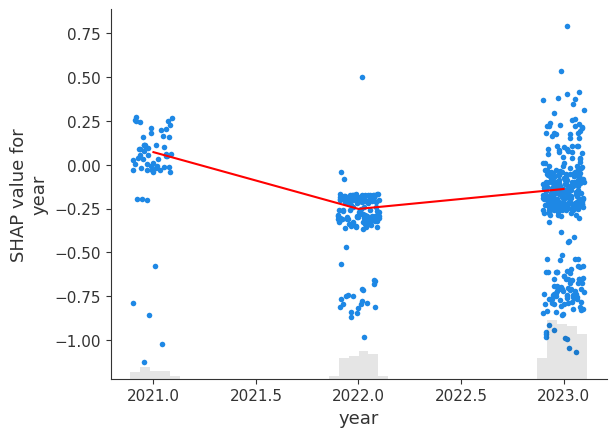

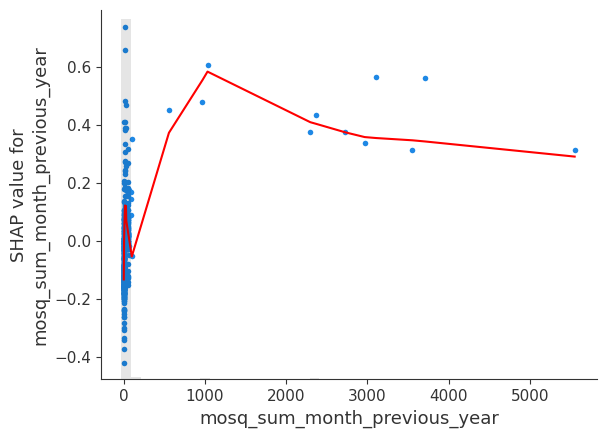

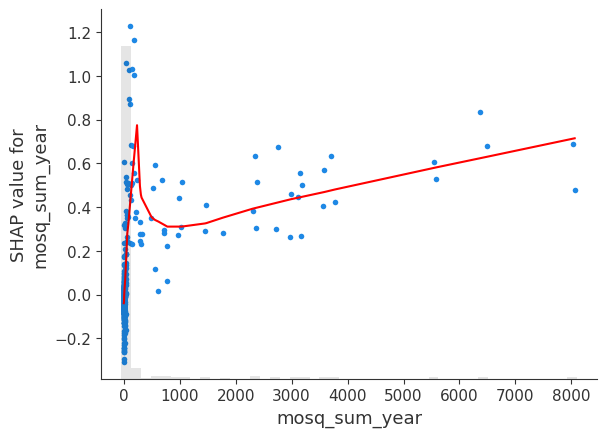

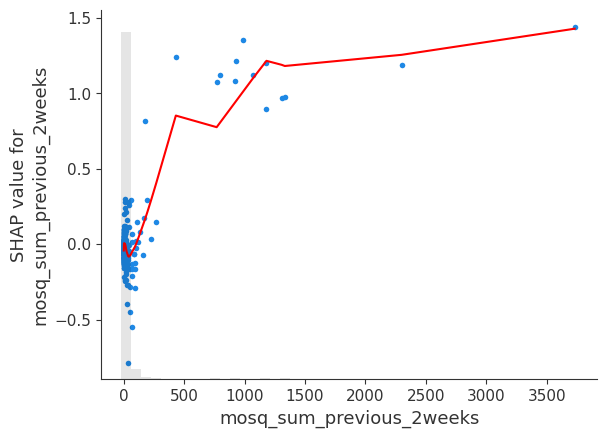

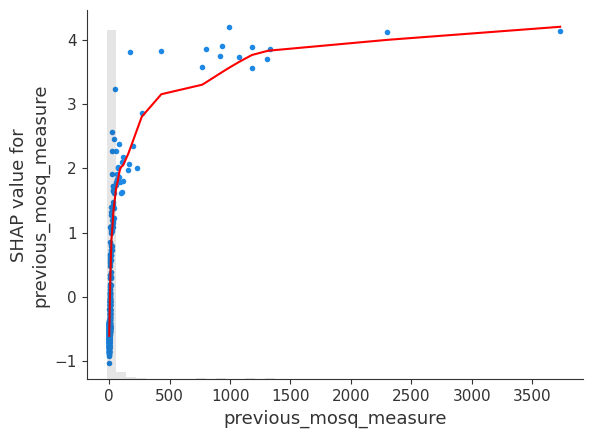

In [13]:
shap_explanations(predictions, model_env)
print('=============================')
shap_explanations(predictions, model_ent)

In [4]:
def validation_plots(path):
    csv_name =  path + 'overall_predictions.csv'
    predictions = pd.read_csv(csv_name)
    predictions['dt_placement'] = pd.to_datetime(predictions['dt_placement'], format="%Y-%m-%d")
    predictions['dt_prediction'] = pd.to_datetime(predictions['dt_prediction'], format="%Y-%m-%d")
    
    classes = list(range(10))
    q = np.array([-1,   1.,  3.,  8.,  11., 16., 23., 37., 78., 206., np.inf])
    bins, bounds = pd.cut(predictions.loc[:, 'previous_mosq_measure'], bins=q, retbins=True, labels=classes)
    predictions['previous_mosq_measure'] = bins
    predictions['previous_mosq_measure'] = predictions['previous_mosq_measure'].cat.codes.astype(int)
    predictions['previous_mosq_measure'] = predictions['previous_mosq_measure'].replace(-1,np.NaN)
    
    predictions['error'] = predictions['prediction'] - predictions['actual']
    predictions['abs_error'] = np.abs(predictions['error'])
    predictions['error_prev_actual'] = predictions['actual'] - predictions['previous_mosq_measure']
    predictions['abs_error_prev_actual'] = np.abs(predictions['error_prev_actual'])
    predictions['error_prev_pred'] = predictions['prediction'] - predictions['previous_mosq_measure']
    predictions['abs_error_prev_pred'] = np.abs(predictions['error_prev_pred'])
    
    months = {4:'April',
             5:'May',
             6:'June',
             7:'July',
             8:'August',
             9:'September',
             10:'October'}
    years = predictions['dt_prediction'].dt.year.unique().tolist()
    years.sort()
    
    predictions_10_diff = predictions[np.abs(predictions['time_diff'])<10]
    predictions_10_diff_v2 = predictions_10_diff.dropna(subset=['previous_mosq_measure']).reset_index(drop=True)
    predictions_30_diff = predictions[np.abs(predictions['time_diff'])<30].reset_index(drop=True)
    predictions_mean = predictions_10_diff.groupby(predictions_10_diff.dt_prediction.dt.to_period('M')).agg('mean')
    predictions_mean.index = predictions_mean.index.to_timestamp()
    predictions_std = predictions_10_diff.groupby(predictions_10_diff.dt_prediction.dt.to_period('M')).agg('std')
    predictions_std.index = predictions_std.index.to_timestamp()
    
    bins = np.arange(len(predictions_10_diff['actual'].unique())) - 0.5
    plt.hist(predictions_10_diff['abs_error'], bins)
    plt.xticks(range(len(predictions_10_diff['actual'].unique())))
    plt.xlabel('Absolute Error')
    plt.ylabel('Frequency')
    plt.grid()
    plt.show()
    
    bins = np.arange(len(predictions_10_diff['actual'].unique())) - 0.5
    _, _, bars = plt.hist(predictions_10_diff['abs_error'], bins, density=True)
    plt.xticks(range(len(predictions_10_diff['actual'].unique())))
    plt.xlabel('Absolute Error')
    plt.ylabel('Frequency')
    plt.grid()
    plt.show()
    
    print('Error 0:', bars[0].get_height())
    print('Error 1:', bars[1].get_height())
    print('Error 0+1:', bars[0].get_height() + bars[1].get_height())
    
    plt.plot(predictions_mean.index, predictions_mean['prediction'],'-o', label='prediction')
    plt.plot(predictions_mean.index, predictions_mean['actual'],'-o', label='actual')
    plt.grid()
    plt.legend()
    plt.xticks(rotation=30)
    plt.xlabel('Year - Month')
    plt.ylabel('Mean Class')
    plt.show()
    
    labels = predictions_10_diff.loc[:,'actual'].unique().tolist()
    labels.sort()
    f = []
    length = []
    for k in labels:
        cc = predictions_10_diff.loc[predictions_10_diff['actual']==k]
        length.append(len(cc))
        actual = cc.loc[:,'actual']
        predictions = cc.loc[:,'prediction']
        mae_class = np.abs(actual - predictions).mean()
        f.append(mae_class)
    labels = [str(int(e)) for e in labels]
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.bar(labels,f)
    for i, v in enumerate(f):
        ax.text(i, v, str('%.2f'%(v)), rotation=30)
        ax.text(i, v/2,'n = '+ str(length[i]), weight="bold", ha='center', rotation=90)
    plt.xlabel('Class')
    plt.ylabel('MAE')
    plt.grid(axis='y')
    plt.show()
    
    def obj(x, a):
        return a * x
    
    freq_df = predictions_10_diff.groupby(by=['actual', 'prediction']).size().reset_index(name='frequency')
    f, ax = plt.subplots()
    points = ax.scatter(freq_df['actual'], freq_df['prediction'], c=freq_df['frequency'], cmap='Greens')
    f.colorbar(points, label='Frequency')
    popt, pcov = curve_fit(obj, predictions_10_diff['actual'], predictions_10_diff['prediction'])
    m = popt[0]
    b=0    
    plt.plot(predictions_10_diff['actual'], m*predictions_10_diff['actual'] + b,'r',label='y={:.2f}x'.format(m))
#     plt.plot([min(predictions_10_diff['actual'].min(),predictions_10_diff['prediction'].min()), max(predictions_10_diff['actual'].max(), predictions_10_diff['prediction'].max())], [min(predictions_10_diff['actual'].min(), predictions_10_diff['prediction'].min()), max(predictions_10_diff['actual'].max(), predictions_10_diff['prediction'].max())], '--', color='grey', label='y=x')
    plt.plot([0.0, 9.0], [0.0, 9.0],'--', color='grey', label='y=x')
    plt.grid()
    plt.legend()
    plt.xlabel('Actual Class')
    plt.ylabel('Predicted Class')
    plt.show()
    
    f, ax = plt.subplots(nrows=1, ncols=5,  figsize=(50, 10))
    k=1
    for i in [5,6,7,8,9]:
        plt.subplot(1, 5, k)
        month_df = predictions_10_diff[predictions_10_diff.dt_placement.dt.month==i].reset_index(drop=True)
        if len(month_df) != 0:
            freq_df = month_df.groupby(by=['prediction', 'actual']).size().reset_index(name='frequency')
            points = ax[k-1].scatter(freq_df['actual'], freq_df['prediction'],  c=freq_df['frequency'], cmap='Greens')
            f.colorbar(points, label='Frequency')
            popt, pcov = curve_fit(obj, month_df['actual'], month_df['prediction'])
            m = popt[0]
            b=0
            plt.plot([0.0, 9.0], m*pd.Series([0.0, 9.0]) + b, 'r', label='y={:.2f}x'.format(m))
#             plt.plot(month_df['actual'], m*month_df['actual'] + b, 'r', label='y={:.2f}x'.format(m))
#         plt.plot([min(month_df['actual'].min(),month_df['prediction'].min()), max(month_df['actual'].max(),month_df['prediction'].max())], [min(month_df['actual'].min(),month_df['prediction'].min()), max(month_df['actual'].max(),month_df['prediction'].max())], '--', color='grey', label='y=x')
        plt.plot([0.0, 9.0], [0.0, 9.0],'--', color='grey', label='y=x')
        plt.grid()
        plt.legend()
        plt.xlabel('Actual Class')
        plt.ylabel('Predicted Class')
        plt.title(months[i])
        k = k+1
    plt.tight_layout()
    plt.show()

    for i in years:
        predictions_year = predictions_mean[predictions_mean.index.year==i]    
        plt.plot(predictions_year.index.month, predictions_year['abs_error'],'-o',label=str(i))
    plt.grid()
    plt.legend()
    plt.xticks(list(months.keys()), rotation=30, labels = list(months.values()))
    plt.xlabel('Month')
    plt.ylabel('Mean Absolute Error')
    plt.show()
    
    for i in years:
        predictions_year = predictions_mean[predictions_mean.index.year==i]    
        plt.plot(predictions_year.index.month, predictions_year['error'],'-o',label=str(i))
    plt.grid()
    plt.legend()
    plt.xticks(list(months.keys()), rotation=30, labels = list(months.values()))
    plt.xlabel('Month')
    plt.ylabel('Mean Error')
    plt.show()
    
    for i in years:
        predictions_year = predictions_mean[predictions_mean.index.year==i]    
        plt.plot(predictions_year.index.month, predictions_year['prediction'],'-o',label=str(i))
    plt.grid()
    plt.legend()
    plt.xticks(list(months.keys()), rotation=30, labels = list(months.values()))
    plt.xlabel('Month')
    plt.ylabel('Mean Predicted Class')
    plt.show()
    
    for i in years:
        predictions_year = predictions_mean[predictions_mean.index.year==i]    
        plt.plot(predictions_year.index.month, predictions_year['actual'],'-o',label=str(i))
    plt.grid()
    plt.legend()
    plt.xticks(list(months.keys()), rotation=30, labels = list(months.values()))
    plt.xlabel('Month')
    plt.ylabel('Mean Actual Class')
    plt.show()
    
    for i in years:
        predictions_year_mean = predictions_mean[predictions_mean.index.year==i]
        predictions_year_std = predictions_std[predictions_std.index.year==i]
        plt.plot(predictions_year_std.index.month, predictions_year_std['abs_error']/predictions_year_mean['abs_error'],'-o',label=str(i))
    plt.grid()
    plt.legend()
    plt.xticks(list(months.keys()), rotation=30, labels = list(months.values()))
    plt.xlabel('Month')
    plt.ylabel('Coefficient of Error Std')
    plt.show()
    
    predictions_30_diff['time_diff'] = np.abs(predictions_30_diff['time_diff'])
    freq_df = predictions_30_diff.groupby(by=['time_diff', 'abs_error']).size().reset_index(name='frequency')
    f, ax = plt.subplots()
    points = ax.scatter(freq_df['time_diff'], freq_df['abs_error'], c=freq_df['frequency'], cmap='Greens')
    f.colorbar(points, label='Frequency')
    m, b = np.polyfit(np.abs(predictions_30_diff['time_diff']),predictions_30_diff['abs_error'], 1)
    plt.plot(np.abs(predictions_30_diff['time_diff']), m*np.abs(predictions_30_diff['time_diff']) + b,'r',label='y={:.2f}x+{:.2f}'.format(m,b))
    plt.ylabel('Absolute error')
    plt.xlabel('Time Difference (Days)')
    plt.legend()
    plt.grid()
    plt.show()
    
    for i in years:
        predictions_year = predictions_mean[predictions_mean.index.year==i]    
        plt.plot(predictions_year.index.month, predictions_year['abs_error_prev_actual'],'-o',label=str(i))
    plt.grid()
    plt.legend()
    plt.xticks(list(months.keys()), rotation=30, labels = list(months.values()))
    plt.xlabel('Month')
    plt.ylabel('consecutive measurements \n mean difference')
    plt.show()
    
    for i in years:
        predictions_year = predictions_mean[predictions_mean.index.year==i]    
        plt.plot(predictions_year.index.month, predictions_year['abs_error_prev_pred'],'-o',label=str(i))
    plt.grid()
    plt.legend()
    plt.xticks(list(months.keys()), rotation=30, labels = list(months.values()))
    plt.xlabel('Month')
    plt.ylabel('Prediction - previous measurment \n mean difference')
    plt.show()
    
    freq_df = predictions_10_diff_v2.groupby(by=['actual', 'previous_mosq_measure']).size().reset_index(name='frequency')
    f, ax = plt.subplots()
    points = ax.scatter(freq_df['previous_mosq_measure'], freq_df['actual'],  c=freq_df['frequency'], cmap='Greens')
    f.colorbar(points, label='Frequency')
    popt, pcov = curve_fit(obj, predictions_10_diff_v2['previous_mosq_measure'], predictions_10_diff_v2['actual'])
    m = popt[0]
    b=0
    plt.plot(predictions_10_diff_v2['previous_mosq_measure'], m*predictions_10_diff_v2['previous_mosq_measure'] + b, 'r', label='y={:.2f}x'.format(m))
    #plt.plot([min(predictions_10_diff_v2['previous_mosq_measure'].min(),predictions_10_diff_v2['actual'].min()), max(predictions_10_diff_v2['previous_mosq_measure'].max(), predictions_10_diff_v2['actual'].max())], [min(predictions_10_diff_v2['previous_mosq_measure'].min(), predictions_10_diff_v2['actual'].min()), max(predictions_10_diff_v2['previous_mosq_measure'].max(), predictions_10_diff_v2['actual'].max())], '--', color='grey', label='y=x')
    plt.plot([0.0, 9.0], [0.0, 9.0],'--', color='grey', label='y=x')
    plt.grid()
    plt.legend()
    plt.xlabel('Previous Class')
    plt.ylabel('Current Class')
    plt.show()
    
    f, ax = plt.subplots(nrows=1, ncols=5,  figsize=(50, 10))
    k=1
    for i in [5,6,7,8,9]:
        plt.subplot(1, 5, k)
        month_df = predictions_10_diff_v2[predictions_10_diff_v2.dt_prediction.dt.month==i].reset_index(drop=True)
        if len(month_df) != 0:
            print(months[i]+':', len(month_df[month_df['actual']>= month_df['previous_mosq_measure']])/len(month_df))
            freq_df = month_df.groupby(by=['actual', 'previous_mosq_measure']).size().reset_index(name='frequency')
            points = ax[k-1].scatter(freq_df['previous_mosq_measure'], freq_df['actual'],  c=freq_df['frequency'], cmap='Greens')
            f.colorbar(points, label='Frequency')
            popt, pcov = curve_fit(obj, month_df['previous_mosq_measure'], month_df['actual'])
            m = popt[0]
            b=0
            plt.plot([0.0, 9.0], m*pd.Series([0.0, 9.0]) + b, 'r', label='y={:.2f}x'.format(m))
#             plt.plot(month_df['previous_mosq_measure'], m*month_df['previous_mosq_measure'] + b, 'r', label='y={:.2f}x'.format(m))
#         plt.plot([min(predictions_10_diff_v2['previous_mosq_measure'].min(),predictions_10_diff_v2['actual'].min()), max(predictions_10_diff_v2['previous_mosq_measure'].max(), predictions_10_diff_v2['actual'].max())], [min(predictions_10_diff_v2['previous_mosq_measure'].min(), predictions_10_diff_v2['actual'].min()), max(predictions_10_diff_v2['previous_mosq_measure'].max(), predictions_10_diff_v2['actual'].max())], '--', color='grey', label='y=x')
        plt.plot([0.0, 9.0], [0.0, 9.0],'--', color='grey', label='y=x')
        plt.grid()
        plt.legend()
        plt.xlabel('Previous Class')
        plt.ylabel('Current Class')
        plt.title(months[i])
        k = k+1
    plt.tight_layout()
    plt.show()
    
    freq_df = predictions_10_diff_v2.groupby(by=['prediction', 'previous_mosq_measure']).size().reset_index(name='frequency')
    f, ax = plt.subplots()
    points = ax.scatter(freq_df['previous_mosq_measure'], freq_df['prediction'], c=freq_df['frequency'], cmap='Greens')
    f.colorbar(points, label='Frequency')
    popt, pcov = curve_fit(obj, predictions_10_diff_v2['previous_mosq_measure'], predictions_10_diff_v2['prediction'])
    m = popt[0]
    b=0
    plt.plot(predictions_10_diff_v2['previous_mosq_measure'], m*predictions_10_diff_v2['previous_mosq_measure'] + b, 'r', label='y={:.2f}x'.format(m))
#     plt.plot([min(predictions_10_diff_v2['previous_mosq_measure'].min(),predictions_10_diff_v2['prediction'].min()), max(predictions_10_diff_v2['previous_mosq_measure'].max(), predictions_10_diff_v2['prediction'].max())], [min(predictions_10_diff_v2['previous_mosq_measure'].min(), predictions_10_diff_v2['prediction'].min()), max(predictions_10_diff_v2['previous_mosq_measure'].max(), predictions_10_diff_v2['prediction'].max())], '--', color='grey', label='y=x')
    plt.plot([0.0, 9.0], [0.0, 9.0],'--', color='grey', label='y=x')
    plt.grid()
    plt.legend()
    plt.xlabel('Previous Class')
    plt.ylabel('Predicted Class')
    plt.show()
    
    f, ax = plt.subplots(nrows=1, ncols=5,  figsize=(50, 10))
    k=1
    for i in [5,6,7,8,9]:
        plt.subplot(1, 5, k)
        month_df = predictions_10_diff_v2[predictions_10_diff_v2.dt_prediction.dt.month==i].reset_index(drop=True) 
        if len(month_df) != 0:
            freq_df =month_df.groupby(by=['prediction', 'previous_mosq_measure']).size().reset_index(name='frequency')
            points = ax[k-1].scatter(freq_df['previous_mosq_measure'], freq_df['prediction'],  c=freq_df['frequency'], cmap='Greens')
            f.colorbar(points, label='Frequency')
            popt, pcov = curve_fit(obj, month_df['previous_mosq_measure'], month_df['prediction'])
            m = popt[0]
            b=0
            plt.plot([0.0, 9.0], m*pd.Series([0.0, 9.0]) + b, 'r', label='y={:.2f}x'.format(m))
#             plt.plot(month_df['previous_mosq_measure'], m*month_df['previous_mosq_measure'] + b, 'r', label='y={:.2f}x'.format(m))
#         plt.plot([min(month_df['previous_mosq_measure'].min(),month_df['prediction'].min()), max(month_df['previous_mosq_measure'].max(),month_df['prediction'].max())], [min(month_df['previous_mosq_measure'].min(),month_df['prediction'].min()), max(month_df['previous_mosq_measure'].max(),month_df['prediction'].max())], '--', color='grey', label='y=x')
        plt.plot([0.0, 9.0], [0.0, 9.0],'--', color='grey', label='y=x')
        plt.grid()
        plt.legend()
        plt.xlabel('Previous Class')
        plt.ylabel('Predicted Class')
        plt.title(months[i])
        k = k+1
    plt.tight_layout()
    plt.show()
    
#     f, ax = plt.subplots(nrows=1, ncols=5,  figsize=(50, 10))
#     k=1
#     for i in [5,6,7,8,9]:
#         plt.subplot(1, 5, k)
#         month_df = predictions_10_diff_v2[predictions_10_diff_v2.dt_prediction.dt.month==i].reset_index(drop=True) 
#         if len(month_df) != 0:
#             month_df['diff'] =  month_df['actual'] - month_df['previous_mosq_measure']
#             freq_df =month_df.groupby(by=['diff', 'previous_mosq_measure']).size().reset_index(name='frequency')
#             points = ax[k-1].scatter(freq_df['previous_mosq_measure'], freq_df['diff'],  c=freq_df['frequency'], cmap='Greens')
#             f.colorbar(points, label='Frequency')
#             popt, pcov = curve_fit(obj, month_df['previous_mosq_measure'], month_df['diff'])
#             m = popt[0]
#             b=0
#             plt.plot(month_df['previous_mosq_measure'], m*month_df['previous_mosq_measure'] + b, 'r', label='y={:.2f}x'.format(m))
#         plt.grid()
#         plt.legend()
#         plt.xlabel('Previous Class')
#         plt.ylabel('Diff Class')
#         plt.title(months[i])
#         k = k+1
#     plt.tight_layout()
#     plt.show()    

In [5]:
def validation_plots_comparison(path):
    csv_name =  path + 'overall_predictions_ent_with_env_model.csv'
    predictions = pd.read_csv(csv_name)
    predictions['dt_placement'] = pd.to_datetime(predictions['dt_placement'], format="%Y-%m-%d")
    predictions['dt_prediction'] = pd.to_datetime(predictions['dt_prediction'], format="%Y-%m-%d")
    
    classes = list(range(10))
    q = np.array([-1,   1.,  3.,  8.,  11., 16., 23., 37., 78., 206., np.inf])
    bins, bounds = pd.cut(predictions.loc[:, 'previous_mosq_measure'], bins=q, retbins=True, labels=classes)
    predictions['previous_mosq_measure'] = bins
    predictions['previous_mosq_measure'] = predictions['previous_mosq_measure'].cat.codes.astype(int)
    predictions['previous_mosq_measure'] = predictions['previous_mosq_measure'].replace(-1,np.NaN)
    
    predictions['error'] = predictions['prediction'] - predictions['actual']
    predictions['abs_error'] = np.abs(predictions['error'])
    predictions['error_prev_actual'] = predictions['actual'] - predictions['previous_mosq_measure']
    predictions['abs_error_prev_actual'] = np.abs(predictions['error_prev_actual'])
    predictions['error_prev_pred'] = predictions['prediction'] - predictions['previous_mosq_measure']
    predictions['abs_error_prev_pred'] = np.abs(predictions['error_prev_pred'])
    
    months = {4:'April',
             5:'May',
             6:'June',
             7:'July',
             8:'August',
             9:'September',
             10:'October'}
    years = predictions['dt_prediction'].dt.year.unique().tolist()
    years.sort()
    
    predictions_10_diff = predictions[np.abs(predictions['time_diff'])<10]
    predictions_10_diff_ent = predictions_10_diff[predictions_10_diff['entomological_features']==True]
    predictions_10_diff_env = predictions_10_diff[predictions_10_diff['entomological_features']==False]
    predictions_30_diff = predictions[np.abs(predictions['time_diff'])<30].reset_index(drop=True)
    predictions_mean_env = predictions_10_diff_env.groupby(predictions_10_diff_env.dt_prediction.dt.to_period('M')).agg('mean')
    predictions_mean_env.index = predictions_mean_env.index.to_timestamp()
    predictions_std_env = predictions_10_diff_env.groupby(predictions_10_diff_env.dt_prediction.dt.to_period('M')).agg('std')
    predictions_std_env.index = predictions_std_env.index.to_timestamp()
    predictions_mean_ent = predictions_10_diff_ent.groupby(predictions_10_diff_ent.dt_prediction.dt.to_period('M')).agg('mean')
    predictions_mean_ent.index = predictions_mean_ent.index.to_timestamp()
    predictions_std_ent = predictions_10_diff_ent.groupby(predictions_10_diff_ent.dt_prediction.dt.to_period('M')).agg('std')
    predictions_std_ent.index = predictions_std_ent.index.to_timestamp()
    
    plt.subplot(1, 2, 1)
    bins = np.arange(len(predictions_10_diff_ent['actual'].unique())) - 0.5
    plt.hist(predictions_10_diff_ent['abs_error'], bins)
    plt.xticks(range(len(predictions_10_diff_ent['actual'].unique())))
    plt.xlabel('Absolute Error')
    plt.ylabel('Frequency')
    plt.title('With entomological info')
    plt.grid()
    plt.subplot(1, 2, 2)
    bins = np.arange(len(predictions_10_diff_env['actual'].unique())) - 0.5
    plt.hist(predictions_10_diff_env['abs_error'], bins)
    plt.xticks(range(len(predictions_10_diff_env['actual'].unique())))
    plt.xlabel('Absolute Error')
    plt.ylabel('Frequency')
    plt.title('Without entomological info')
    plt.grid()
    plt.tight_layout()
    plt.show()
    
    plt.plot(predictions_mean_env.index, predictions_mean_env['prediction'],'-o', label='entomological prediction')
    plt.plot(predictions_mean_ent.index, predictions_mean_ent['prediction'],'-o', label='environmental prediction')
    plt.plot(predictions_mean_ent.index, predictions_mean_ent['actual'],'-o', label='actual')
    plt.grid()
    plt.legend()
    plt.xticks(rotation=30)
    plt.xlabel('Year - Month')
    plt.ylabel('Mean Class')
    plt.show()
    
    
    labels = predictions_10_diff.loc[:,'actual'].unique().tolist()
    labels.sort()
    f_env = []
    length_env = []
    f_ent = []
    length_ent = []
    for k in labels:
        cc = predictions_10_diff_env.loc[predictions_10_diff_env['actual']==k]
        length_env.append(len(cc))
        actual = cc.loc[:,'actual']
        predictions = cc.loc[:,'prediction']
        mae_class = np.abs(actual - predictions).mean()
        f_env.append(mae_class)
        cc = predictions_10_diff_ent.loc[predictions_10_diff_ent['actual']==k]
        length_ent.append(len(cc))
        actual = cc.loc[:,'actual']
        predictions = cc.loc[:,'prediction']
        mae_class = np.abs(actual - predictions).mean()
        f_ent.append(mae_class)
    total = []
    size = []
    print(predictions_10_diff_env['actual'].unique())
    print(predictions_10_diff_ent['actual'].unique())
    for j in range(10):
        total.append([f_ent[j], f_env[j]])
        size.append([length_ent[j], length_ent[j]])
    df = pd.DataFrame(total, index=list(range(10)), columns = ["entomological","environmental"])
    size_df = pd.DataFrame(size, index=list(range(10)), columns = ["entomological","environmental"])
    ax = df.plot(kind='bar',figsize=(10,8),width=0.8, ylabel="MAE",title='MAE per class', xlabel='Class')
    i = 0
    for p in ax.patches:
        row = i%(len(df))
        column = i//(len(df))
        if not math.isnan(df.iloc[row,column]):
            ax.annotate('%.2f'%(p.get_height()), (p.get_x() +0.1, p.get_height() * 1.005),rotation=30)
            ax.annotate(int(size_df.iloc[row,column]), (p.get_x()+0.1, p.get_height()/2),rotation=90)
        i += 1
    ax.legend(loc="lower right")
    fig = ax.get_figure()
    plt.grid(axis='y')
    plt.show()
    
    f, [ax1, ax2] = plt.subplots(nrows=1, ncols=2)
    plt.subplot(1, 2, 1)

    m, b = np.polyfit(predictions_10_diff_env['actual'], predictions_10_diff_env['prediction'], 1)
    plt.plot(predictions_10_diff_env['actual'], m*predictions_10_diff_env['actual'] + b,'r',label='y={:.2f}x+{:.2f}'.format(m,b))
    freq_df = predictions_10_diff_env.groupby(by=['actual', 'prediction']).size().reset_index(name='frequency')
    points = ax1.scatter(freq_df['actual'], freq_df['prediction'], c=freq_df['frequency'], cmap='Greens')
    f.colorbar(points, label='Frequency')
    plt.grid()
    plt.title('Without entomological info')
    plt.legend()
    plt.xlabel('Actual Class')
    plt.ylabel('Predicted Class')
    plt.subplot(1, 2, 2)
    m, b = np.polyfit(predictions_10_diff_ent['actual'], predictions_10_diff_ent['prediction'], 1)
    plt.plot(predictions_10_diff_ent['actual'], m*predictions_10_diff_ent['actual'] + b,'r',label='y={:.2f}x+{:.2f}'.format(m,b))
    freq_df = freq_df.groupby(by=['actual', 'prediction']).size().reset_index(name='frequency')
    points = ax2.scatter(freq_df['actual'], freq_df['prediction'], c=freq_df['frequency'], cmap='Greens')
    f.colorbar(points, label='Frequency')
    plt.grid()
    plt.legend()
    plt.title('With entomological info')
    plt.xlabel('Actual Class')
    plt.ylabel('Predicted Class')
    plt.tight_layout()
    plt.show()

    colours = ['b','r','g']
    c =0
    for i in years:
        predictions_year = predictions_mean_env[predictions_mean_env.index.year==i]    
        plt.plot(predictions_year.index.month, predictions_year['abs_error'],'-o',color=colours[c],label=str(i)+'_env')
        predictions_year = predictions_mean_ent[predictions_mean_ent.index.year==i]    
        plt.plot(predictions_year.index.month, predictions_year['abs_error'],'--o',color=colours[c],label=str(i)+'_ent')
        c = c+1
    plt.grid()
    plt.legend()
    plt.xticks(list(months.keys()), rotation=30, labels = list(months.values()))
    plt.xlabel('Month')
    plt.ylabel('Mean Absolute Error')
    plt.show()
    
    c =0
    for i in years:
        predictions_year = predictions_mean_env[predictions_mean_env.index.year==i]    
        plt.plot(predictions_year.index.month, predictions_year['error'],'-o',color=colours[c],label=str(i)+'_env')
        predictions_year = predictions_mean_ent[predictions_mean_ent.index.year==i]    
        plt.plot(predictions_year.index.month, predictions_year['error'],'--o',color=colours[c],label=str(i)+'_ent')
        c = c+1
    plt.grid()
    plt.legend()
    plt.xticks(list(months.keys()), rotation=30, labels = list(months.values()))
    plt.xlabel('Month')
    plt.ylabel('Mean Error')
    plt.show()
    
    c =0
    for i in years:
        predictions_year = predictions_mean_env[predictions_mean_env.index.year==i]    
        plt.plot(predictions_year.index.month, predictions_year['prediction'],'-o',color=colours[c],label=str(i)+'_env')
        predictions_year = predictions_mean_ent[predictions_mean_ent.index.year==i]    
        plt.plot(predictions_year.index.month, predictions_year['prediction'],'--o',color=colours[c],label=str(i)+'_ent')
        c = c+1
    plt.grid()
    plt.legend()
    plt.xticks(list(months.keys()), rotation=30, labels = list(months.values()))
    plt.xlabel('Month')
    plt.ylabel('Mean Predicted Class')
    plt.show()
    
    c =0
    for i in years:
        predictions_year = predictions_mean_env[predictions_mean_env.index.year==i]    
        plt.plot(predictions_year.index.month, predictions_year['actual'],'-o',color=colours[c],label=str(i))
        c = c+1
    plt.grid()
    plt.legend()
    plt.xticks(list(months.keys()), rotation=30, labels = list(months.values()))
    plt.xlabel('Month')
    plt.ylabel('Mean Actual Class')
    plt.show()
    
    c=0
    for i in years:
        predictions_year_mean = predictions_mean_env[predictions_mean_env.index.year==i]
        predictions_year_std = predictions_std_env[predictions_std_env.index.year==i]
        plt.plot(predictions_year_std.index.month, predictions_year_std['abs_error']/predictions_year_mean['abs_error'],'-o', color=colours[c], label=str(i)+'_env')
        predictions_year_mean = predictions_mean_ent[predictions_mean_ent.index.year==i]
        predictions_year_std= predictions_std_ent[predictions_std_ent.index.year==i]
        plt.plot(predictions_year_std.index.month, predictions_year_std['abs_error']/predictions_year_mean['abs_error'],'--o', color=colours[c], label=str(i)+'_ent')
        c = c+1
    plt.grid()
    plt.legend()
    plt.xticks(list(months.keys()), rotation=30, labels = list(months.values()))
    plt.xlabel('Month')
    plt.ylabel('Coefficient of Error Std')
    plt.show()
    
    
    predictions_30_diff['time_diff'] = np.abs(predictions_30_diff['time_diff'])
    f, [ax1, ax2] = plt.subplots(nrows=1, ncols=2)
    plt.subplot(1, 2, 1)
    freq_df = predictions_30_diff[predictions_30_diff['entomological_features']==False]
    m, b = np.polyfit(freq_df['time_diff'],freq_df['abs_error'], 1)
    plt.plot(np.abs(freq_df['time_diff']), m*np.abs(freq_df['time_diff']) + b,'r',label='y={:.2f}x+{:.2f}'.format(m,b))
    freq_df = freq_df.groupby(by=['time_diff', 'abs_error']).size().reset_index(name='frequency')
    points = ax1.scatter(freq_df['time_diff'], freq_df['abs_error'], c=freq_df['frequency'], cmap='Greens')
    f.colorbar(points, label='Frequency')
    plt.ylabel('Absolute error')
    plt.xlabel('Time Difference (Days)')
    plt.title('Without entomological info')
    plt.legend()
    plt.grid()
    plt.subplot(1, 2, 2)
    freq_df = predictions_30_diff[predictions_30_diff['entomological_features']==True]
    m, b = np.polyfit(freq_df['time_diff'],freq_df['abs_error'], 1)
    plt.plot(np.abs(freq_df['time_diff']), m*np.abs(freq_df['time_diff']) + b,'r',label='y={:.2f}x+{:.2f}'.format(m,b))
    freq_df = freq_df.groupby(by=['time_diff', 'abs_error']).size().reset_index(name='frequency')
    points = ax2.scatter(freq_df['time_diff'], freq_df['abs_error'], c=freq_df['frequency'], cmap='Greens')
    f.colorbar(points, label='Frequency')
    plt.ylabel('Absolute error')
    plt.xlabel('Time Difference (Days)')
    plt.title('With entomological info')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()
    
    c=0
    for i in years:
        predictions_year = predictions_mean_env[predictions_mean_env.index.year==i]    
        plt.plot(predictions_year.index.month, predictions_year['abs_error_prev_actual'],'-o', color=colours[c], label=str(i))
        c = c+1
    plt.grid()
    plt.legend()
    plt.xticks(list(months.keys()), rotation=30, labels = list(months.values()))
    plt.xlabel('Month')
    plt.ylabel('consecutive measurements \n mean difference')
    plt.show()
    
    c=0
    for i in years:
        predictions_year = predictions_mean_env[predictions_mean_env.index.year==i]    
        plt.plot(predictions_year.index.month, predictions_year['abs_error_prev_pred'],'-o', color=colours[c], label=str(i)+'_env')
        predictions_year = predictions_mean_ent[predictions_mean_ent.index.year==i]    
        plt.plot(predictions_year.index.month, predictions_year['abs_error_prev_pred'],'--o', color=colours[c], label=str(i)+'_ent')
        c = c+1
    plt.grid()
    plt.legend()
    plt.xticks(list(months.keys()), rotation=30, labels = list(months.values()))
    plt.xlabel('Month')
    plt.ylabel('Prediction - previous measurment \n mean difference')
    plt.show()
    
    f, ax = plt.subplots()
    m, b = np.polyfit(predictions_10_diff_ent['previous_mosq_measure'], predictions_10_diff_ent['actual'], 1)
    plt.plot(predictions_10_diff_ent['previous_mosq_measure'], m*predictions_10_diff_ent['previous_mosq_measure'] + b, 'r', label='y={:.2f}x+{:.2f}'.format(m,b))
    freq_df = predictions_10_diff_ent.groupby(by=['actual', 'previous_mosq_measure']).size().reset_index(name='frequency')
    points = ax.scatter(freq_df['previous_mosq_measure'], freq_df['actual'],  c=freq_df['frequency'], cmap='Greens')
    f.colorbar(points, label='Frequency')
    plt.grid()
    plt.legend()
    plt.xlabel('Previous Class')
    plt.ylabel('Current Actual Class')
    plt.title('With entomological info')
    plt.show()
    
    f, [ax1, ax2] = plt.subplots(nrows=1, ncols=2)
    plt.subplot(1, 2, 1)
    m, b = np.polyfit(predictions_10_diff_env['previous_mosq_measure'], predictions_10_diff_env['prediction'], 1)
    plt.plot(predictions_10_diff_env['previous_mosq_measure'], m*predictions_10_diff_env['previous_mosq_measure'] + b, 'r', label='y={:.2f}x+{:.2f}'.format(m,b))
    freq_df = predictions_10_diff_env.groupby(by=['prediction', 'previous_mosq_measure']).size().reset_index(name='frequency')
    points = ax1.scatter(freq_df['previous_mosq_measure'], freq_df['prediction'],  c=freq_df['frequency'], cmap='Greens')
    f.colorbar(points, label='Frequency')
    plt.grid()
    plt.legend()
    plt.xlabel('Previous Class')
    plt.ylabel('Current Predicted Class')
    plt.title('Without entomological info')
    plt.subplot(1, 2, 2)
    m, b = np.polyfit(predictions_10_diff_ent['previous_mosq_measure'], predictions_10_diff_ent['prediction'], 1)
    plt.plot(predictions_10_diff_ent['previous_mosq_measure'], m*predictions_10_diff_ent['previous_mosq_measure'] + b, 'r', label='y={:.2f}x+{:.2f}'.format(m,b))
    freq_df = predictions_10_diff_ent.groupby(by=['prediction', 'previous_mosq_measure']).size().reset_index(name='frequency')
    points = ax2.scatter(freq_df['previous_mosq_measure'], freq_df['prediction'],  c=freq_df['frequency'], cmap='Greens')
    f.colorbar(points, label='Frequency')
    plt.grid()
    plt.legend()
    plt.xlabel('Previous Class')
    plt.ylabel('Current Predicted Class')
    plt.title('With entomological info')
    plt.tight_layout()
    plt.show()

In [6]:
def metrics_plot(path):
    csv_name =  path + 'overall_predictions.csv'
    predictions = pd.read_csv(csv_name)
    predictions['dt_placement'] = pd.to_datetime(predictions['dt_placement'], format="%Y-%m-%d")
    predictions['dt_prediction'] = pd.to_datetime(predictions['dt_prediction'], format="%Y-%m-%d")
    predictions['error'] = predictions['prediction'] - predictions['actual']
    predictions['abs_error'] = np.abs(predictions['error'])
    
    predictions = predictions[np.abs(predictions['time_diff'])<10].reset_index(drop=True)
    
    month = {1:'Janauary',
             2:'February',
             3:'March',
             4:'April',
             5:'May',
             6:'June',
             7:'July',
             8:'August',
             9:'September',
             10:'October',
             11:'November',
             12:'December'}
    
    years = predictions['dt_prediction'].dt.year.unique().tolist()
    years.sort()
    months = predictions['dt_prediction'].dt.month.unique().tolist()
    months.sort()
    
    print('Overall MAE:', predictions['abs_error'].mean())
    print('Scaled MAE:', predictions['abs_error'].mean() / predictions['actual'].std() )
    print('Bias:', predictions['error'].mean())
    print('Error <= 3:', round(((predictions['abs_error']<=3).mean())*100, 2))
    
    x = predictions.loc[predictions['entomological_features']==True].reset_index(drop=True)
    print('Overall MAE with entomolgical info:',x['abs_error'].mean())
    print('% of error <= 3 with entomolgical info:',round((x['abs_error']<=3).mean()*100,2))
    x = predictions.loc[predictions['entomological_features']==False].reset_index(drop=True)
    print('Overall MAE without entomolgical info:',x['abs_error'].mean())
    print('% of error <= 3 without entomolgical info:',round((x['abs_error']<=3).mean()*100,2))
    
    bias = []
    error_list_year = []
    sc_error_list_year = []
    error_list_ent_year = []
    error_list_env_year = []
    perc_list_year = []
    perc_list_ent_year = []
    perc_list_env_year = []
    size_list_year = []
    size_list_ent_year = []
    size_list_env_year = []
    for k in years:
        error_list = []
        sc_error_list = []
        error_list_ent = []
        error_list_env = []
        size_list = []
        size_list_ent = []
        size_list_env = []
        perc_list = []
        perc_list_ent = []
        perc_list_env = []
        
        predictions2 = predictions[predictions['dt_prediction'].dt.year==k]    
        error_list_year.append(np.abs(predictions2['abs_error']).mean())
        bias.append(predictions2['error'].mean())
        sc_error_list_year.append((predictions2['abs_error'].mean())/(predictions2['actual'].std()))
        perc_list_year.append((predictions2['abs_error']<=3).mean())
        size_list_year.append(len(predictions2['abs_error']))
        
        ent = predictions2.loc[predictions2['entomological_features']==True]
        if len(ent) != 0:
            error_list_ent_year.append(ent['abs_error'].mean())
            perc_list_ent_year.append((ent['abs_error']<=3).mean())
            size_list_ent_year.append(len(ent['abs_error']))
        else:
            error_list_ent_year.append(np.nan)
            perc_list_ent_year.append(np.nan)
            size_list_ent_year.append(np.nan)
            
        ent = predictions2.loc[predictions2['entomological_features']==False]
        if len(ent) != 0:
            error_list_env_year.append(ent['abs_error'].mean())
            perc_list_env_year.append((ent['abs_error']<=3).mean())
            size_list_env_year.append(len(ent['abs_error']))
        else:
            error_list_env_year.append(np.nan)
            perc_list_env_year.append(np.nan)
            size_list_env_year.append(np.nan)

        for x in months:
            data1 = predictions2.loc[predictions2['dt_prediction'].dt.month==x]
            error_list.append(data1['abs_error'].mean())
            perc_list.append((data1['abs_error']<=3).mean())
            size_list.append(len(data1['abs_error']))
            ent = data1.loc[data1['entomological_features']==True]
            if len(ent) != 0:
                error_list_ent.append(ent['abs_error'].mean())
                perc_list_ent.append((ent['abs_error']<=3).mean())
                size_list_ent.append(len(ent['abs_error']))
            else:
                error_list_ent.append(np.nan)
                size_list_ent.append(np.nan)
                perc_list_ent.append(np.nan)
            ent = data1.loc[data1['entomological_features']==False]
            if len(ent) != 0:
                error_list_env.append(ent['abs_error'].mean())
                perc_list_env.append((ent['abs_error']<=3).mean())
                size_list_env.append(len(ent['abs_error']))
            else:
                error_list_env.append(np.nan)
                size_list_env.append(np.nan)
                perc_list_env.append(np.nan)
                

        total = []
        size = []
        perc = []
        for j in range(len(months)):
            total.append([error_list[j],error_list_ent[j],error_list_env[j]])
            perc.append([perc_list[j],perc_list_ent[j],perc_list_env[j]])
            size.append([size_list[j], size_list_ent[j], size_list_env[j]])


        df = pd.DataFrame(total, index=months, columns = ['total',"entomological","environmental"])
        size_df = pd.DataFrame(size, index=months, columns = ['total',"entomological","environmental"])
        perc_df = pd.DataFrame(perc, index=months, columns = ['total',"entomological","environmental"])
        perc_df = perc_df*100

        ax = df.plot(kind='bar',figsize=(10,8),width=0.8, ylabel="MAE",title=k, xlabel='Months')
        i = 0
        for p in ax.patches:
            row = i%(len(df))
            column = i//(len(df))
            if not math.isnan(df.iloc[row,column]):
                ax.annotate('%.2f'%(p.get_height()), (p.get_x() +0.1, p.get_height() * 1.005),rotation=30)
                ax.annotate(int(size_df.iloc[row,column]), (p.get_x()+0.1, p.get_height()/2),rotation=90)
            i += 1
        ax.legend(loc="lower right")
        fig = ax.get_figure()
        plt.grid(axis='y')
        plt.show()

        ax = perc_df.plot(kind='bar',figsize=(10,8),width=0.8, ylabel="Percentage of error < 3",title=k, xlabel='Months')
        i = 0
        for p in ax.patches:
            row = i%(len(df))
            column = i//(len(df))
            if not math.isnan(perc_df.iloc[row,column]):
                ax.annotate('%.2f'%(p.get_height()) + '%', (p.get_x() +0.1, p.get_height() * 1.005),rotation=30)
                ax.annotate(int(size_df.iloc[row,column]), (p.get_x()+0.1, p.get_height()/2),rotation=90)
            i += 1
        ax.legend(loc="lower right")
        fig = ax.get_figure()
        plt.grid(axis='y')
        plt.show()
        

    total =[]
    size = []
    perc = []
    for j in range(len(years)):
        total.append([error_list_year[j], error_list_ent_year[j],error_list_env_year[j]])
        perc.append([perc_list_year[j],perc_list_ent_year[j],perc_list_env_year[j]])
        size.append([size_list_year[j], size_list_ent_year[j], size_list_env_year[j]])

    df = pd.DataFrame(total, index=years, columns = ['total', "entomological","environmental"])
    size_df = pd.DataFrame(size, index=years, columns = ['total',"entomological","environmental"])
    perc_df = pd.DataFrame(perc, index=years, columns = ['total',"entomological","environmental"])
    perc_df = perc_df*100

    ax = df.plot(kind='bar',figsize=(10,8),width=0.8, ylabel="MAE", xlabel='Year')
    i = 0
    for p in ax.patches:
        row = i%(len(df))
        column = i//(len(df))
        if not math.isnan(df.iloc[row,column]):
            ax.annotate('%.2f'%(p.get_height()), (p.get_x() +0.1, p.get_height() * 1.005),rotation=30)
            ax.annotate(int(size_df.iloc[row,column]), (p.get_x()+0.1, p.get_height()/2),rotation=90)
        i += 1

    ax.legend(loc="lower right")
    fig = ax.get_figure()
    plt.grid(axis='y')
    plt.show()

    ax = perc_df.plot(kind='bar',figsize=(10,8),width=0.8, ylabel="Percentage of error < 3", xlabel='Year')
    i = 0
    for p in ax.patches:
        row = i%(len(df))
        column = i//(len(df))
        if not math.isnan(perc_df.iloc[row,column]):
            ax.annotate('%.2f'%(p.get_height()) + '%', (p.get_x() +0.1, p.get_height() * 1.005),rotation=30)
            ax.annotate(int(size_df.iloc[row,column]), (p.get_x()+0.1, p.get_height()/2),rotation=90)
        i += 1
    ax.legend(loc="lower right")
    fig = ax.get_figure()
    plt.grid(axis='y')
    plt.show()
    
    total =[]
    for j in range(len(years)):
        total.append([error_list_year[j],sc_error_list_year[j], bias[j]])

    df = pd.DataFrame(total, index=years, columns = ['MAE','Scaled MAE', 'Bias'])

    ax = df.plot(kind='bar',figsize=(10,8),width=0.8, xlabel='Year')
    i = 0
    for p in ax.patches:
        row = i%(len(df))
        column = i//(len(df))
        if not math.isnan(df.iloc[row,column]):
            ax.annotate('%.2f'%(p.get_height()), (p.get_x() +0.1, p.get_height() * 1.005),rotation=30)
#             ax.annotate(int(size_df.iloc[row,column]), (p.get_x()+0.1, p.get_height()/2),rotation=90)
        i += 1
    ax.legend(loc="upper right")
    fig = ax.get_figure()
    plt.grid(axis='y')
    plt.show()

In [7]:
def metrics_plot_comparison(path):
    csv_name =  path + 'overall_predictions_ent_with_env_model.csv'
    predictions = pd.read_csv(csv_name)
    predictions['dt_placement'] = pd.to_datetime(predictions['dt_placement'], format="%Y-%m-%d")
    predictions['dt_prediction'] = pd.to_datetime(predictions['dt_prediction'], format="%Y-%m-%d")
    predictions['error'] = predictions['prediction'] - predictions['actual']
    predictions['abs_error'] = np.abs(predictions['error'])
    
    predictions = predictions[np.abs(predictions['time_diff'])<10].reset_index(drop=True)
    
    month = {1:'Janauary',
             2:'February',
             3:'March',
             4:'April',
             5:'May',
             6:'June',
             7:'July',
             8:'August',
             9:'September',
             10:'October',
             11:'November',
             12:'December'}
    
    years = predictions['dt_prediction'].dt.year.unique().tolist()
    years.sort()
    

    error_list_ent_year = []
    error_list_env_year = []
    
    perc_list_ent_year = []
    perc_list_env_year = []

    size_list_ent_year = []
    size_list_env_year = []
    for k in years:
        predictions2 = predictions[predictions['dt_prediction'].dt.year==k]    
        months = predictions2['dt_prediction'].dt.month.unique()
        months.sort()
        error_list_ent = []
        error_list_env = []
        size_list_ent = []
        size_list_env = []
        perc_list_ent = []
        perc_list_env = []
        ent = predictions2.loc[predictions2['entomological_features']==True]
        if len(ent) != 0:
            error_list_ent_year.append(ent['abs_error'].mean())
            perc_list_ent_year.append((ent['abs_error']<=3).mean())
            size_list_ent_year.append(len(ent['abs_error']))
        else:
            error_list_ent_year.append(np.nan)
            perc_list_ent_year.append(np.nan)
            size_list_ent_year.append(np.nan)
            
        ent = predictions2.loc[predictions2['entomological_features']==False]
        if len(ent) != 0:
            error_list_env_year.append(ent['abs_error'].mean())
            perc_list_env_year.append((ent['abs_error']<=3).mean())
            size_list_env_year.append(len(ent['abs_error']))
        else:
            error_list_env_year.append(np.nan)
            perc_list_env_year.append(np.nan)
            size_list_env_year.append(np.nan)

        for x in months:
            data1 = predictions2.loc[predictions2['dt_prediction'].dt.month==x]
            
            ent = data1.loc[data1['entomological_features']==True]
            if len(ent) != 0:
                error_list_ent.append(ent['abs_error'].mean())
                perc_list_ent.append((ent['abs_error']<=3).mean())
                size_list_ent.append(len(ent['abs_error']))
            else:
                error_list_ent.append(np.nan)
                size_list_ent.append(np.nan)
                perc_list_ent.append(np.nan)
                
            ent = data1.loc[data1['entomological_features']==False]
            if len(ent) != 0:
                error_list_env.append(ent['abs_error'].mean())
                perc_list_env.append((ent['abs_error']<=3).mean())
                size_list_env.append(len(ent['abs_error']))
            else:
                error_list_env.append(np.nan)
                size_list_env.append(np.nan)
                perc_list_env.append(np.nan)

        total = []
        size = []
        perc = []
        for j in range(len(months)):
            total.append([error_list_ent[j],error_list_env[j]])
            perc.append([perc_list_ent[j],perc_list_env[j]])
            size.append([size_list_ent[j], size_list_env[j]])


        df = pd.DataFrame(total, index=months, columns = ['entomological','environmental'])
        size_df = pd.DataFrame(size, index=months, columns = ['entomological','environmental'])
        perc_df = pd.DataFrame(perc, index=months, columns = ['entomological','environmental'])
        perc_df = perc_df*100

        ax = df.plot(kind='bar',figsize=(10,8),width=0.8, ylabel="MAE",title=k, xlabel='Months')
        i = 0
        for p in ax.patches:
            row = i%(len(df))
            column = i//(len(df))
            if not math.isnan(df.iloc[row,column]):
                ax.annotate('%.2f'%(p.get_height()), (p.get_x() +0.1, p.get_height() * 1.005),rotation=30)
                ax.annotate(int(size_df.iloc[row,column]), (p.get_x()+0.15, p.get_height()/2),rotation=90)
            i += 1
        ax.legend(loc="lower right")
        fig = ax.get_figure()
        plt.grid(axis='y')
        plt.show()

        ax = perc_df.plot(kind='bar',figsize=(10,8),width=0.8, ylabel="Percentage of error < 3",title=k, xlabel='Months')
        i = 0
        for p in ax.patches:
            row = i%(len(df))
            column = i//(len(df))
            if not math.isnan(perc_df.iloc[row,column]):
                ax.annotate('%.2f'%(p.get_height()) + '%', (p.get_x() +0.1, p.get_height() * 1.005),rotation=30)
                ax.annotate(int(size_df.iloc[row,column]), (p.get_x()+0.15, p.get_height()/2),rotation=90)
            i += 1
        ax.legend(loc="lower right")
        fig = ax.get_figure()
        plt.grid(axis='y')
        plt.show()

    total =[]
    size = []
    perc = []
    for j in range(len(years)):
        total.append([error_list_ent_year[j],error_list_env_year[j]])
        perc.append([perc_list_ent_year[j],perc_list_env_year[j]])
        size.append([size_list_ent_year[j], size_list_env_year[j]])

    df = pd.DataFrame(total, index=years, columns = ['entomological','environmental'])
    size_df = pd.DataFrame(size, index=years, columns = ['entomological','environmental'])
    perc_df = pd.DataFrame(perc, index=years, columns = ['entomological','environmental'])
    perc_df = perc_df*100

    ax = df.plot(kind='bar',figsize=(10,8),width=0.8, ylabel="MAE", xlabel='Year')
    i = 0
    for p in ax.patches:
        row = i%(len(df))
        column = i//(len(df))
        if not math.isnan(df.iloc[row,column]):
            ax.annotate('%.2f'%(p.get_height()), (p.get_x() +0.1, p.get_height() * 1.005),rotation=30)
            ax.annotate(int(size_df.iloc[row,column]), (p.get_x()+0.15, p.get_height()/2),rotation=90)
        i += 1

    ax.legend(loc="lower right")
    fig = ax.get_figure()
    plt.grid(axis='y')
    plt.show()

    ax = perc_df.plot(kind='bar',figsize=(10,8),width=0.8, ylabel="Percentage of error < 3", xlabel='Year')
    i = 0
    for p in ax.patches:
        row = i%(len(df))
        column = i//(len(df))
        if not math.isnan(perc_df.iloc[row,column]):
            ax.annotate('%.2f'%(p.get_height()) + '%', (p.get_x() +0.1, p.get_height() * 1.005),rotation=30)
            ax.annotate(int(size_df.iloc[row,column]), (p.get_x()+0.15, p.get_height()/2),rotation=90)
        i += 1
    ax.legend(loc="lower right")
    fig = ax.get_figure()
    plt.grid(axis='y')
    plt.show()

In [8]:
def plot_correlations(path):    
    csv_name =  path + 'overall_predictions.csv'
    predictions = pd.read_csv(csv_name)
    predictions['dt_placement'] = pd.to_datetime(predictions['dt_placement'], format="%Y-%m-%d")
    predictions['dt_prediction'] = pd.to_datetime(predictions['dt_prediction'], format="%Y-%m-%d")
    predictions['error'] = predictions['prediction'] - predictions['actual']
    predictions['abs_error'] = np.abs(predictions['error'])
    predictions = predictions[np.abs(predictions['time_diff'])<10].reset_index(drop=True)

    predictions_mean = predictions.copy()
    csv_name =  path + 'yearly_mean_values.csv'
    mean_values = pd.read_csv(csv_name) 

    correlation_cols = mean_values.columns.tolist()
    correlation_cols.remove('year_index')

    plt.figure(figsize=(10,15))
    sns.heatmap(predictions_mean[correlation_cols+['error']].corr()[['error']].sort_values(by=['error'])[:-1].dropna(), annot=True)
    plt.show()

    predictions_mean = pd.merge(predictions_mean, mean_values, how='left', right_on = [mean_values['year']], left_on = [predictions_mean['dt_placement'].dt.year])
    for i in mean_values.columns[1:].tolist():
        predictions_mean.loc[:, i+'_x'] = predictions_mean.loc[:, i+'_x'] - predictions_mean.loc[:,i+'_y']
    predictions_mean = predictions_mean.drop(columns=['key_0', 'year_index']+[e+'_y' for e in mean_values.columns[1:]])
    predictions_mean.columns = [i.replace('_x', '') for i in predictions_mean.columns.tolist()]

    predictions_mean = predictions_mean[correlation_cols+['error']]
    plt.figure(figsize=(10,15))
    sns.heatmap(predictions_mean.corr()[['error']].sort_values(by=['error'])[:-1].dropna(), annot=True)
    plt.show()

In [9]:
def plot_correlations_comparison(path):    
    csv_name =  path + 'overall_predictions_ent_with_env_model.csv'
    predictions = pd.read_csv(csv_name)
    predictions['dt_placement'] = pd.to_datetime(predictions['dt_placement'], format="%Y-%m-%d")
    predictions['dt_prediction'] = pd.to_datetime(predictions['dt_prediction'], format="%Y-%m-%d")
    predictions['error'] = predictions['prediction'] - predictions['actual']
    predictions['abs_error'] = np.abs(predictions['error'])
    predictions = predictions[np.abs(predictions['time_diff'])<10].reset_index(drop=True)

    predictions_env = predictions[predictions['entomological_features']==False]
    predictions_ent = predictions[predictions['entomological_features']==True]
    csv_name =  path + 'yearly_mean_values.csv'
    mean_values = pd.read_csv(csv_name) 

    correlation_cols = mean_values.columns.tolist()
    correlation_cols.remove('year_index')

    plt.figure(figsize=(10,15))
    sns.heatmap(predictions_env[correlation_cols+['error']].corr()[['error']][:-1].sort_values(by=['error']).dropna(), annot=True)
    plt.title('Correlation of error without entomological info')
    plt.show()
    
    plt.figure(figsize=(10,15))
    sns.heatmap(predictions_ent[correlation_cols+['error']].corr()[['error']][:-1].sort_values(by=['error']).dropna(), annot=True)
    plt.title('Correlation of error with entomological info')
    plt.show()

    predictions_env = pd.merge(predictions_env, mean_values, how='left', right_on = [mean_values['year']], left_on = [predictions_env['dt_placement'].dt.year])
    for i in mean_values.columns[1:].tolist():
        predictions_env.loc[:, i+'_x'] = predictions_env.loc[:, i+'_x'] - predictions_env.loc[:,i+'_y']
    predictions_env = predictions_env.drop(columns=['key_0', 'year_index']+[e+'_y' for e in mean_values.columns[1:]])
    predictions_env.columns = [i.replace('_x', '') for i in predictions_env.columns.tolist()]
    
    predictions_ent = pd.merge(predictions_ent, mean_values, how='left', right_on = [mean_values['year']], left_on = [predictions_ent['dt_placement'].dt.year])
    for i in mean_values.columns[1:].tolist():
        predictions_ent.loc[:, i+'_x'] = predictions_ent.loc[:, i+'_x'] - predictions_ent.loc[:,i+'_y']
    predictions_ent = predictions_ent.drop(columns=['key_0', 'year_index']+[e+'_y' for e in mean_values.columns[1:]])
    predictions_ent.columns = [i.replace('_x', '') for i in predictions_ent.columns.tolist()]

    plt.figure(figsize=(10,15))
    sns.heatmap(predictions_env[correlation_cols+['error']].corr()[['error']].sort_values(by=['error'])[:-1].dropna(), annot=True)
    plt.title('Correlation of error without entomological info')
    plt.show()
    
    plt.figure(figsize=(10,15))
    sns.heatmap(predictions_ent[correlation_cols+['error']].corr()[['error']].sort_values(by=['error'])[:-1].dropna(), annot=True)
    plt.title('Correlation of error with entomological info')
    plt.show()

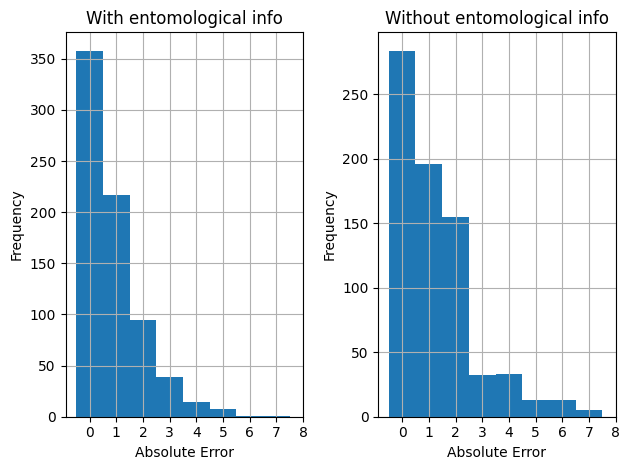

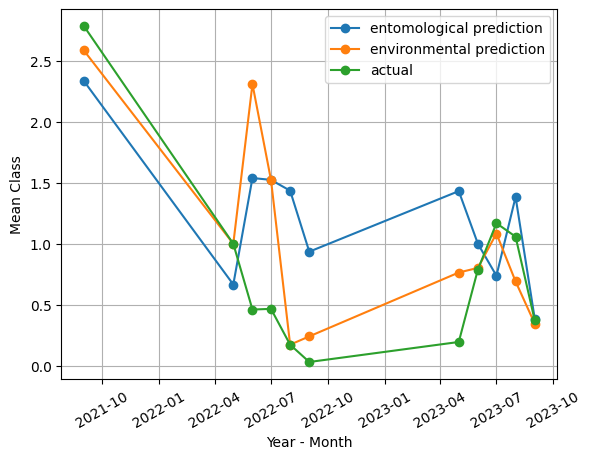

[8. 6. 4. 7. 2. 5. 1. 0. 3.]
[8. 6. 4. 7. 2. 5. 1. 0. 3.]


IndexError: list index out of range

In [10]:
validation_plots_comparison(path)
metrics_plot_comparison(path)
# plot_correlations_comparison(path)

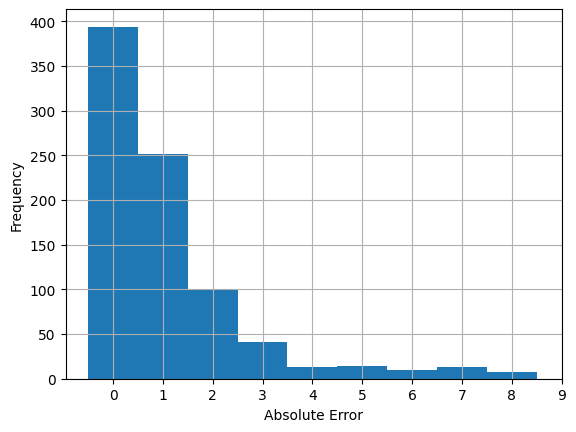

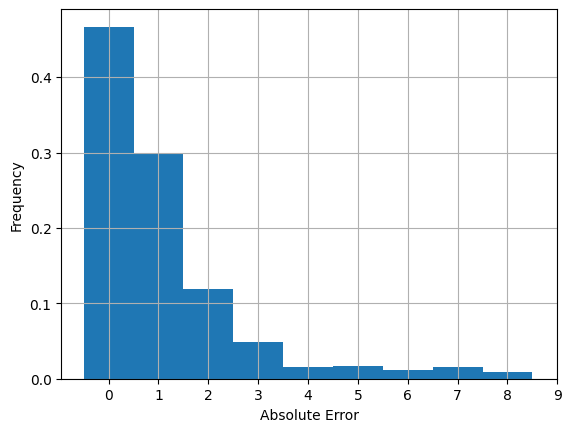

Error 0: 0.466824644549763
Error 1: 0.29739336492890994
Error 0+1: 0.764218009478673


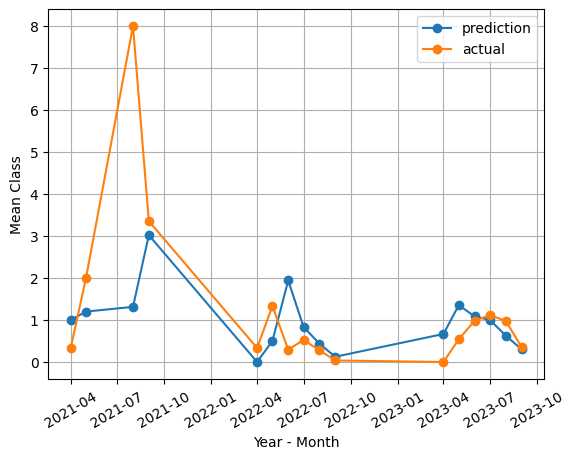

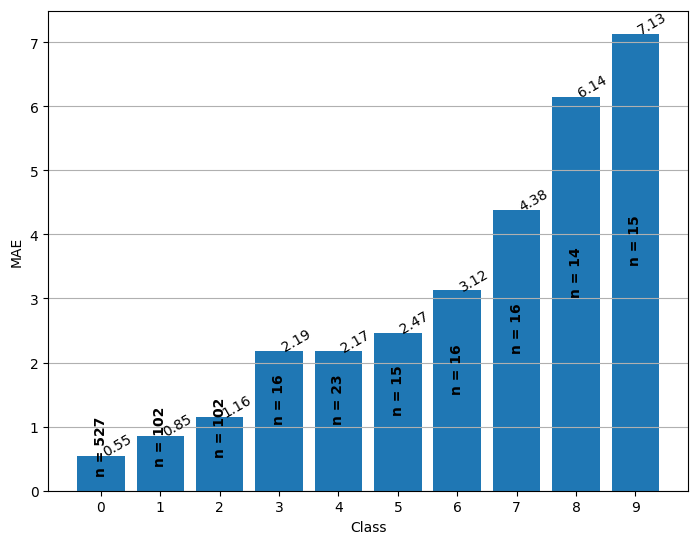

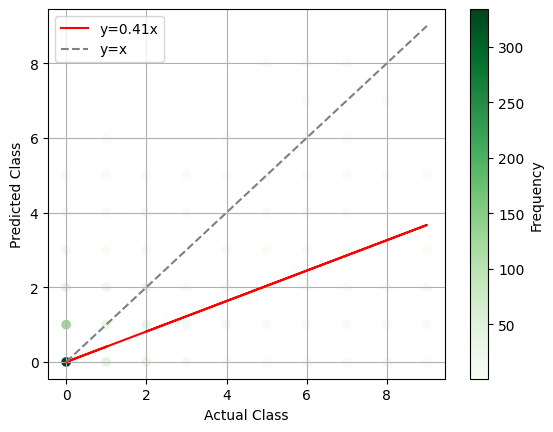

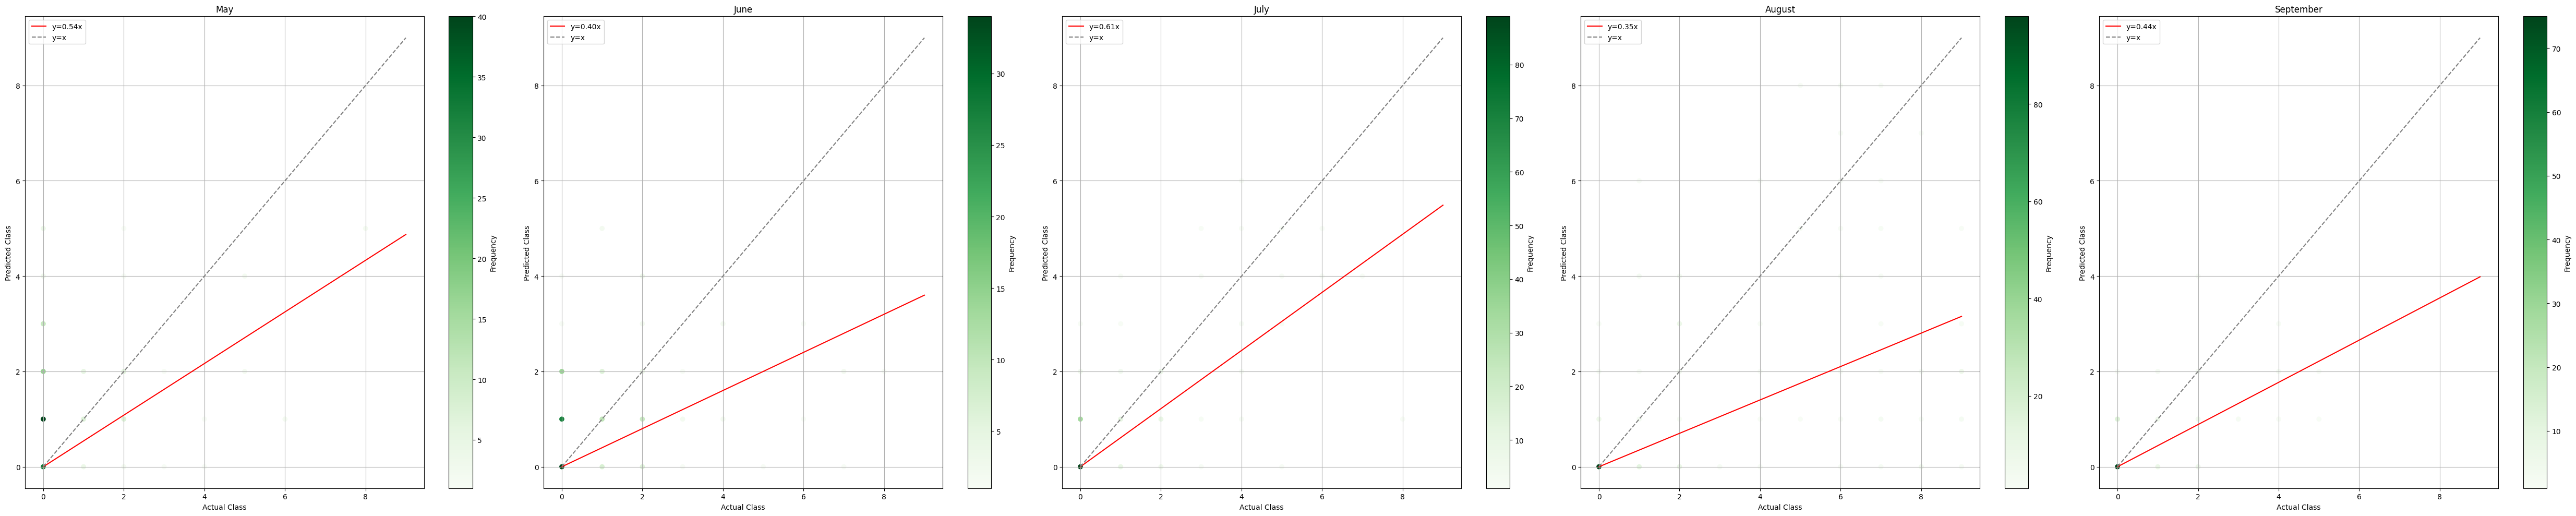

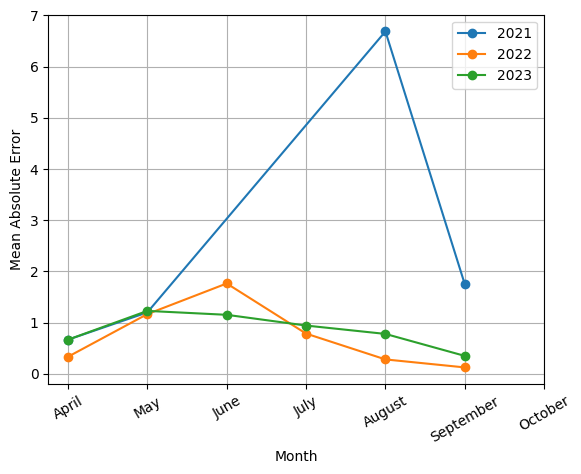

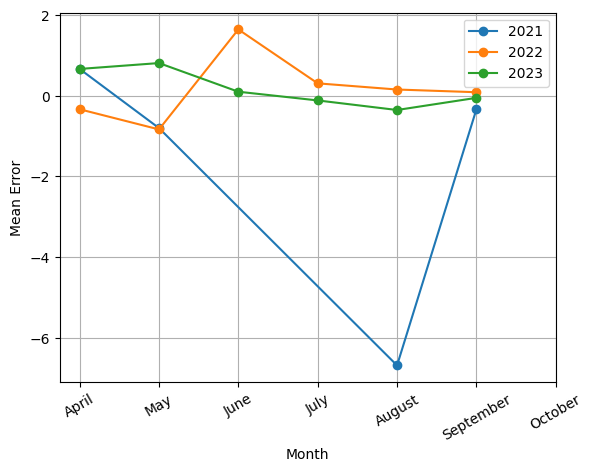

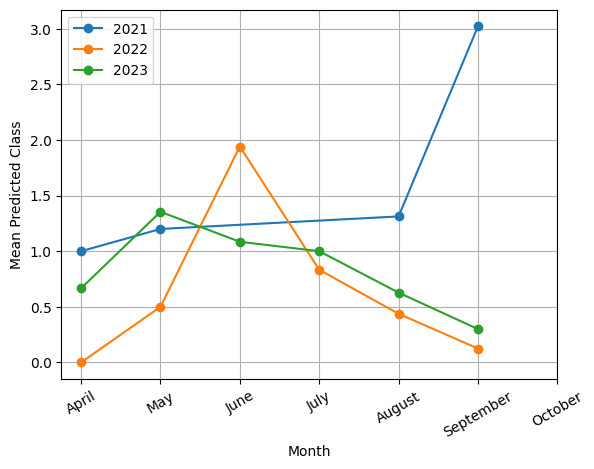

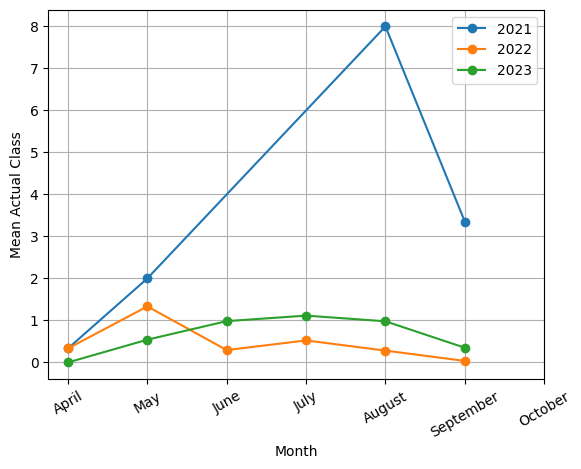

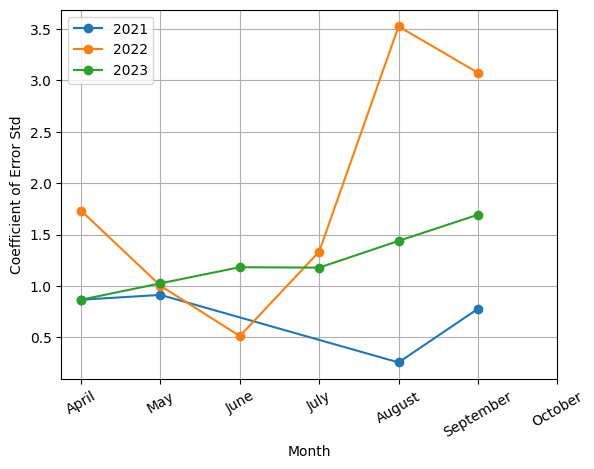

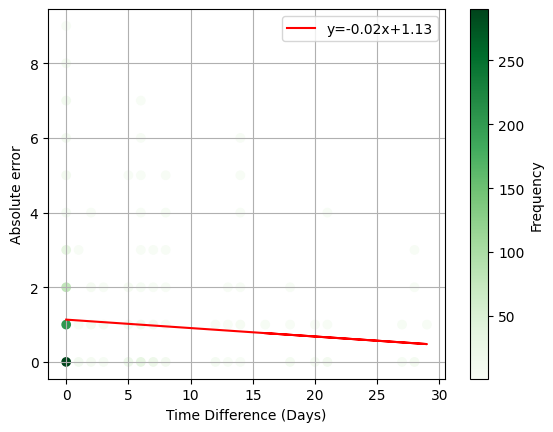

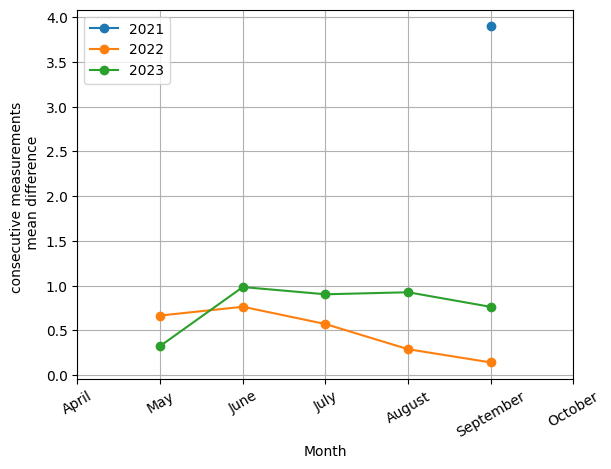

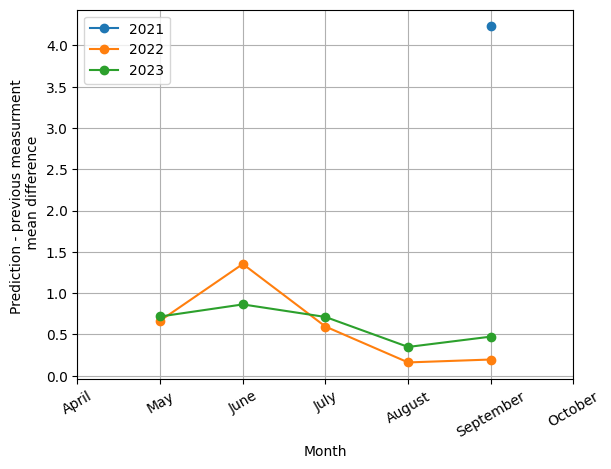

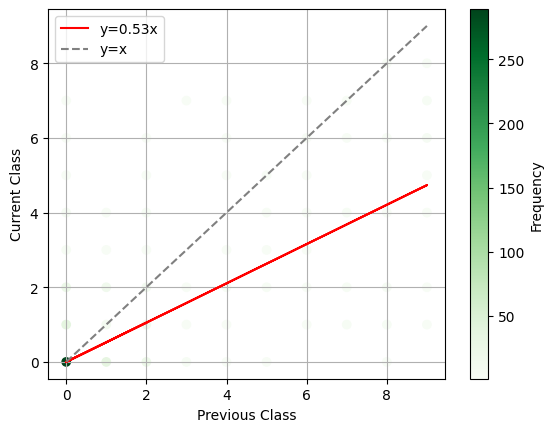

May: 0.9387755102040817
June: 0.7590361445783133
July: 0.8082191780821918
August: 0.7928571428571428
September: 0.5704225352112676


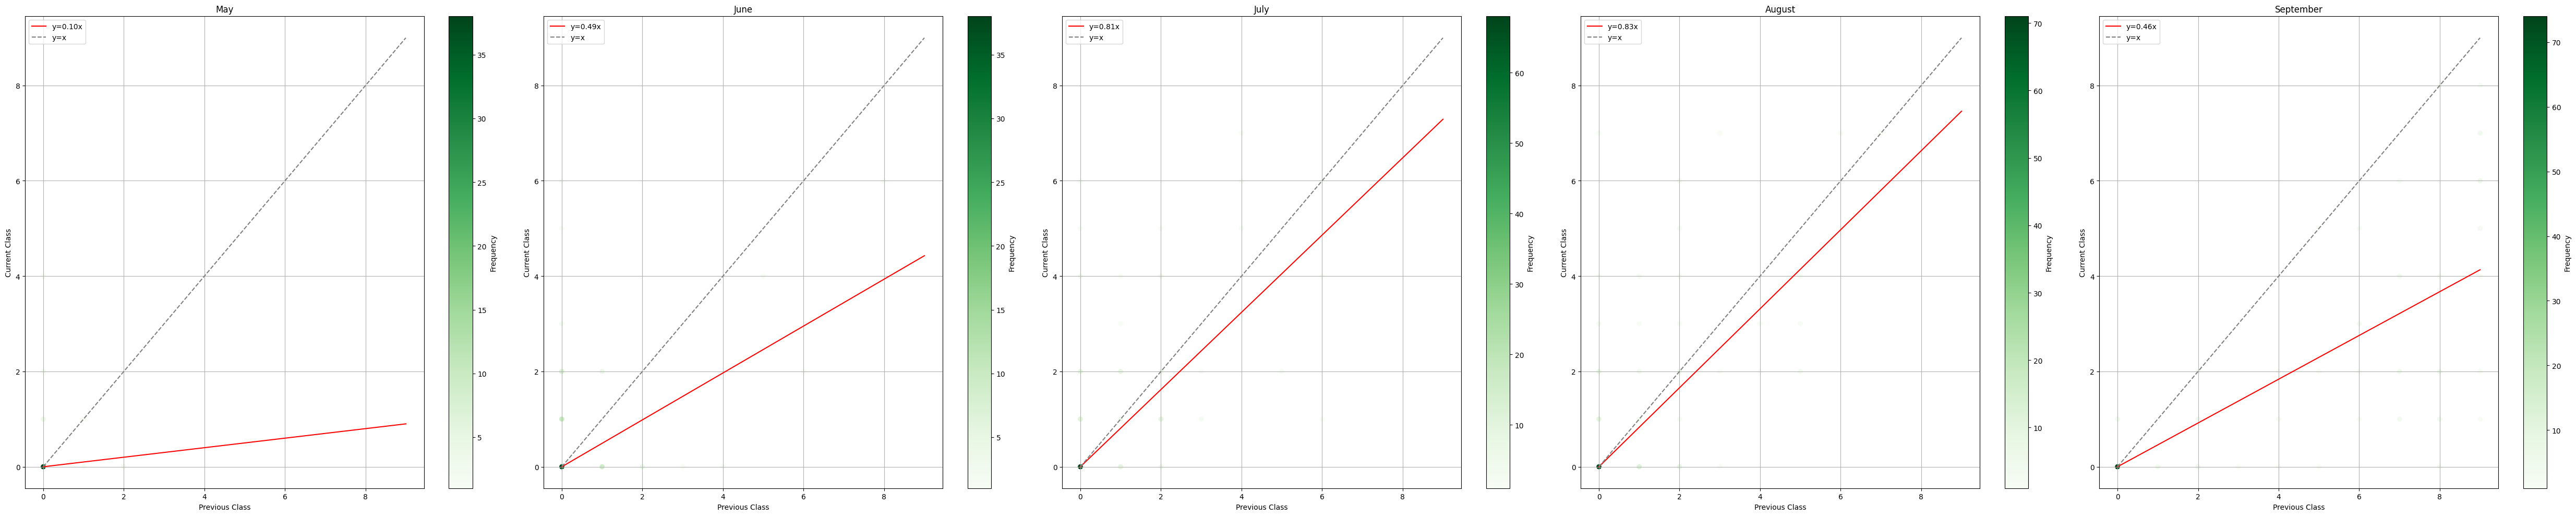

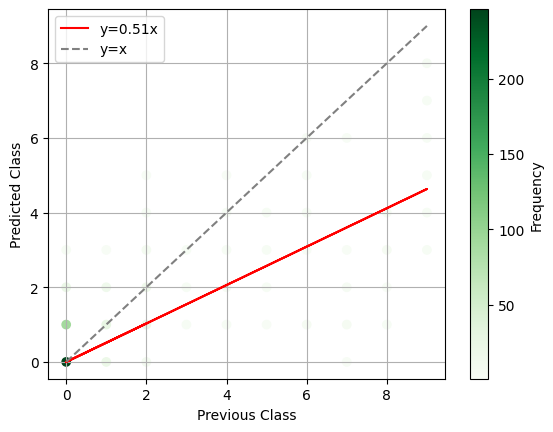

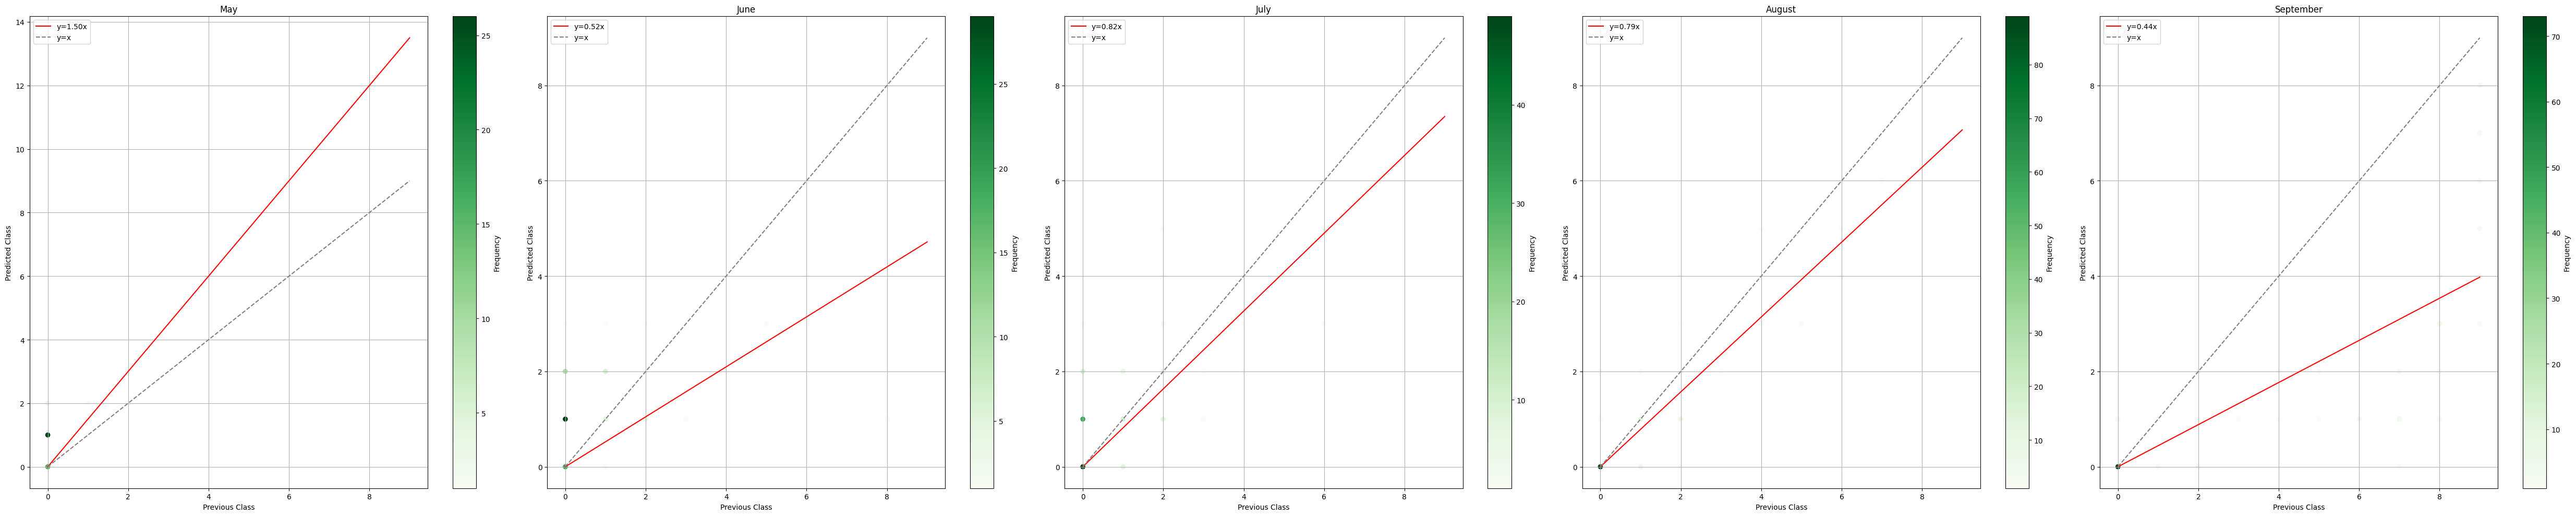

Overall MAE: 1.0981087470449173
Scaled MAE: 0.5218196654114619
Bias: -0.19739952718676124
Error <= 3: 92.91
Overall MAE with entomolgical info: 0.8392857142857143
% of error <= 3 with entomolgical info: 97.32
Overall MAE without entomolgical info: 1.6048951048951048
% of error <= 3 without entomolgical info: 84.27


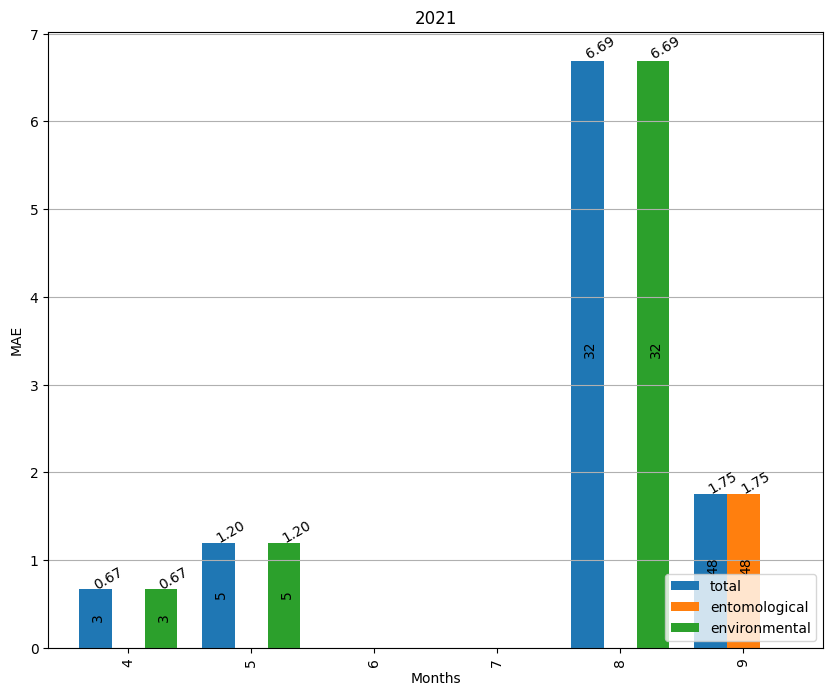

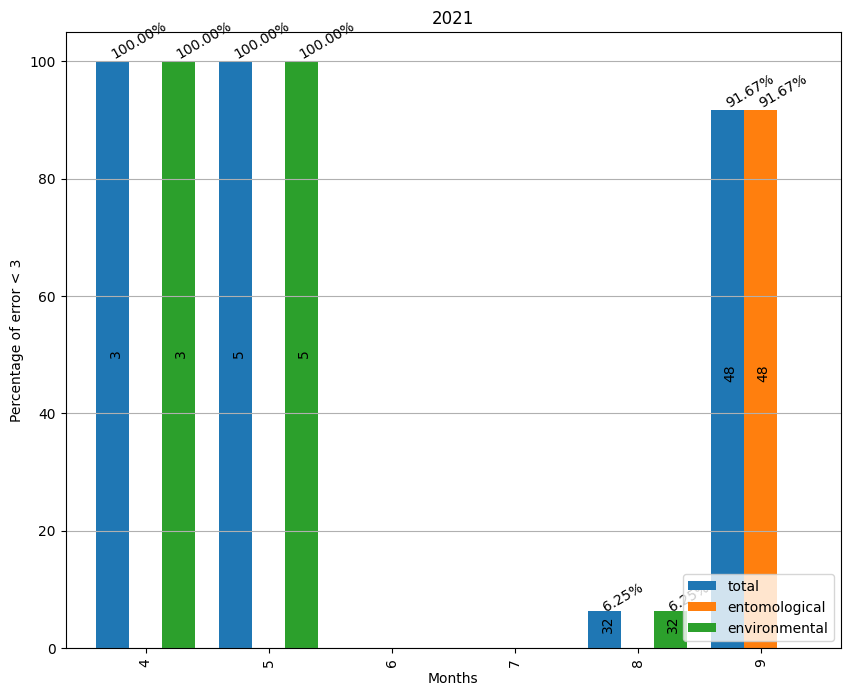

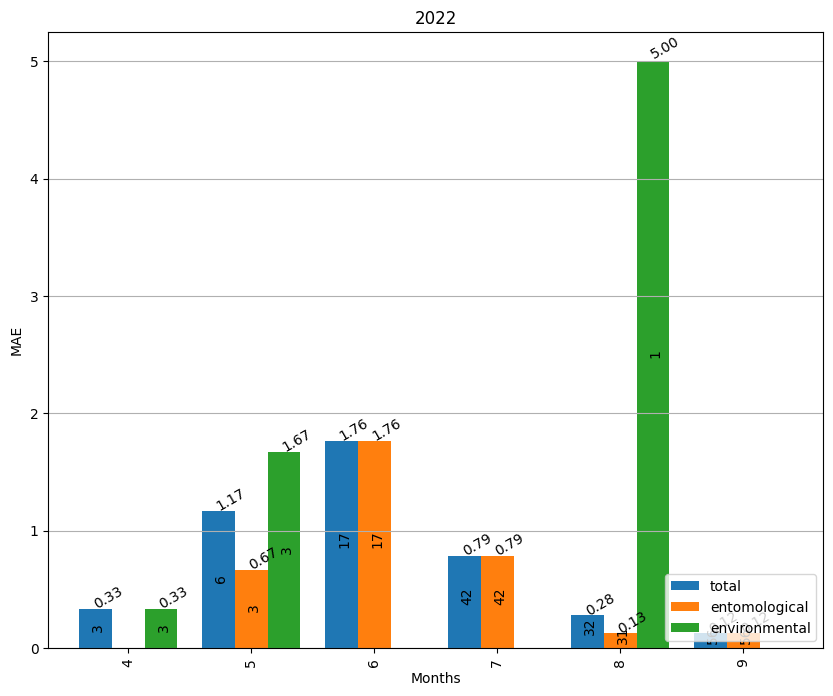

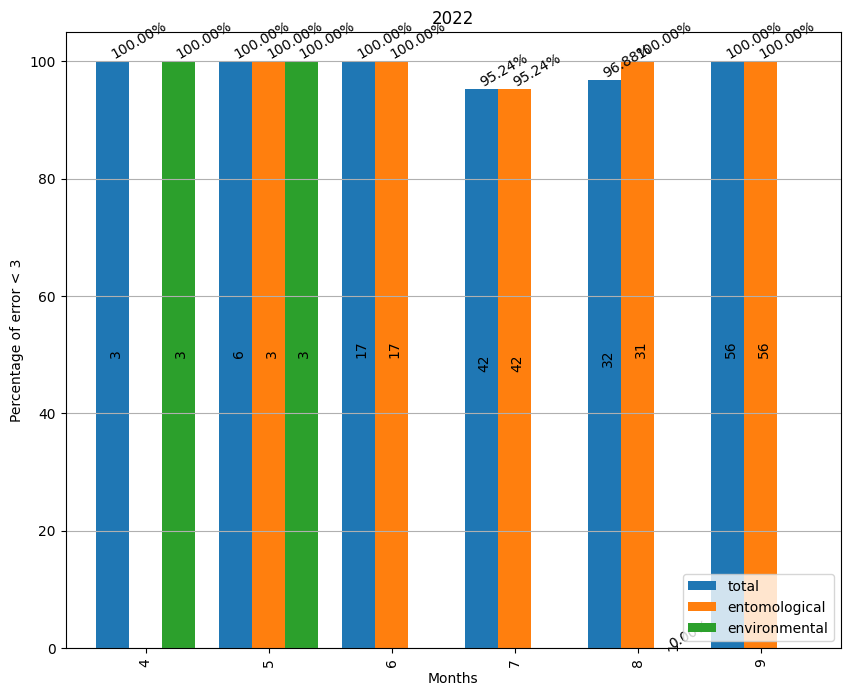

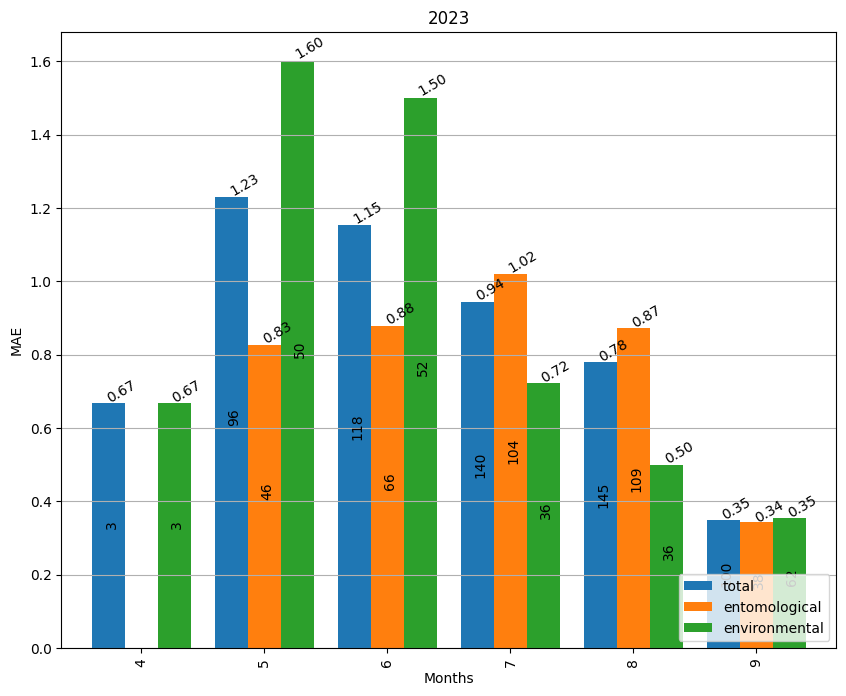

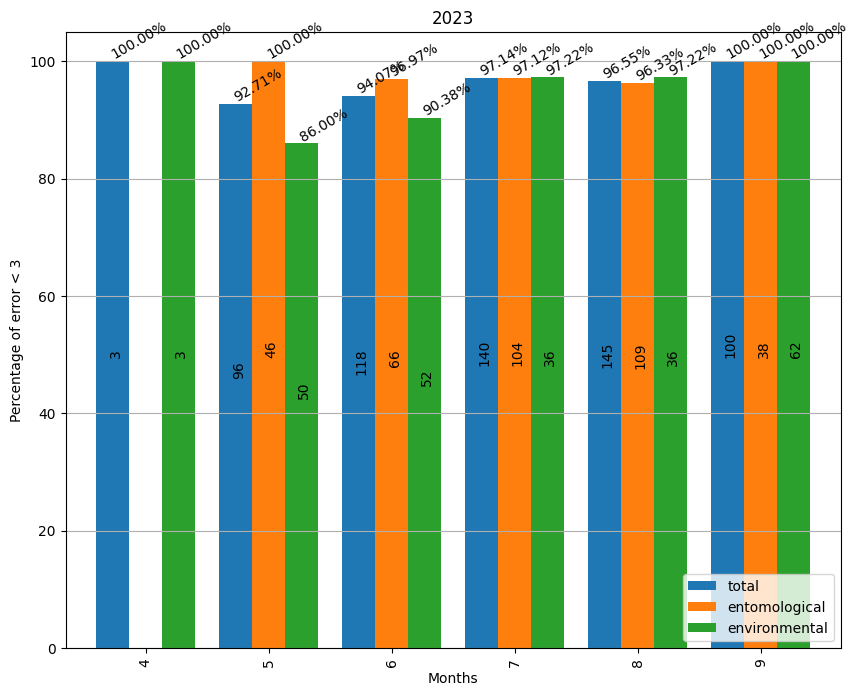

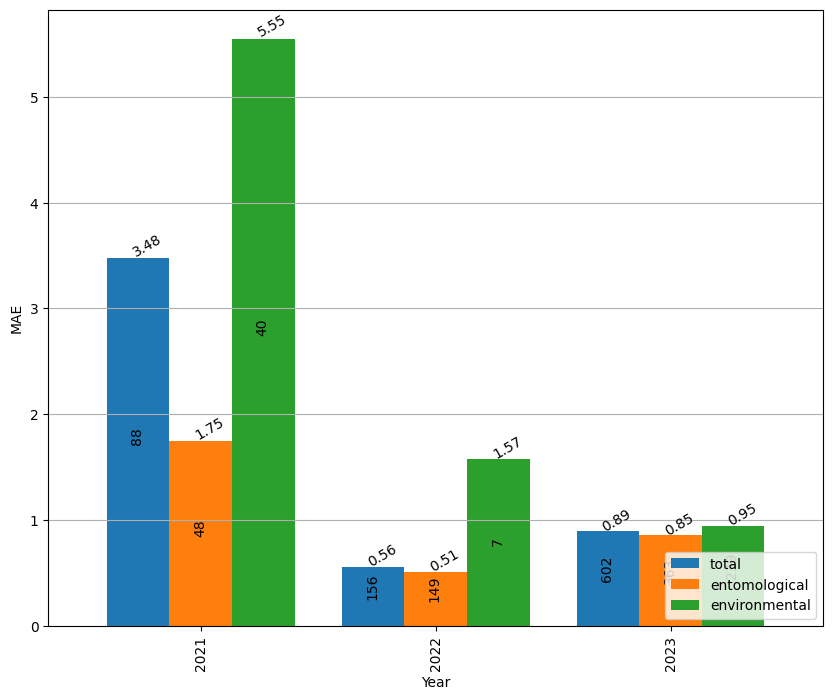

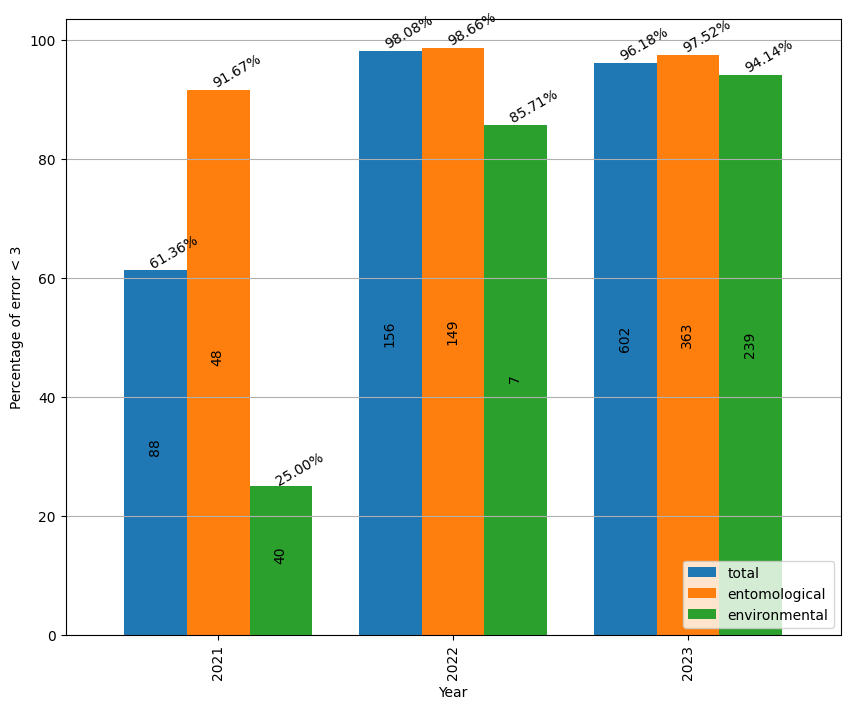

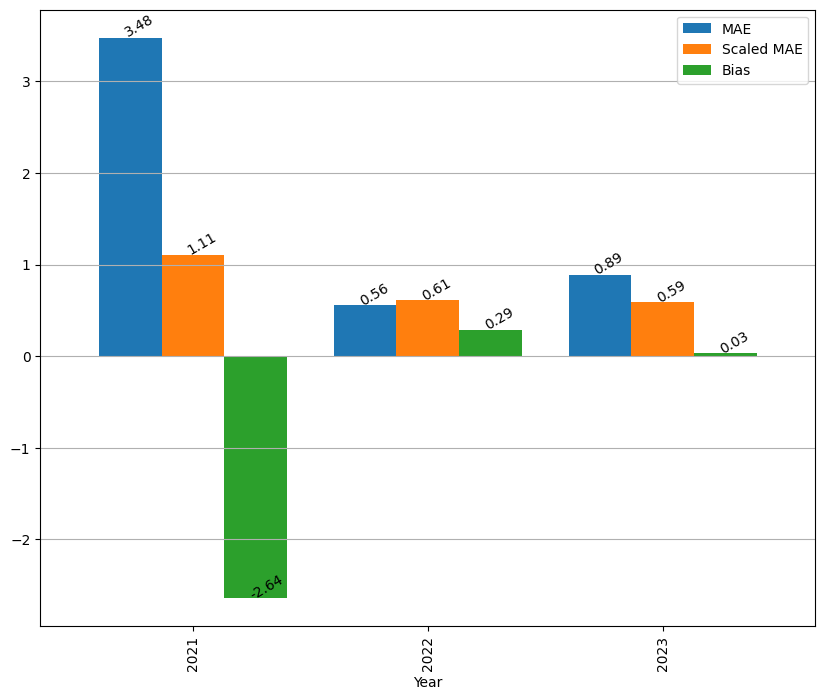

In [11]:
validation_plots(path)
metrics_plot(path)
# plot_correlations(path)

In [ ]:
import sys
sys.modules.pop('Model_Validation_Module')
from Model_Validation_Module import give_predictions_nn, evaluate_nn, give_predictions_xgboost, evaluate_xgboost, validate_results, validate_results2, merge_predictions
sys.modules.pop('XGboost_Model_Module')
from XGboost_Model_Module import Xgboost_model